In [1]:
import asyncio
import nest_asyncio
import json
import unittest
from os import path, getcwd

import funman.api.client as client
from funman.api.api import app
from funman.api.server import Server, ServerConfig

API_BASE_PATH = path.join(getcwd(), "..")
API_SERVER_HOST = "0.0.0.0"
API_SERVER_PORT = 8190
SERVER_URL = f"http://{API_SERVER_HOST}:{API_SERVER_PORT}"
OPENAPI_URL = f"{SERVER_URL}/openapi.json"
CLIENT_NAME = "funman-api-client"

In [2]:
# Start API Server
server = Server(
            config=ServerConfig(
                app,
                host=API_SERVER_HOST,
                port=API_SERVER_PORT,
                log_level="info",
            )
        )
nest_asyncio.apply()
thread = server.start_in_thread()

INFO:     Started server process [735]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8190 (Press CTRL+C to quit)


In [3]:
# Install API client to the working directory
# and add the install to the sys path
client.make_client(
    API_BASE_PATH, openapi_url=OPENAPI_URL, client_name=CLIENT_NAME
)

Updating existing funman client at /home/jladwig/funman from http://0.0.0.0:8190/openapi.json
INFO:     127.0.0.1:34212 - "GET /openapi.json HTTP/1.1" 200 OK
Updating funman_api_client


In [18]:
# Setup API client request
from funman_api_client import Client
from funman_api_client.api.default import (
    post_queries_queries_post,
)
from funman_api_client.models.body_post_queries_queries_post import BodyPostQueriesQueriesPost
from funman_api_client.models import (
    BilayerModel,
    FUNMANConfig,
    LabeledParameter,
    QueryLE,
    QueryRequest,
    QueryResponse
)

funman_client = Client(SERVER_URL, timeout=None)

In [ ]:
bilayer_json =     {"Wa":[{"influx":1,"infusion":2},
			 {"influx":2,"infusion":3}],
 "Win":[{"arg":1,"call":1},
 				{"arg":2,"call":1},
 				{"arg":2,"call":2}],
 "Box":[{"parameter":"beta"},
 				{"parameter":"gamma"}],
 "Qin":[{"variable":"S"},
 				{"variable":"I"},
 				{"variable":"R"}],
 "Qout":[{"tanvar":"S'"},
 				 {"tanvar":"I'"},
 				 {"tanvar":"R'"}],
 "Wn":[{"efflux":1,"effusion":1},
 			 {"efflux":2,"effusion":2}]}

infected_threshold = 130
init_values = {"S": 9998, "I": 1, "R": 1}

lb = 0.000067 * (1 - 0.5)
ub = 0.000067 * (1 + 0.5)

response = asyncio.run(
    post_queries_queries_post.asyncio_detailed(
        client=funman_client,
        json_body=BodyPostQueriesQueriesPost(
            QueryRequest(
                model = BilayerModel.from_dict(
                    {
                        "init_values": init_values,
                        "bilayer": {"json_graph": bilayer_json},
                    }
                ),
                query = QueryLE.from_dict(
                    {
                        "variable": "I",
                        "ub": infected_threshold,
                        "at_end": False,
                    }
                ),
                parameters = [
                    #LabeledParameter.from_dict({
                    #    "name": "beta",
                    #    "lb": lb,      
                    #    "ub": ub,
                    #    "label": "all",
                    #})
                ]
            ),
            FUNMANConfig.from_dict(
                {
                    "tolerance": 1.0e-8,
                    "number_of_processes": 1
                }
            ),  
        ),
    )
)

result = QueryResponse.from_dict(
    src_dict=json.loads(response.content.decode())
)
result.parameter_space

Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 0.00010002000400080016}}) is marked false, but already marked true.


Starting initializing dynamics of model
Initialized dynamics of model
Split(Box({'beta': {'lb': 3.35e-05, 'ub': 0.0001005}}), width = 6.7e-05)
Split(Box({'beta': {'lb': 6.7e-05, 'ub': 0.0001005}}), width = 3.35e-05)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.001000200040008e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.35e-05, 'ub': 6.7e-05}}), width = 3.35e-05)
Split(Box({'beta': {'lb': 8.375e-05, 'ub': 0.0001005}}), width = 1.675e-05)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.501500300060012e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.7e-05, 'ub': 8.375e-05}}), width = 1.675e-05)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.25125025005001e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.025e-05, 'ub': 6.7e-05}}), width = 1.675e-05)
Split(Box({'beta': {'lb': 3.35e-05, 'ub': 5.025e-05}}), width = 1.675e-05)
Split(Box({'beta': {'lb': 9.2125e-05, 'ub': 0.0001005}}), width = 8.375e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.751750350070014e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.375e-05, 'ub': 9.2125e-05}}), width = 8.375e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.126625325065012e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.5375e-05, 'ub': 8.375e-05}}), width = 8.375e-06)
Split(Box({'beta': {'lb': 6.7e-05, 'ub': 7.5375e-05}}), width = 8.375e-06)
Split(Box({'beta': {'lb': 5.8625e-05, 'ub': 6.7e-05}}), width = 8.375e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.626125225045009e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.025e-05, 'ub': 5.8625e-05}}), width = 8.375e-06)
Split(Box({'beta': {'lb': 4.1875e-05, 'ub': 5.025e-05}}), width = 8.375e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.750750150030006e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.35e-05, 'ub': 4.1875e-05}}), width = 8.375e-06)
Split(Box({'beta': {'lb': 9.63125e-05, 'ub': 0.0001005}}), width = 4.1875e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.376875375075014e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.2125e-05, 'ub': 9.63125e-05}}), width = 4.1875e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.064312862572515e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.79375e-05, 'ub': 9.2125e-05}}), width = 4.1875e-06)
Split(Box({'beta': {'lb': 8.375e-05, 'ub': 8.79375e-05}}), width = 4.1875e-06)
Split(Box({'beta': {'lb': 7.95625e-05, 'ub': 8.375e-05}}), width = 4.1875e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.814062812562513e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.5375e-05, 'ub': 7.95625e-05}}), width = 4.1875e-06)
Split(Box({'beta': {'lb': 7.11875e-05, 'ub': 7.5375e-05}}), width = 4.1875e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.87637527505501e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.7e-05, 'ub': 7.11875e-05}}), width = 4.1875e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.563812762552511e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.28125e-05, 'ub': 6.7e-05}}), width = 4.1875e-06)
Split(Box({'beta': {'lb': 5.8625e-05, 'ub': 6.28125e-05}}), width = 4.1875e-06)
Split(Box({'beta': {'lb': 5.44375e-05, 'ub': 5.8625e-05}}), width = 4.1875e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.313562712542508e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.025e-05, 'ub': 5.44375e-05}}), width = 4.1875e-06)
Split(Box({'beta': {'lb': 4.60625e-05, 'ub': 5.025e-05}}), width = 4.1875e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.375875175035007e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.1875e-05, 'ub': 4.60625e-05}}), width = 4.1875e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.063312662532506e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.76875e-05, 'ub': 4.1875e-05}}), width = 4.1875e-06)
Split(Box({'beta': {'lb': 3.35e-05, 'ub': 3.76875e-05}}), width = 4.1875e-06)
Split(Box({'beta': {'lb': 9.840625e-05, 'ub': 0.0001005}}), width = 2.093750000000007e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.689437887577515e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.63125e-05, 'ub': 9.840625e-05}}), width = 2.0937499999999933e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.533156631326265e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.421875000000001e-05, 'ub': 9.63125e-05}}), width = 2.0937499999999933e-06)
Split(Box({'beta': {'lb': 9.2125e-05, 'ub': 9.421875000000001e-05}}), width = 2.093750000000007e-06)
Split(Box({'beta': {'lb': 9.003125e-05, 'ub': 9.2125e-05}}), width = 2.093750000000007e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.908031606321264e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.79375e-05, 'ub': 9.003125e-05}}), width = 2.0937499999999933e-06)
Split(Box({'beta': {'lb': 8.584375000000001e-05, 'ub': 8.79375e-05}}), width = 2.0937499999999933e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.439187837567513e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.375e-05, 'ub': 8.584375000000001e-05}}), width = 2.093750000000007e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.282906581316263e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.165625e-05, 'ub': 8.375e-05}}), width = 2.093750000000007e-06)
Split(Box({'beta': {'lb': 7.95625e-05, 'ub': 8.165625e-05}}), width = 2.0937499999999933e-06)
Split(Box({'beta': {'lb': 7.746875000000001e-05, 'ub': 7.95625e-05}}), width = 2.0937499999999933e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.657781556311262e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.5375e-05, 'ub': 7.746875000000001e-05}}), width = 2.093750000000007e-06)
Split(Box({'beta': {'lb': 7.328125e-05, 'ub': 7.5375e-05}}), width = 2.093750000000007e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.188937787557511e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.11875e-05, 'ub': 7.328125e-05}}), width = 2.0937499999999933e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.032656531306261e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.909375000000001e-05, 'ub': 7.11875e-05}}), width = 2.0937499999999933e-06)
Split(Box({'beta': {'lb': 6.7e-05, 'ub': 6.909375000000001e-05}}), width = 2.093750000000007e-06)
Split(Box({'beta': {'lb': 6.490625e-05, 'ub': 6.7e-05}}), width = 2.093750000000007e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.40753150630126e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.28125e-05, 'ub': 6.490625e-05}}), width = 2.0937499999999933e-06)
Split(Box({'beta': {'lb': 6.071875e-05, 'ub': 6.28125e-05}}), width = 2.09375e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.938687737547509e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.8625e-05, 'ub': 6.071875e-05}}), width = 2.09375e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.7824064812962594e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.653125e-05, 'ub': 5.8625e-05}}), width = 2.09375e-06)
Split(Box({'beta': {'lb': 5.44375e-05, 'ub': 5.653125e-05}}), width = 2.09375e-06)
Split(Box({'beta': {'lb': 5.234375e-05, 'ub': 5.44375e-05}}), width = 2.09375e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.1572814562912584e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.025e-05, 'ub': 5.234375e-05}}), width = 2.09375e-06)
Split(Box({'beta': {'lb': 4.815625e-05, 'ub': 5.025e-05}}), width = 2.09375e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.688437687537507e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.60625e-05, 'ub': 4.815625e-05}}), width = 2.09375e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.5321564312862574e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.396875e-05, 'ub': 4.60625e-05}}), width = 2.09375e-06)
Split(Box({'beta': {'lb': 4.1875e-05, 'ub': 4.396875e-05}}), width = 2.09375e-06)
Split(Box({'beta': {'lb': 3.978125e-05, 'ub': 4.1875e-05}}), width = 2.09375e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.9070314062812564e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.76875e-05, 'ub': 3.978125e-05}}), width = 2.09375e-06)
Split(Box({'beta': {'lb': 3.559375e-05, 'ub': 3.76875e-05}}), width = 2.09375e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.438187637527505e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.35e-05, 'ub': 3.559375e-05}}), width = 2.09375e-06)
Split(Box({'beta': {'lb': 9.9453125e-05, 'ub': 0.0001005}}), width = 1.0468750000000034e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.845719143828766e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.840625e-05, 'ub': 9.9453125e-05}}), width = 1.0468750000000034e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.767578515703141e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.7359375e-05, 'ub': 9.840625e-05}}), width = 1.0468749999999899e-06)
Split(Box({'beta': {'lb': 9.63125e-05, 'ub': 9.7359375e-05}}), width = 1.0468750000000034e-06)
Split(Box({'beta': {'lb': 9.5265625e-05, 'ub': 9.63125e-05}}), width = 1.0468750000000034e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.45501600320064e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.421875000000001e-05, 'ub': 9.5265625e-05}}), width = 1.0468749999999899e-06)
Split(Box({'beta': {'lb': 9.3171875e-05, 'ub': 9.421875000000001e-05}}), width = 1.0468750000000034e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.220594118823765e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.2125e-05, 'ub': 9.3171875e-05}}), width = 1.0468750000000034e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.142453490698139e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.1078125e-05, 'ub': 9.2125e-05}}), width = 1.0468750000000034e-06)
Split(Box({'beta': {'lb': 9.003125e-05, 'ub': 9.1078125e-05}}), width = 1.0468750000000034e-06)
Split(Box({'beta': {'lb': 8.8984375e-05, 'ub': 9.003125e-05}}), width = 1.0468749999999899e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.82989097819564e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.79375e-05, 'ub': 8.8984375e-05}}), width = 1.0468750000000034e-06)
Split(Box({'beta': {'lb': 8.6890625e-05, 'ub': 8.79375e-05}}), width = 1.0468750000000034e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.595469093818764e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.584375000000001e-05, 'ub': 8.6890625e-05}}), width = 1.0468749999999899e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.517328465693139e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.4796875e-05, 'ub': 8.584375000000001e-05}}), width = 1.0468750000000034e-06)
Split(Box({'beta': {'lb': 8.375e-05, 'ub': 8.4796875e-05}}), width = 1.0468750000000034e-06)
Split(Box({'beta': {'lb': 8.2703125e-05, 'ub': 8.375e-05}}), width = 1.0468750000000034e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.204765953190638e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.165625e-05, 'ub': 8.2703125e-05}}), width = 1.0468750000000034e-06)
Split(Box({'beta': {'lb': 8.0609375e-05, 'ub': 8.165625e-05}}), width = 1.0468749999999899e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.970344068813763e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.95625e-05, 'ub': 8.0609375e-05}}), width = 1.0468750000000034e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.892203440688137e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.8515625e-05, 'ub': 7.95625e-05}}), width = 1.0468750000000034e-06)
Split(Box({'beta': {'lb': 7.746875000000001e-05, 'ub': 7.8515625e-05}}), width = 1.0468749999999899e-06)
Split(Box({'beta': {'lb': 7.6421875e-05, 'ub': 7.746875000000001e-05}}), width = 1.0468750000000034e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.579640928185638e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.5375e-05, 'ub': 7.6421875e-05}}), width = 1.0468750000000034e-06)
Split(Box({'beta': {'lb': 7.4328125e-05, 'ub': 7.5375e-05}}), width = 1.0468750000000034e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.345219043808762e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.328125e-05, 'ub': 7.4328125e-05}}), width = 1.0468750000000034e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.267078415683137e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.2234375e-05, 'ub': 7.328125e-05}}), width = 1.0468749999999899e-06)
Split(Box({'beta': {'lb': 7.11875e-05, 'ub': 7.2234375e-05}}), width = 1.0468750000000034e-06)
Split(Box({'beta': {'lb': 7.0140625e-05, 'ub': 7.11875e-05}}), width = 1.0468750000000034e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.954515903180636e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.909375000000001e-05, 'ub': 7.0140625e-05}}), width = 1.0468749999999899e-06)
Split(Box({'beta': {'lb': 6.8046875e-05, 'ub': 6.909375000000001e-05}}), width = 1.0468750000000034e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.72009401880376e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.7e-05, 'ub': 6.8046875e-05}}), width = 1.0468750000000034e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.641953390678135e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.5953125e-05, 'ub': 6.7e-05}}), width = 1.0468750000000034e-06)
Split(Box({'beta': {'lb': 6.490625e-05, 'ub': 6.5953125e-05}}), width = 1.0468750000000034e-06)
Split(Box({'beta': {'lb': 6.3859375e-05, 'ub': 6.490625e-05}}), width = 1.0468749999999899e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.329390878175636e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.28125e-05, 'ub': 6.3859375e-05}}), width = 1.0468750000000034e-06)
Split(Box({'beta': {'lb': 6.1765625e-05, 'ub': 6.28125e-05}}), width = 1.0468750000000034e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.0949689937987596e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.071875e-05, 'ub': 6.1765625e-05}}), width = 1.0468749999999966e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.016828365673135e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.9671875000000005e-05, 'ub': 6.071875e-05}}), width = 1.0468749999999966e-06)
Split(Box({'beta': {'lb': 5.8625e-05, 'ub': 5.9671875000000005e-05}}), width = 1.0468750000000034e-06)
Split(Box({'beta': {'lb': 5.7578125e-05, 'ub': 5.8625e-05}}), width = 1.0468750000000034e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.704265853170634e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.653125e-05, 'ub': 5.7578125e-05}}), width = 1.0468749999999966e-06)
Split(Box({'beta': {'lb': 5.5484375000000005e-05, 'ub': 5.653125e-05}}), width = 1.0468749999999966e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.4698439687937586e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.44375e-05, 'ub': 5.5484375000000005e-05}}), width = 1.0468750000000034e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.391703340668134e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.3390625e-05, 'ub': 5.44375e-05}}), width = 1.0468750000000034e-06)
Split(Box({'beta': {'lb': 5.234375e-05, 'ub': 5.3390625e-05}}), width = 1.0468749999999966e-06)
Split(Box({'beta': {'lb': 5.1296875000000005e-05, 'ub': 5.234375e-05}}), width = 1.0468749999999966e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.079140828165633e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.025e-05, 'ub': 5.1296875000000005e-05}}), width = 1.0468750000000034e-06)
Split(Box({'beta': {'lb': 4.9203125e-05, 'ub': 5.025e-05}}), width = 1.0468750000000034e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.8447189437887576e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.815625e-05, 'ub': 4.9203125e-05}}), width = 1.0468749999999966e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.766578315663133e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.7109375000000005e-05, 'ub': 4.815625e-05}}), width = 1.0468749999999966e-06)
Split(Box({'beta': {'lb': 4.60625e-05, 'ub': 4.7109375000000005e-05}}), width = 1.0468750000000034e-06)
Split(Box({'beta': {'lb': 4.5015625e-05, 'ub': 4.60625e-05}}), width = 1.0468750000000034e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.454015803160632e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.396875e-05, 'ub': 4.5015625e-05}}), width = 1.0468749999999966e-06)
Split(Box({'beta': {'lb': 4.2921875000000005e-05, 'ub': 4.396875e-05}}), width = 1.0468749999999966e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.2195939187837566e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.1875e-05, 'ub': 4.2921875000000005e-05}}), width = 1.0468750000000034e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.141453290658132e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.0828125e-05, 'ub': 4.1875e-05}}), width = 1.0468750000000034e-06)
Split(Box({'beta': {'lb': 3.978125e-05, 'ub': 4.0828125e-05}}), width = 1.0468749999999966e-06)
Split(Box({'beta': {'lb': 3.8734375000000005e-05, 'ub': 3.978125e-05}}), width = 1.0468749999999966e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.828890778155631e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.76875e-05, 'ub': 3.8734375000000005e-05}}), width = 1.0468750000000034e-06)
Split(Box({'beta': {'lb': 3.6640625e-05, 'ub': 3.76875e-05}}), width = 1.0468750000000034e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.5944688937787556e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.559375e-05, 'ub': 3.6640625e-05}}), width = 1.0468749999999966e-06)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.516328265653131e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.4546875000000005e-05, 'ub': 3.559375e-05}}), width = 1.0468749999999966e-06)
Split(Box({'beta': {'lb': 3.35e-05, 'ub': 3.4546875000000005e-05}}), width = 1.0468750000000034e-06)
Split(Box({'beta': {'lb': 9.99765625e-05, 'ub': 0.0001005}}), width = 5.234375000000085e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.962930086017204e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.9453125e-05, 'ub': 9.99765625e-05}}), width = 5.234374999999949e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.92385977195439e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.89296875e-05, 'ub': 9.9453125e-05}}), width = 5.234374999999949e-07)
Split(Box({'beta': {'lb': 9.840625e-05, 'ub': 9.89296875e-05}}), width = 5.234375000000085e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.806648829765953e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.78828125e-05, 'ub': 9.840625e-05}}), width = 5.234374999999949e-07)
Split(Box({'beta': {'lb': 9.7359375e-05, 'ub': 9.78828125e-05}}), width = 5.234374999999949e-07)
Split(Box({'beta': {'lb': 9.68359375e-05, 'ub': 9.7359375e-05}}), width = 5.234375000000085e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.650367573514703e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.63125e-05, 'ub': 9.68359375e-05}}), width = 5.234374999999949e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.611297259451891e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.578906250000001e-05, 'ub': 9.63125e-05}}), width = 5.234374999999949e-07)
Split(Box({'beta': {'lb': 9.5265625e-05, 'ub': 9.578906250000001e-05}}), width = 5.234375000000085e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.494086317263453e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.47421875e-05, 'ub': 9.5265625e-05}}), width = 5.234374999999949e-07)
Split(Box({'beta': {'lb': 9.421875000000001e-05, 'ub': 9.47421875e-05}}), width = 5.234374999999949e-07)
Split(Box({'beta': {'lb': 9.36953125e-05, 'ub': 9.421875000000001e-05}}), width = 5.234375000000085e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.337805061012202e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.3171875e-05, 'ub': 9.36953125e-05}}), width = 5.234374999999949e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.29873474694939e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.264843750000001e-05, 'ub': 9.3171875e-05}}), width = 5.234374999999949e-07)
Split(Box({'beta': {'lb': 9.2125e-05, 'ub': 9.264843750000001e-05}}), width = 5.234375000000085e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.181523804760953e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.16015625e-05, 'ub': 9.2125e-05}}), width = 5.234375000000085e-07)
Split(Box({'beta': {'lb': 9.1078125e-05, 'ub': 9.16015625e-05}}), width = 5.234374999999949e-07)
Split(Box({'beta': {'lb': 9.05546875e-05, 'ub': 9.1078125e-05}}), width = 5.234374999999949e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.025242548509701e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.003125e-05, 'ub': 9.05546875e-05}}), width = 5.234375000000085e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.986172234446889e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.95078125e-05, 'ub': 9.003125e-05}}), width = 5.234374999999949e-07)
Split(Box({'beta': {'lb': 8.8984375e-05, 'ub': 8.95078125e-05}}), width = 5.234374999999949e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.868961292258452e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.84609375e-05, 'ub': 8.8984375e-05}}), width = 5.234375000000085e-07)
Split(Box({'beta': {'lb': 8.79375e-05, 'ub': 8.84609375e-05}}), width = 5.234374999999949e-07)
Split(Box({'beta': {'lb': 8.741406250000001e-05, 'ub': 8.79375e-05}}), width = 5.234374999999949e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.712680036007202e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.6890625e-05, 'ub': 8.741406250000001e-05}}), width = 5.234375000000085e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.673609721944388e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.63671875e-05, 'ub': 8.6890625e-05}}), width = 5.234374999999949e-07)
Split(Box({'beta': {'lb': 8.584375000000001e-05, 'ub': 8.63671875e-05}}), width = 5.234374999999949e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.556398779755951e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.53203125e-05, 'ub': 8.584375000000001e-05}}), width = 5.234375000000085e-07)
Split(Box({'beta': {'lb': 8.4796875e-05, 'ub': 8.53203125e-05}}), width = 5.234374999999949e-07)
Split(Box({'beta': {'lb': 8.427343750000001e-05, 'ub': 8.4796875e-05}}), width = 5.234374999999949e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.400117523504701e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.375e-05, 'ub': 8.427343750000001e-05}}), width = 5.234375000000085e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.361047209441889e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.32265625e-05, 'ub': 8.375e-05}}), width = 5.234375000000085e-07)
Split(Box({'beta': {'lb': 8.2703125e-05, 'ub': 8.32265625e-05}}), width = 5.234374999999949e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.243836267253451e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.21796875e-05, 'ub': 8.2703125e-05}}), width = 5.234374999999949e-07)
Split(Box({'beta': {'lb': 8.165625e-05, 'ub': 8.21796875e-05}}), width = 5.234375000000085e-07)
Split(Box({'beta': {'lb': 8.11328125e-05, 'ub': 8.165625e-05}}), width = 5.234374999999949e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.0875550110022e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.0609375e-05, 'ub': 8.11328125e-05}}), width = 5.234374999999949e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.048484696939388e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.00859375e-05, 'ub': 8.0609375e-05}}), width = 5.234375000000085e-07)
Split(Box({'beta': {'lb': 7.95625e-05, 'ub': 8.00859375e-05}}), width = 5.234374999999949e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.93127375475095e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.903906250000001e-05, 'ub': 7.95625e-05}}), width = 5.234374999999949e-07)
Split(Box({'beta': {'lb': 7.8515625e-05, 'ub': 7.903906250000001e-05}}), width = 5.234375000000085e-07)
Split(Box({'beta': {'lb': 7.79921875e-05, 'ub': 7.8515625e-05}}), width = 5.234374999999949e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.7749924984997e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.746875000000001e-05, 'ub': 7.79921875e-05}}), width = 5.234374999999949e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.735922184436887e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.69453125e-05, 'ub': 7.746875000000001e-05}}), width = 5.234375000000085e-07)
Split(Box({'beta': {'lb': 7.6421875e-05, 'ub': 7.69453125e-05}}), width = 5.234374999999949e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.61871124224845e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.589843750000001e-05, 'ub': 7.6421875e-05}}), width = 5.234374999999949e-07)
Split(Box({'beta': {'lb': 7.5375e-05, 'ub': 7.589843750000001e-05}}), width = 5.234375000000085e-07)
Split(Box({'beta': {'lb': 7.48515625e-05, 'ub': 7.5375e-05}}), width = 5.234375000000085e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.4624299859972e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.4328125e-05, 'ub': 7.48515625e-05}}), width = 5.234374999999949e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.423359671934386e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.38046875e-05, 'ub': 7.4328125e-05}}), width = 5.234374999999949e-07)
Split(Box({'beta': {'lb': 7.328125e-05, 'ub': 7.38046875e-05}}), width = 5.234375000000085e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.306148729745949e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.27578125e-05, 'ub': 7.328125e-05}}), width = 5.234374999999949e-07)
Split(Box({'beta': {'lb': 7.2234375e-05, 'ub': 7.27578125e-05}}), width = 5.234374999999949e-07)
Split(Box({'beta': {'lb': 7.17109375e-05, 'ub': 7.2234375e-05}}), width = 5.234375000000085e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.149867473494699e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.11875e-05, 'ub': 7.17109375e-05}}), width = 5.234374999999949e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.110797159431887e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.066406250000001e-05, 'ub': 7.11875e-05}}), width = 5.234374999999949e-07)
Split(Box({'beta': {'lb': 7.0140625e-05, 'ub': 7.066406250000001e-05}}), width = 5.234375000000085e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.99358621724345e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.96171875e-05, 'ub': 7.0140625e-05}}), width = 5.234374999999949e-07)
Split(Box({'beta': {'lb': 6.909375000000001e-05, 'ub': 6.96171875e-05}}), width = 5.234374999999949e-07)
Split(Box({'beta': {'lb': 6.85703125e-05, 'ub': 6.909375000000001e-05}}), width = 5.234375000000085e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.837304960992198e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.8046875e-05, 'ub': 6.85703125e-05}}), width = 5.234374999999949e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.798234646929386e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.752343750000001e-05, 'ub': 6.8046875e-05}}), width = 5.234374999999949e-07)
Split(Box({'beta': {'lb': 6.7e-05, 'ub': 6.752343750000001e-05}}), width = 5.234375000000085e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.681023704740949e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.64765625e-05, 'ub': 6.7e-05}}), width = 5.234375000000085e-07)
Split(Box({'beta': {'lb': 6.5953125e-05, 'ub': 6.64765625e-05}}), width = 5.234374999999949e-07)
Split(Box({'beta': {'lb': 6.54296875e-05, 'ub': 6.5953125e-05}}), width = 5.234374999999949e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.524742448489697e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.490625e-05, 'ub': 6.54296875e-05}}), width = 5.234375000000085e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.485672134426885e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.43828125e-05, 'ub': 6.490625e-05}}), width = 5.234374999999949e-07)
Split(Box({'beta': {'lb': 6.3859375e-05, 'ub': 6.43828125e-05}}), width = 5.234374999999949e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.368461192238448e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.33359375e-05, 'ub': 6.3859375e-05}}), width = 5.234375000000085e-07)
Split(Box({'beta': {'lb': 6.28125e-05, 'ub': 6.33359375e-05}}), width = 5.234374999999949e-07)
Split(Box({'beta': {'lb': 6.228906250000001e-05, 'ub': 6.28125e-05}}), width = 5.234374999999949e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.212179935987198e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.1765625e-05, 'ub': 6.228906250000001e-05}}), width = 5.234375000000085e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.173109621924384e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.12421875e-05, 'ub': 6.1765625e-05}}), width = 5.234374999999949e-07)
Split(Box({'beta': {'lb': 6.071875e-05, 'ub': 6.12421875e-05}}), width = 5.234375000000017e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.0558986797359475e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.01953125e-05, 'ub': 6.071875e-05}}), width = 5.234375000000017e-07)
Split(Box({'beta': {'lb': 5.9671875000000005e-05, 'ub': 6.01953125e-05}}), width = 5.234374999999949e-07)
Split(Box({'beta': {'lb': 5.9148437500000004e-05, 'ub': 5.9671875000000005e-05}}), width = 5.234375000000017e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.899617423484697e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.8625e-05, 'ub': 5.9148437500000004e-05}}), width = 5.234375000000017e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.860547109421884e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.81015625e-05, 'ub': 5.8625e-05}}), width = 5.234375000000017e-07)
Split(Box({'beta': {'lb': 5.7578125e-05, 'ub': 5.81015625e-05}}), width = 5.234375000000017e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.743336167233447e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.7054687500000004e-05, 'ub': 5.7578125e-05}}), width = 5.234374999999949e-07)
Split(Box({'beta': {'lb': 5.653125e-05, 'ub': 5.7054687500000004e-05}}), width = 5.234375000000017e-07)
Split(Box({'beta': {'lb': 5.60078125e-05, 'ub': 5.653125e-05}}), width = 5.234375000000017e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.587054910982196e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.5484375000000005e-05, 'ub': 5.60078125e-05}}), width = 5.234374999999949e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.547984596919384e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.4960937500000004e-05, 'ub': 5.5484375000000005e-05}}), width = 5.234375000000017e-07)
Split(Box({'beta': {'lb': 5.44375e-05, 'ub': 5.4960937500000004e-05}}), width = 5.234375000000017e-07)
Split(Box({'beta': {'lb': 5.39140625e-05, 'ub': 5.44375e-05}}), width = 5.234375000000017e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.352633026605321e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.3390625e-05, 'ub': 5.39140625e-05}}), width = 5.234375000000017e-07)
Split(Box({'beta': {'lb': 5.2867187500000003e-05, 'ub': 5.3390625e-05}}), width = 5.234374999999949e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.235422084416883e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.234375e-05, 'ub': 5.2867187500000003e-05}}), width = 5.234375000000017e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.1963517703540705e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.18203125e-05, 'ub': 5.234375e-05}}), width = 5.234375000000017e-07)
Split(Box({'beta': {'lb': 5.1296875000000005e-05, 'ub': 5.18203125e-05}}), width = 5.234374999999949e-07)
Split(Box({'beta': {'lb': 5.0773437500000003e-05, 'ub': 5.1296875000000005e-05}}), width = 5.234375000000017e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.040070514102821e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.025e-05, 'ub': 5.0773437500000003e-05}}), width = 5.234375000000017e-07)
Split(Box({'beta': {'lb': 4.97265625e-05, 'ub': 5.025e-05}}), width = 5.234375000000017e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.922859571914383e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.9203125e-05, 'ub': 4.97265625e-05}}), width = 5.234375000000017e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.8837892578515704e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.86796875e-05, 'ub': 4.9203125e-05}}), width = 5.234374999999949e-07)
Split(Box({'beta': {'lb': 4.815625e-05, 'ub': 4.86796875e-05}}), width = 5.234375000000017e-07)
Split(Box({'beta': {'lb': 4.76328125e-05, 'ub': 4.815625e-05}}), width = 5.234375000000017e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.72750800160032e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.7109375000000005e-05, 'ub': 4.76328125e-05}}), width = 5.234374999999949e-07)
Split(Box({'beta': {'lb': 4.65859375e-05, 'ub': 4.7109375000000005e-05}}), width = 5.234375000000017e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.610297059411882e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.60625e-05, 'ub': 4.65859375e-05}}), width = 5.234375000000017e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.5712267453490695e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.55390625e-05, 'ub': 4.60625e-05}}), width = 5.234375000000017e-07)
Split(Box({'beta': {'lb': 4.5015625e-05, 'ub': 4.55390625e-05}}), width = 5.234375000000017e-07)
Split(Box({'beta': {'lb': 4.44921875e-05, 'ub': 4.5015625e-05}}), width = 5.234374999999949e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.41494548909782e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.396875e-05, 'ub': 4.44921875e-05}}), width = 5.234375000000017e-07)
Split(Box({'beta': {'lb': 4.34453125e-05, 'ub': 4.396875e-05}}), width = 5.234375000000017e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.297734546909382e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.2921875000000005e-05, 'ub': 4.34453125e-05}}), width = 5.234374999999949e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.2586642328465694e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.23984375e-05, 'ub': 4.2921875000000005e-05}}), width = 5.234375000000017e-07)
Split(Box({'beta': {'lb': 4.1875e-05, 'ub': 4.23984375e-05}}), width = 5.234375000000017e-07)
Split(Box({'beta': {'lb': 4.13515625e-05, 'ub': 4.1875e-05}}), width = 5.234375000000017e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.102382976595319e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.0828125e-05, 'ub': 4.13515625e-05}}), width = 5.234375000000017e-07)
Split(Box({'beta': {'lb': 4.03046875e-05, 'ub': 4.0828125e-05}}), width = 5.234374999999949e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.985172034406881e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.978125e-05, 'ub': 4.03046875e-05}}), width = 5.234375000000017e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.9461017203440685e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.92578125e-05, 'ub': 3.978125e-05}}), width = 5.234375000000017e-07)
Split(Box({'beta': {'lb': 3.8734375000000005e-05, 'ub': 3.92578125e-05}}), width = 5.234374999999949e-07)
Split(Box({'beta': {'lb': 3.82109375e-05, 'ub': 3.8734375000000005e-05}}), width = 5.234375000000017e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.789820464092819e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.76875e-05, 'ub': 3.82109375e-05}}), width = 5.234375000000017e-07)
Split(Box({'beta': {'lb': 3.71640625e-05, 'ub': 3.76875e-05}}), width = 5.234375000000017e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.672609521904381e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.6640625e-05, 'ub': 3.71640625e-05}}), width = 5.234375000000017e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.6335392078415684e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.61171875e-05, 'ub': 3.6640625e-05}}), width = 5.234374999999949e-07)
Split(Box({'beta': {'lb': 3.559375e-05, 'ub': 3.61171875e-05}}), width = 5.234375000000017e-07)
Split(Box({'beta': {'lb': 3.50703125e-05, 'ub': 3.559375e-05}}), width = 5.234375000000017e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.477257951590318e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.4546875000000005e-05, 'ub': 3.50703125e-05}}), width = 5.234374999999949e-07)
Split(Box({'beta': {'lb': 3.40234375e-05, 'ub': 3.4546875000000005e-05}}), width = 5.234375000000017e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.36004700940188e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.35e-05, 'ub': 3.40234375e-05}}), width = 5.234375000000017e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 0.00010041070714142828}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 0.00010023828125, 'ub': 0.0001005}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 9.99765625e-05, 'ub': 0.00010023828125}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.98246524304861e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.971484375e-05, 'ub': 9.99765625e-05}}), width = 2.617187499999907e-07)
Split(Box({'beta': {'lb': 9.9453125e-05, 'ub': 9.971484375e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 9.919140625e-05, 'ub': 9.9453125e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.904324614922984e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.89296875e-05, 'ub': 9.919140625e-05}}), width = 2.617187499999907e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.884789457891578e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.866796875e-05, 'ub': 9.89296875e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 9.840625e-05, 'ub': 9.866796875e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.826183986797359e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.814453125e-05, 'ub': 9.840625e-05}}), width = 2.617187499999907e-07)
Split(Box({'beta': {'lb': 9.78828125e-05, 'ub': 9.814453125e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 9.762109375e-05, 'ub': 9.78828125e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.748043358671735e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.7359375e-05, 'ub': 9.762109375e-05}}), width = 2.617187499999907e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.728508201640329e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.709765625e-05, 'ub': 9.7359375e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 9.68359375e-05, 'ub': 9.709765625e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.669902730546109e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.657421875000001e-05, 'ub': 9.68359375e-05}}), width = 2.617187499999907e-07)
Split(Box({'beta': {'lb': 9.63125e-05, 'ub': 9.657421875000001e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 9.605078125e-05, 'ub': 9.63125e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.591762102420484e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.578906250000001e-05, 'ub': 9.605078125e-05}}), width = 2.617187499999907e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.572226945389078e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.552734375e-05, 'ub': 9.578906250000001e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 9.5265625e-05, 'ub': 9.552734375e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.51362147429486e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.500390625000001e-05, 'ub': 9.5265625e-05}}), width = 2.617187499999907e-07)
Split(Box({'beta': {'lb': 9.47421875e-05, 'ub': 9.500390625000001e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 9.448046875e-05, 'ub': 9.47421875e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.435480846169234e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.421875000000001e-05, 'ub': 9.448046875e-05}}), width = 2.617187499999907e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.415945689137828e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.395703125e-05, 'ub': 9.421875000000001e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 9.36953125e-05, 'ub': 9.395703125e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.357340218043608e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.343359375000001e-05, 'ub': 9.36953125e-05}}), width = 2.617187499999907e-07)
Split(Box({'beta': {'lb': 9.3171875e-05, 'ub': 9.343359375000001e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 9.291015625e-05, 'ub': 9.3171875e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.279199589917984e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.264843750000001e-05, 'ub': 9.291015625e-05}}), width = 2.617187499999907e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.259664432886577e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.238671875000001e-05, 'ub': 9.264843750000001e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 9.2125e-05, 'ub': 9.238671875000001e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.201058961792359e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.186328125e-05, 'ub': 9.2125e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 9.16015625e-05, 'ub': 9.186328125e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 9.133984375e-05, 'ub': 9.16015625e-05}}), width = 2.617187499999907e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.122918333666733e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.1078125e-05, 'ub': 9.133984375e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.103383176635327e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.081640625e-05, 'ub': 9.1078125e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 9.05546875e-05, 'ub': 9.081640625e-05}}), width = 2.617187499999907e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.044777705541109e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.029296875e-05, 'ub': 9.05546875e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 9.003125e-05, 'ub': 9.029296875e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 8.976953125e-05, 'ub': 9.003125e-05}}), width = 2.617187499999907e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.966637077415483e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.95078125e-05, 'ub': 8.976953125e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.947101920384077e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.924609375e-05, 'ub': 8.95078125e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 8.8984375e-05, 'ub': 8.924609375e-05}}), width = 2.617187499999907e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.888496449289858e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.872265625e-05, 'ub': 8.8984375e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 8.84609375e-05, 'ub': 8.872265625e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 8.819921875000001e-05, 'ub': 8.84609375e-05}}), width = 2.617187499999907e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.810355821164232e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.79375e-05, 'ub': 8.819921875000001e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.790820664132826e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.767578125e-05, 'ub': 8.79375e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 8.741406250000001e-05, 'ub': 8.767578125e-05}}), width = 2.617187499999907e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.732215193038608e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.715234375e-05, 'ub': 8.741406250000001e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 8.6890625e-05, 'ub': 8.715234375e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 8.662890625000001e-05, 'ub': 8.6890625e-05}}), width = 2.617187499999907e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.654074564912982e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.63671875e-05, 'ub': 8.662890625000001e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.634539407881576e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.610546875e-05, 'ub': 8.63671875e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 8.584375000000001e-05, 'ub': 8.610546875e-05}}), width = 2.617187499999907e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.575933936787357e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.558203125e-05, 'ub': 8.584375000000001e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 8.53203125e-05, 'ub': 8.558203125e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 8.505859375000001e-05, 'ub': 8.53203125e-05}}), width = 2.617187499999907e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.497793308661733e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.4796875e-05, 'ub': 8.505859375000001e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.478258151630327e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.453515625e-05, 'ub': 8.4796875e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 8.427343750000001e-05, 'ub': 8.453515625e-05}}), width = 2.617187499999907e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.419652680536107e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.401171875000001e-05, 'ub': 8.427343750000001e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 8.375e-05, 'ub': 8.401171875000001e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 8.348828125e-05, 'ub': 8.375e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.341512052410482e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.32265625e-05, 'ub': 8.348828125e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.321976895379076e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.296484375e-05, 'ub': 8.32265625e-05}}), width = 2.617187499999907e-07)
Split(Box({'beta': {'lb': 8.2703125e-05, 'ub': 8.296484375e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.263371424284857e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.244140625e-05, 'ub': 8.2703125e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 8.21796875e-05, 'ub': 8.244140625e-05}}), width = 2.617187499999907e-07)
Split(Box({'beta': {'lb': 8.191796875e-05, 'ub': 8.21796875e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.165695639127826e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.165625e-05, 'ub': 8.191796875e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.14616048209642e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.139453125e-05, 'ub': 8.165625e-05}}), width = 2.617187499999907e-07)
Split(Box({'beta': {'lb': 8.11328125e-05, 'ub': 8.139453125e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 8.087109375e-05, 'ub': 8.11328125e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.068019853970794e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.0609375e-05, 'ub': 8.087109375e-05}}), width = 2.617187499999907e-07)
Split(Box({'beta': {'lb': 8.034765625e-05, 'ub': 8.0609375e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.009414382876575e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.00859375e-05, 'ub': 8.034765625e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.989879225845169e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.982421875000001e-05, 'ub': 8.00859375e-05}}), width = 2.617187499999907e-07)
Split(Box({'beta': {'lb': 7.95625e-05, 'ub': 7.982421875000001e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 7.930078125e-05, 'ub': 7.95625e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.911738597719544e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.903906250000001e-05, 'ub': 7.930078125e-05}}), width = 2.617187499999907e-07)
Split(Box({'beta': {'lb': 7.877734375e-05, 'ub': 7.903906250000001e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.853133126625325e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.8515625e-05, 'ub': 7.877734375e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.833597969593919e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.825390625000001e-05, 'ub': 7.8515625e-05}}), width = 2.617187499999907e-07)
Split(Box({'beta': {'lb': 7.79921875e-05, 'ub': 7.825390625000001e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 7.773046875e-05, 'ub': 7.79921875e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.755457341468293e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.746875000000001e-05, 'ub': 7.773046875e-05}}), width = 2.617187499999907e-07)
Split(Box({'beta': {'lb': 7.720703125e-05, 'ub': 7.746875000000001e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.696851870374075e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.69453125e-05, 'ub': 7.720703125e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.677316713342669e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.668359375000001e-05, 'ub': 7.69453125e-05}}), width = 2.617187499999907e-07)
Split(Box({'beta': {'lb': 7.6421875e-05, 'ub': 7.668359375000001e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 7.616015625e-05, 'ub': 7.6421875e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.599176085217044e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.589843750000001e-05, 'ub': 7.616015625e-05}}), width = 2.617187499999907e-07)
Split(Box({'beta': {'lb': 7.563671875000001e-05, 'ub': 7.589843750000001e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.540570614122824e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.5375e-05, 'ub': 7.563671875000001e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.521035457091418e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.511328125e-05, 'ub': 7.5375e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 7.48515625e-05, 'ub': 7.511328125e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 7.458984375e-05, 'ub': 7.48515625e-05}}), width = 2.617187499999907e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.442894828965793e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.4328125e-05, 'ub': 7.458984375e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 7.406640625e-05, 'ub': 7.4328125e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.384289357871574e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.38046875e-05, 'ub': 7.406640625e-05}}), width = 2.617187499999907e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.364754200840168e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.354296875e-05, 'ub': 7.38046875e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 7.328125e-05, 'ub': 7.354296875e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 7.301953125e-05, 'ub': 7.328125e-05}}), width = 2.617187499999907e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.286613572714543e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.27578125e-05, 'ub': 7.301953125e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 7.249609375e-05, 'ub': 7.27578125e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.228008101620325e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.2234375e-05, 'ub': 7.249609375e-05}}), width = 2.617187499999907e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.208472944588917e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.197265625e-05, 'ub': 7.2234375e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 7.17109375e-05, 'ub': 7.197265625e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 7.144921875e-05, 'ub': 7.17109375e-05}}), width = 2.617187499999907e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.130332316463293e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.11875e-05, 'ub': 7.144921875e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 7.092578125e-05, 'ub': 7.11875e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.071726845369074e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.066406250000001e-05, 'ub': 7.092578125e-05}}), width = 2.617187499999907e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.052191688337667e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.040234375e-05, 'ub': 7.066406250000001e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 7.0140625e-05, 'ub': 7.040234375e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 6.987890625000001e-05, 'ub': 7.0140625e-05}}), width = 2.617187499999907e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.974051060212042e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.96171875e-05, 'ub': 6.987890625000001e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 6.935546875e-05, 'ub': 6.96171875e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.915445589117824e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.909375000000001e-05, 'ub': 6.935546875e-05}}), width = 2.617187499999907e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.895910432086418e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.883203125e-05, 'ub': 6.909375000000001e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 6.85703125e-05, 'ub': 6.883203125e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 6.830859375000001e-05, 'ub': 6.85703125e-05}}), width = 2.617187499999907e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.817769803960792e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.8046875e-05, 'ub': 6.830859375000001e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 6.778515625e-05, 'ub': 6.8046875e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.759164332866573e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.752343750000001e-05, 'ub': 6.778515625e-05}}), width = 2.617187499999907e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.739629175835167e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.726171875e-05, 'ub': 6.752343750000001e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 6.7e-05, 'ub': 6.726171875e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 6.673828125e-05, 'ub': 6.7e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.661488547709542e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.64765625e-05, 'ub': 6.673828125e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 6.621484375e-05, 'ub': 6.64765625e-05}}), width = 2.617187499999907e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.602883076615323e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.5953125e-05, 'ub': 6.621484375e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.583347919583917e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.569140625e-05, 'ub': 6.5953125e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 6.54296875e-05, 'ub': 6.569140625e-05}}), width = 2.617187499999907e-07)
Split(Box({'beta': {'lb': 6.516796875e-05, 'ub': 6.54296875e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.505207291458291e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.490625e-05, 'ub': 6.516796875e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 6.464453125e-05, 'ub': 6.490625e-05}}), width = 2.617187499999907e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.446601820364073e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.43828125e-05, 'ub': 6.464453125e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.427066663332667e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.412109375e-05, 'ub': 6.43828125e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 6.3859375e-05, 'ub': 6.412109375e-05}}), width = 2.617187499999907e-07)
Split(Box({'beta': {'lb': 6.359765625e-05, 'ub': 6.3859375e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.348926035207042e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.33359375e-05, 'ub': 6.359765625e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 6.307421875e-05, 'ub': 6.33359375e-05}}), width = 2.617187499999907e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.290320564112822e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.28125e-05, 'ub': 6.307421875e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.270785407081416e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.255078125e-05, 'ub': 6.28125e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 6.228906250000001e-05, 'ub': 6.255078125e-05}}), width = 2.617187499999907e-07)
Split(Box({'beta': {'lb': 6.202734375e-05, 'ub': 6.228906250000001e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.19264477895579e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.1765625e-05, 'ub': 6.202734375e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 6.150390625000001e-05, 'ub': 6.1765625e-05}}), width = 2.617187499999907e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.134039307861572e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.12421875e-05, 'ub': 6.150390625000001e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.114504150830166e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.098046875e-05, 'ub': 6.12421875e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 6.071875e-05, 'ub': 6.098046875e-05}}), width = 2.6171874999999747e-07)
Split(Box({'beta': {'lb': 6.0457031250000005e-05, 'ub': 6.071875e-05}}), width = 2.6171874999999747e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.036363522704541e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.01953125e-05, 'ub': 6.0457031250000005e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 5.993359375e-05, 'ub': 6.01953125e-05}}), width = 2.6171874999999747e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.977758051610322e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.9671875000000005e-05, 'ub': 5.993359375e-05}}), width = 2.6171874999999747e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.958222894578916e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.941015625e-05, 'ub': 5.9671875000000005e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 5.9148437500000004e-05, 'ub': 5.941015625e-05}}), width = 2.6171874999999747e-07)
Split(Box({'beta': {'lb': 5.8886718750000006e-05, 'ub': 5.9148437500000004e-05}}), width = 2.6171874999999747e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.8800822664532904e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.8625e-05, 'ub': 5.8886718750000006e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 5.836328125e-05, 'ub': 5.8625e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.8214767953590715e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.81015625e-05, 'ub': 5.836328125e-05}}), width = 2.6171874999999747e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.8019416383276655e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.783984375e-05, 'ub': 5.81015625e-05}}), width = 2.6171874999999747e-07)
Split(Box({'beta': {'lb': 5.7578125e-05, 'ub': 5.783984375e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 5.731640625e-05, 'ub': 5.7578125e-05}}), width = 2.6171874999999747e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.7238010102020406e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.7054687500000004e-05, 'ub': 5.731640625e-05}}), width = 2.6171874999999747e-07)
Split(Box({'beta': {'lb': 5.679296875e-05, 'ub': 5.7054687500000004e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.665195539107822e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.653125e-05, 'ub': 5.679296875e-05}}), width = 2.6171874999999747e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.645660382076415e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.6269531250000004e-05, 'ub': 5.653125e-05}}), width = 2.6171874999999747e-07)
Split(Box({'beta': {'lb': 5.60078125e-05, 'ub': 5.6269531250000004e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 5.574609375e-05, 'ub': 5.60078125e-05}}), width = 2.6171874999999747e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.56751975395079e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.5484375000000005e-05, 'ub': 5.574609375e-05}}), width = 2.6171874999999747e-07)
Split(Box({'beta': {'lb': 5.522265625e-05, 'ub': 5.5484375000000005e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.5089142828565714e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.4960937500000004e-05, 'ub': 5.522265625e-05}}), width = 2.6171874999999747e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.489379125825165e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.4699218750000006e-05, 'ub': 5.4960937500000004e-05}}), width = 2.6171874999999747e-07)
Split(Box({'beta': {'lb': 5.44375e-05, 'ub': 5.4699218750000006e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.4307736547309465e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.417578125e-05, 'ub': 5.44375e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 5.39140625e-05, 'ub': 5.417578125e-05}}), width = 2.6171874999999747e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.372168183636728e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.365234375e-05, 'ub': 5.39140625e-05}}), width = 2.6171874999999747e-07)
Split(Box({'beta': {'lb': 5.3390625e-05, 'ub': 5.365234375e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 5.312890625e-05, 'ub': 5.3390625e-05}}), width = 2.6171874999999747e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.294027555511102e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.2867187500000003e-05, 'ub': 5.312890625e-05}}), width = 2.6171874999999747e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.274492398479696e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.260546875e-05, 'ub': 5.2867187500000003e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 5.234375e-05, 'ub': 5.260546875e-05}}), width = 2.6171874999999747e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.215886927385477e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.2082031250000004e-05, 'ub': 5.234375e-05}}), width = 2.6171874999999747e-07)
Split(Box({'beta': {'lb': 5.18203125e-05, 'ub': 5.2082031250000004e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 5.155859375e-05, 'ub': 5.18203125e-05}}), width = 2.6171874999999747e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.137746299259852e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.1296875000000005e-05, 'ub': 5.155859375e-05}}), width = 2.6171874999999747e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.118211142228446e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.103515625e-05, 'ub': 5.1296875000000005e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 5.0773437500000003e-05, 'ub': 5.103515625e-05}}), width = 2.6171874999999747e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.059605671134227e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.0511718750000006e-05, 'ub': 5.0773437500000003e-05}}), width = 2.6171874999999747e-07)
Split(Box({'beta': {'lb': 5.025e-05, 'ub': 5.0511718750000006e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 4.998828125e-05, 'ub': 5.025e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.981465043008602e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.97265625e-05, 'ub': 4.998828125e-05}}), width = 2.6171874999999747e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.961929885977195e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.946484375e-05, 'ub': 4.97265625e-05}}), width = 2.6171874999999747e-07)
Split(Box({'beta': {'lb': 4.9203125e-05, 'ub': 4.946484375e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.9033244148829764e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.894140625e-05, 'ub': 4.9203125e-05}}), width = 2.6171874999999747e-07)
Split(Box({'beta': {'lb': 4.86796875e-05, 'ub': 4.894140625e-05}}), width = 2.6171874999999747e-07)
Split(Box({'beta': {'lb': 4.841796875e-05, 'ub': 4.86796875e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.8251837867573515e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.815625e-05, 'ub': 4.841796875e-05}}), width = 2.6171874999999747e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.8056486297259455e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.7894531250000004e-05, 'ub': 4.815625e-05}}), width = 2.6171874999999747e-07)
Split(Box({'beta': {'lb': 4.76328125e-05, 'ub': 4.7894531250000004e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.747043158631727e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.737109375e-05, 'ub': 4.76328125e-05}}), width = 2.6171874999999747e-07)
Split(Box({'beta': {'lb': 4.7109375000000005e-05, 'ub': 4.737109375e-05}}), width = 2.6171874999999747e-07)
Split(Box({'beta': {'lb': 4.684765625e-05, 'ub': 4.7109375000000005e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.668902530506101e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.65859375e-05, 'ub': 4.684765625e-05}}), width = 2.6171874999999747e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.649367373474695e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.6324218750000006e-05, 'ub': 4.65859375e-05}}), width = 2.6171874999999747e-07)
Split(Box({'beta': {'lb': 4.60625e-05, 'ub': 4.6324218750000006e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.590761902380476e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.580078125e-05, 'ub': 4.60625e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 4.55390625e-05, 'ub': 4.580078125e-05}}), width = 2.6171874999999747e-07)
Split(Box({'beta': {'lb': 4.527734375e-05, 'ub': 4.55390625e-05}}), width = 2.6171874999999747e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.512621274254851e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.5015625e-05, 'ub': 4.527734375e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.4930861172234447e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.475390625e-05, 'ub': 4.5015625e-05}}), width = 2.6171874999999747e-07)
Split(Box({'beta': {'lb': 4.44921875e-05, 'ub': 4.475390625e-05}}), width = 2.6171874999999747e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.434480646129226e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.423046875e-05, 'ub': 4.44921875e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 4.396875e-05, 'ub': 4.423046875e-05}}), width = 2.6171874999999747e-07)
Split(Box({'beta': {'lb': 4.3707031250000004e-05, 'ub': 4.396875e-05}}), width = 2.6171874999999747e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.356340018003601e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.34453125e-05, 'ub': 4.3707031250000004e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.336804860972194e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.318359375e-05, 'ub': 4.34453125e-05}}), width = 2.6171874999999747e-07)
Split(Box({'beta': {'lb': 4.2921875000000005e-05, 'ub': 4.318359375e-05}}), width = 2.6171874999999747e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.2781993898779754e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.266015625e-05, 'ub': 4.2921875000000005e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 4.23984375e-05, 'ub': 4.266015625e-05}}), width = 2.6171874999999747e-07)
Split(Box({'beta': {'lb': 4.2136718750000006e-05, 'ub': 4.23984375e-05}}), width = 2.6171874999999747e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.2000587617523505e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.1875e-05, 'ub': 4.2136718750000006e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.1805236047209445e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.161328125e-05, 'ub': 4.1875e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 4.13515625e-05, 'ub': 4.161328125e-05}}), width = 2.6171874999999747e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.121918133626726e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.108984375e-05, 'ub': 4.13515625e-05}}), width = 2.6171874999999747e-07)
Split(Box({'beta': {'lb': 4.0828125e-05, 'ub': 4.108984375e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 4.056640625e-05, 'ub': 4.0828125e-05}}), width = 2.6171874999999747e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.0437775055011e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.03046875e-05, 'ub': 4.056640625e-05}}), width = 2.6171874999999747e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.024242348469694e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.004296875e-05, 'ub': 4.03046875e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 3.978125e-05, 'ub': 4.004296875e-05}}), width = 2.6171874999999747e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.965636877375475e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.9519531250000004e-05, 'ub': 3.978125e-05}}), width = 2.6171874999999747e-07)
Split(Box({'beta': {'lb': 3.92578125e-05, 'ub': 3.9519531250000004e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 3.899609375e-05, 'ub': 3.92578125e-05}}), width = 2.6171874999999747e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.88749624924985e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.8734375000000005e-05, 'ub': 3.899609375e-05}}), width = 2.6171874999999747e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.8679610922184437e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.847265625e-05, 'ub': 3.8734375000000005e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 3.82109375e-05, 'ub': 3.847265625e-05}}), width = 2.6171874999999747e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.809355621124225e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.7949218750000006e-05, 'ub': 3.82109375e-05}}), width = 2.6171874999999747e-07)
Split(Box({'beta': {'lb': 3.76875e-05, 'ub': 3.7949218750000006e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 3.742578125e-05, 'ub': 3.76875e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.7312149929986e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.71640625e-05, 'ub': 3.742578125e-05}}), width = 2.6171874999999747e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.711679835967193e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.690234375e-05, 'ub': 3.71640625e-05}}), width = 2.6171874999999747e-07)
Split(Box({'beta': {'lb': 3.6640625e-05, 'ub': 3.690234375e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.6530743648729744e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.637890625e-05, 'ub': 3.6640625e-05}}), width = 2.6171874999999747e-07)
Split(Box({'beta': {'lb': 3.61171875e-05, 'ub': 3.637890625e-05}}), width = 2.6171874999999747e-07)
Split(Box({'beta': {'lb': 3.585546875e-05, 'ub': 3.61171875e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.5749337367473495e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.559375e-05, 'ub': 3.585546875e-05}}), width = 2.6171874999999747e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.5553985797159435e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.5332031250000004e-05, 'ub': 3.559375e-05}}), width = 2.6171874999999747e-07)
Split(Box({'beta': {'lb': 3.50703125e-05, 'ub': 3.5332031250000004e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.496793108621725e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.480859375e-05, 'ub': 3.50703125e-05}}), width = 2.6171874999999747e-07)
Split(Box({'beta': {'lb': 3.4546875000000005e-05, 'ub': 3.480859375e-05}}), width = 2.6171874999999747e-07)
Split(Box({'beta': {'lb': 3.428515625e-05, 'ub': 3.4546875000000005e-05}}), width = 2.6171875000000424e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.418652480496099e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.40234375e-05, 'ub': 3.428515625e-05}}), width = 2.6171874999999747e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.399117323464693e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.3761718750000005e-05, 'ub': 3.40234375e-05}}), width = 2.6171874999999747e-07)
Split(Box({'beta': {'lb': 3.35e-05, 'ub': 3.3761718750000005e-05}}), width = 2.6171875000000424e-07)
Split(Box({'beta': {'lb': 0.00010036914062500001, 'ub': 0.0001005}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 0.00010031303135627126}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 0.00010023828125, 'ub': 0.00010036914062500001}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 0.00010021535557111422}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 0.00010010742187499999, 'ub': 0.00010023828125}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 9.99765625e-05, 'ub': 0.00010010742187499999}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.992232821564312e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.9845703125e-05, 'ub': 9.99765625e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 9.971484375e-05, 'ub': 9.9845703125e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 9.958398437500001e-05, 'ub': 9.971484375e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.9531625075015e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.9453125e-05, 'ub': 9.958398437500001e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.943394928985797e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.932226562499999e-05, 'ub': 9.9453125e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 9.919140625e-05, 'ub': 9.932226562499999e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.914092193438688e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.9060546875e-05, 'ub': 9.919140625e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 9.89296875e-05, 'ub': 9.9060546875e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 9.879882812500001e-05, 'ub': 9.89296875e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.875021879375875e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.866796875e-05, 'ub': 9.879882812500001e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.865254300860172e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.853710937499999e-05, 'ub': 9.866796875e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 9.840625e-05, 'ub': 9.853710937499999e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.835951565313063e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.8275390625e-05, 'ub': 9.840625e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 9.814453125e-05, 'ub': 9.8275390625e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 9.801367187500001e-05, 'ub': 9.814453125e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.79688125125025e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.78828125e-05, 'ub': 9.801367187500001e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.787113672734547e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.775195312499999e-05, 'ub': 9.78828125e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 9.762109375e-05, 'ub': 9.775195312499999e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.757810937187437e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.7490234375e-05, 'ub': 9.762109375e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 9.7359375e-05, 'ub': 9.7490234375e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 9.722851562500001e-05, 'ub': 9.7359375e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.718740623124625e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.709765625e-05, 'ub': 9.722851562500001e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.708973044608921e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.6966796875e-05, 'ub': 9.709765625e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 9.68359375e-05, 'ub': 9.6966796875e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.679670309061813e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.6705078125e-05, 'ub': 9.68359375e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 9.657421875000001e-05, 'ub': 9.6705078125e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 9.644335937500001e-05, 'ub': 9.657421875000001e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.640599994999e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.63125e-05, 'ub': 9.644335937500001e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.630832416483297e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.6181640625e-05, 'ub': 9.63125e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 9.605078125e-05, 'ub': 9.6181640625e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.601529680936187e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.5919921875e-05, 'ub': 9.605078125e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 9.578906250000001e-05, 'ub': 9.5919921875e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 9.565820312500001e-05, 'ub': 9.578906250000001e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.562459366873375e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.552734375e-05, 'ub': 9.565820312500001e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.552691788357671e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.5396484375e-05, 'ub': 9.552734375e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 9.5265625e-05, 'ub': 9.5396484375e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 9.5134765625e-05, 'ub': 9.5265625e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.503853895779156e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.500390625000001e-05, 'ub': 9.5134765625e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 9.487304687500001e-05, 'ub': 9.500390625000001e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.474551160232046e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.47421875e-05, 'ub': 9.487304687500001e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.464783581716344e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.4611328125e-05, 'ub': 9.47421875e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 9.448046875e-05, 'ub': 9.4611328125e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 9.4349609375e-05, 'ub': 9.448046875e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.42571326765353e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.421875000000001e-05, 'ub': 9.4349609375e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 9.408789062500001e-05, 'ub': 9.421875000000001e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.396410532106422e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.395703125e-05, 'ub': 9.408789062500001e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.386642953590718e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.3826171875e-05, 'ub': 9.395703125e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 9.36953125e-05, 'ub': 9.3826171875e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 9.3564453125e-05, 'ub': 9.36953125e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.347572639527906e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.343359375000001e-05, 'ub': 9.3564453125e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 9.330273437500002e-05, 'ub': 9.343359375000001e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.318269903980796e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.3171875e-05, 'ub': 9.330273437500002e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.308502325465093e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.3041015625e-05, 'ub': 9.3171875e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 9.291015625e-05, 'ub': 9.3041015625e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 9.277929687500001e-05, 'ub': 9.291015625e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.26943201140228e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.264843750000001e-05, 'ub': 9.277929687500001e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 9.251757812500002e-05, 'ub': 9.264843750000001e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.24012927585517e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.238671875000001e-05, 'ub': 9.251757812500002e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.230361697339468e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.2255859375e-05, 'ub': 9.238671875000001e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 9.2125e-05, 'ub': 9.2255859375e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 9.199414062500001e-05, 'ub': 9.2125e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.191291383276655e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.186328125e-05, 'ub': 9.199414062500001e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 9.173242187499999e-05, 'ub': 9.186328125e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.161988647729546e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.16015625e-05, 'ub': 9.173242187499999e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.152221069213843e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.1470703125e-05, 'ub': 9.16015625e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 9.133984375e-05, 'ub': 9.1470703125e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 9.120898437500001e-05, 'ub': 9.133984375e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.11315075515103e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.1078125e-05, 'ub': 9.120898437500001e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 9.094726562499999e-05, 'ub': 9.1078125e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.083848019603921e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.081640625e-05, 'ub': 9.094726562499999e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.074080441088217e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.0685546875e-05, 'ub': 9.081640625e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 9.05546875e-05, 'ub': 9.0685546875e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 9.042382812500001e-05, 'ub': 9.05546875e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.035010127025405e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.029296875e-05, 'ub': 9.042382812500001e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 9.016210937499999e-05, 'ub': 9.029296875e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.005707391478295e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.003125e-05, 'ub': 9.016210937499999e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.995939812962593e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.9900390625e-05, 'ub': 9.003125e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 8.976953125e-05, 'ub': 8.9900390625e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 8.963867187500001e-05, 'ub': 8.976953125e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.95686949889978e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.95078125e-05, 'ub': 8.963867187500001e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 8.937695312499999e-05, 'ub': 8.95078125e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.927566763352671e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.924609375e-05, 'ub': 8.937695312499999e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.917799184836967e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.9115234375e-05, 'ub': 8.924609375e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 8.8984375e-05, 'ub': 8.9115234375e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 8.885351562500001e-05, 'ub': 8.8984375e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.878728870774155e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.872265625e-05, 'ub': 8.885351562500001e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 8.8591796875e-05, 'ub': 8.872265625e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.849426135227046e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.84609375e-05, 'ub': 8.8591796875e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.839658556711342e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.8330078125e-05, 'ub': 8.84609375e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 8.819921875000001e-05, 'ub': 8.8330078125e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 8.806835937500001e-05, 'ub': 8.819921875000001e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.80058824264853e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.79375e-05, 'ub': 8.806835937500001e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 8.7806640625e-05, 'ub': 8.79375e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.77128550710142e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.767578125e-05, 'ub': 8.7806640625e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.761517928585718e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.7544921875e-05, 'ub': 8.767578125e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 8.741406250000001e-05, 'ub': 8.7544921875e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 8.728320312500001e-05, 'ub': 8.741406250000001e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.722447614522904e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.715234375e-05, 'ub': 8.728320312500001e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 8.7021484375e-05, 'ub': 8.715234375e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.693144878975795e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.6890625e-05, 'ub': 8.7021484375e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.683377300460092e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.6759765625e-05, 'ub': 8.6890625e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 8.662890625000001e-05, 'ub': 8.6759765625e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 8.649804687500001e-05, 'ub': 8.662890625000001e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.64430698639728e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.63671875e-05, 'ub': 8.649804687500001e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 8.6236328125e-05, 'ub': 8.63671875e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.61500425085017e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.610546875e-05, 'ub': 8.6236328125e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.605236672334467e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.5974609375e-05, 'ub': 8.610546875e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 8.584375000000001e-05, 'ub': 8.5974609375e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 8.571289062500001e-05, 'ub': 8.584375000000001e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.566166358271655e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.558203125e-05, 'ub': 8.571289062500001e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 8.5451171875e-05, 'ub': 8.558203125e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.536863622724545e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.53203125e-05, 'ub': 8.5451171875e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.527096044208842e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.5189453125e-05, 'ub': 8.53203125e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 8.505859375000001e-05, 'ub': 8.5189453125e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 8.492773437500002e-05, 'ub': 8.505859375000001e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.488025730146029e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.4796875e-05, 'ub': 8.492773437500002e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 8.4666015625e-05, 'ub': 8.4796875e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.458722994598919e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.453515625e-05, 'ub': 8.4666015625e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.448955416083217e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.4404296875e-05, 'ub': 8.453515625e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 8.427343750000001e-05, 'ub': 8.4404296875e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 8.414257812500002e-05, 'ub': 8.427343750000001e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.409885102020403e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.401171875000001e-05, 'ub': 8.414257812500002e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 8.3880859375e-05, 'ub': 8.401171875000001e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.380582366473295e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.375e-05, 'ub': 8.3880859375e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.370814787957591e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.361914062500001e-05, 'ub': 8.375e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 8.348828125e-05, 'ub': 8.361914062500001e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 8.335742187499999e-05, 'ub': 8.348828125e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.331744473894779e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.32265625e-05, 'ub': 8.335742187499999e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 8.3095703125e-05, 'ub': 8.32265625e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.30244173834767e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.296484375e-05, 'ub': 8.3095703125e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.292674159831966e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.283398437500001e-05, 'ub': 8.296484375e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 8.2703125e-05, 'ub': 8.283398437500001e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 8.257226562499999e-05, 'ub': 8.2703125e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.253603845769154e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.244140625e-05, 'ub': 8.257226562499999e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 8.2310546875e-05, 'ub': 8.244140625e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.224301110222044e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.21796875e-05, 'ub': 8.2310546875e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.214533531706342e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.204882812500001e-05, 'ub': 8.21796875e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 8.191796875e-05, 'ub': 8.204882812500001e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.185230796159232e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.178710937499999e-05, 'ub': 8.191796875e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 8.165625e-05, 'ub': 8.178710937499999e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.155928060612122e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.1525390625e-05, 'ub': 8.165625e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 8.139453125e-05, 'ub': 8.1525390625e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 8.126367187500001e-05, 'ub': 8.139453125e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.11685774654931e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.11328125e-05, 'ub': 8.126367187500001e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.107090168033606e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.100195312499999e-05, 'ub': 8.11328125e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 8.087109375e-05, 'ub': 8.100195312499999e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.077787432486498e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.0740234375e-05, 'ub': 8.087109375e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 8.0609375e-05, 'ub': 8.0740234375e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 8.047851562500001e-05, 'ub': 8.0609375e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.038717118423684e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.034765625e-05, 'ub': 8.047851562500001e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.028949539907982e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.021679687499999e-05, 'ub': 8.034765625e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 8.00859375e-05, 'ub': 8.021679687499999e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.999646804360872e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.9955078125e-05, 'ub': 8.00859375e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 7.982421875000001e-05, 'ub': 7.9955078125e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 7.969335937500001e-05, 'ub': 7.982421875000001e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.96057649029806e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.95625e-05, 'ub': 7.969335937500001e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.950808911782357e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.9431640625e-05, 'ub': 7.95625e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 7.930078125e-05, 'ub': 7.9431640625e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.921506176235247e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.9169921875e-05, 'ub': 7.930078125e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 7.903906250000001e-05, 'ub': 7.9169921875e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 7.890820312500001e-05, 'ub': 7.903906250000001e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.882435862172435e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.877734375e-05, 'ub': 7.890820312500001e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.872668283656731e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.8646484375e-05, 'ub': 7.877734375e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 7.8515625e-05, 'ub': 7.8646484375e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.843365548109621e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.8384765625e-05, 'ub': 7.8515625e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 7.825390625000001e-05, 'ub': 7.8384765625e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 7.812304687500001e-05, 'ub': 7.825390625000001e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.804295234046809e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.79921875e-05, 'ub': 7.812304687500001e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.794527655531107e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.7861328125e-05, 'ub': 7.79921875e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 7.773046875e-05, 'ub': 7.7861328125e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.765224919983997e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.7599609375e-05, 'ub': 7.773046875e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 7.746875000000001e-05, 'ub': 7.7599609375e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 7.733789062500001e-05, 'ub': 7.746875000000001e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.726154605921184e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.720703125e-05, 'ub': 7.733789062500001e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.716387027405481e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.7076171875e-05, 'ub': 7.720703125e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 7.69453125e-05, 'ub': 7.7076171875e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.687084291858372e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.6814453125e-05, 'ub': 7.69453125e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 7.668359375000001e-05, 'ub': 7.6814453125e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 7.655273437500001e-05, 'ub': 7.668359375000001e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.64801397779556e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.6421875e-05, 'ub': 7.655273437500001e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.638246399279856e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.6291015625e-05, 'ub': 7.6421875e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 7.616015625e-05, 'ub': 7.6291015625e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.608943663732746e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.6029296875e-05, 'ub': 7.616015625e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 7.589843750000001e-05, 'ub': 7.6029296875e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 7.576757812500002e-05, 'ub': 7.589843750000001e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.569873349669934e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.563671875000001e-05, 'ub': 7.576757812500002e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.56010577115423e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.5505859375e-05, 'ub': 7.563671875000001e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 7.5375e-05, 'ub': 7.5505859375e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.530803035607122e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.524414062500001e-05, 'ub': 7.5375e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 7.511328125e-05, 'ub': 7.524414062500001e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 7.498242187499999e-05, 'ub': 7.511328125e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.491732721544308e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.48515625e-05, 'ub': 7.498242187499999e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.481965143028606e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.4720703125e-05, 'ub': 7.48515625e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 7.458984375e-05, 'ub': 7.4720703125e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.452662407481496e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.445898437500001e-05, 'ub': 7.458984375e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 7.4328125e-05, 'ub': 7.445898437500001e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 7.419726562499999e-05, 'ub': 7.4328125e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.413592093418684e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.406640625e-05, 'ub': 7.419726562499999e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.40382451490298e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.3935546875e-05, 'ub': 7.406640625e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 7.38046875e-05, 'ub': 7.3935546875e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.37452177935587e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.367382812500001e-05, 'ub': 7.38046875e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 7.354296875e-05, 'ub': 7.367382812500001e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 7.341210937499999e-05, 'ub': 7.354296875e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.335451465293059e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.328125e-05, 'ub': 7.341210937499999e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.325683886777355e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.3150390625e-05, 'ub': 7.328125e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 7.301953125e-05, 'ub': 7.3150390625e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.296381151230246e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.288867187500001e-05, 'ub': 7.301953125e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 7.27578125e-05, 'ub': 7.288867187500001e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 7.262695312499999e-05, 'ub': 7.27578125e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.257310837167433e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.249609375e-05, 'ub': 7.262695312499999e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.247543258651731e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.2365234375e-05, 'ub': 7.249609375e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 7.2234375e-05, 'ub': 7.2365234375e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.218240523104621e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.210351562500001e-05, 'ub': 7.2234375e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 7.197265625e-05, 'ub': 7.210351562500001e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 7.184179687499999e-05, 'ub': 7.197265625e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.179170209041809e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.17109375e-05, 'ub': 7.184179687499999e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.169402630526105e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.1580078125e-05, 'ub': 7.17109375e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 7.144921875e-05, 'ub': 7.1580078125e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.140099894978995e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.131835937500001e-05, 'ub': 7.144921875e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 7.11875e-05, 'ub': 7.131835937500001e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 7.1056640625e-05, 'ub': 7.11875e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.101029580916183e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.092578125e-05, 'ub': 7.1056640625e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.09126200240048e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.0794921875e-05, 'ub': 7.092578125e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 7.066406250000001e-05, 'ub': 7.0794921875e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.061959266853371e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.053320312500001e-05, 'ub': 7.066406250000001e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 7.040234375e-05, 'ub': 7.053320312500001e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 7.0271484375e-05, 'ub': 7.040234375e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.022888952790558e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.0140625e-05, 'ub': 7.0271484375e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.013121374274855e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.0009765625e-05, 'ub': 7.0140625e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 6.987890625000001e-05, 'ub': 7.0009765625e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.983818638727746e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.974804687500001e-05, 'ub': 6.987890625000001e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 6.96171875e-05, 'ub': 6.974804687500001e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 6.9486328125e-05, 'ub': 6.96171875e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.944748324664934e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.935546875e-05, 'ub': 6.9486328125e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.93498074614923e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.9224609375e-05, 'ub': 6.935546875e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 6.909375000000001e-05, 'ub': 6.9224609375e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.90567801060212e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.896289062500001e-05, 'ub': 6.909375000000001e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 6.883203125e-05, 'ub': 6.896289062500001e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 6.8701171875e-05, 'ub': 6.883203125e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.866607696539308e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.85703125e-05, 'ub': 6.8701171875e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.856840118023604e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.8439453125e-05, 'ub': 6.85703125e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 6.830859375000001e-05, 'ub': 6.8439453125e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.827537382476496e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.817773437500001e-05, 'ub': 6.830859375000001e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 6.8046875e-05, 'ub': 6.817773437500001e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 6.7916015625e-05, 'ub': 6.8046875e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.77869948989798e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.778515625e-05, 'ub': 6.7916015625e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.768931911382276e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.7654296875e-05, 'ub': 6.778515625e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 6.752343750000001e-05, 'ub': 6.7654296875e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 6.739257812500002e-05, 'ub': 6.752343750000001e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.729861597319464e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.726171875e-05, 'ub': 6.739257812500002e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 6.7130859375e-05, 'ub': 6.726171875e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.700558861772355e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.7e-05, 'ub': 6.7130859375e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.690791283256651e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.686914062500001e-05, 'ub': 6.7e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 6.673828125e-05, 'ub': 6.686914062500001e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 6.660742187499999e-05, 'ub': 6.673828125e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.651720969193839e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.64765625e-05, 'ub': 6.660742187499999e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 6.6345703125e-05, 'ub': 6.64765625e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.622418233646729e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.621484375e-05, 'ub': 6.6345703125e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.612650655131027e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.608398437500001e-05, 'ub': 6.621484375e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 6.5953125e-05, 'ub': 6.608398437500001e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 6.582226562499999e-05, 'ub': 6.5953125e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.573580341068213e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.569140625e-05, 'ub': 6.582226562499999e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 6.5560546875e-05, 'ub': 6.569140625e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.544277605521105e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.54296875e-05, 'ub': 6.5560546875e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.534510027005401e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.529882812500001e-05, 'ub': 6.54296875e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 6.516796875e-05, 'ub': 6.529882812500001e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 6.503710937499999e-05, 'ub': 6.516796875e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.495439712942589e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.490625e-05, 'ub': 6.503710937499999e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 6.4775390625e-05, 'ub': 6.490625e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.466136977395479e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.464453125e-05, 'ub': 6.4775390625e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.456369398879776e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.451367187500001e-05, 'ub': 6.464453125e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 6.43828125e-05, 'ub': 6.451367187500001e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 6.425195312499999e-05, 'ub': 6.43828125e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.417299084816963e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.412109375e-05, 'ub': 6.425195312499999e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 6.3990234375e-05, 'ub': 6.412109375e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.387996349269854e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.3859375e-05, 'ub': 6.3990234375e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.378228770754151e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.372851562500001e-05, 'ub': 6.3859375e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 6.359765625e-05, 'ub': 6.372851562500001e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 6.346679687499999e-05, 'ub': 6.359765625e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.339158456691338e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.33359375e-05, 'ub': 6.346679687499999e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 6.3205078125e-05, 'ub': 6.33359375e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.30985572114423e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.307421875e-05, 'ub': 6.3205078125e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.300088142628526e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.294335937500001e-05, 'ub': 6.307421875e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 6.28125e-05, 'ub': 6.294335937500001e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 6.268164062499999e-05, 'ub': 6.28125e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.261017828565714e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.255078125e-05, 'ub': 6.268164062499999e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 6.2419921875e-05, 'ub': 6.255078125e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.231715093018604e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.228906250000001e-05, 'ub': 6.2419921875e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.2219475145029e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.215820312500001e-05, 'ub': 6.228906250000001e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 6.202734375e-05, 'ub': 6.215820312500001e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 6.1896484375e-05, 'ub': 6.202734375e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.182877200440088e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.1765625e-05, 'ub': 6.1896484375e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 6.1634765625e-05, 'ub': 6.1765625e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.153574464892978e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.150390625000001e-05, 'ub': 6.1634765625e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.143806886377276e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.137304687500001e-05, 'ub': 6.150390625000001e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 6.12421875e-05, 'ub': 6.137304687500001e-05}}), width = 1.308593750000089e-07)
Split(Box({'beta': {'lb': 6.1111328125e-05, 'ub': 6.12421875e-05}}), width = 1.308593750000089e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.104736572314463e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.098046875e-05, 'ub': 6.1111328125e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 6.0849609375000004e-05, 'ub': 6.098046875e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.0754338367673536e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.071875e-05, 'ub': 6.0849609375000004e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.0656662582516505e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.0587890625e-05, 'ub': 6.071875e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 6.0457031250000005e-05, 'ub': 6.0587890625e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 6.0326171875e-05, 'ub': 6.0457031250000005e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.026595944188838e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.01953125e-05, 'ub': 6.0326171875e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 6.0064453125000005e-05, 'ub': 6.01953125e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.997293208641729e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.993359375e-05, 'ub': 6.0064453125000005e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.987525630126025e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.9802734375e-05, 'ub': 5.993359375e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 5.9671875000000005e-05, 'ub': 5.9802734375e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 5.9541015625e-05, 'ub': 5.9671875000000005e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.948455316063213e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.941015625e-05, 'ub': 5.9541015625e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 5.9279296875000006e-05, 'ub': 5.941015625e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.919152580516103e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.9148437500000004e-05, 'ub': 5.9279296875000006e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.9093850020004e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.9017578125e-05, 'ub': 5.9148437500000004e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 5.8886718750000006e-05, 'ub': 5.9017578125e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 5.8755859375000004e-05, 'ub': 5.8886718750000006e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.870314687937587e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.8625e-05, 'ub': 5.8755859375000004e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 5.8494140625e-05, 'ub': 5.8625e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.841011952390478e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.836328125e-05, 'ub': 5.8494140625e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.831244373874775e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.8232421875e-05, 'ub': 5.836328125e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 5.81015625e-05, 'ub': 5.8232421875e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 5.7970703125e-05, 'ub': 5.81015625e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.7921740598119625e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.783984375e-05, 'ub': 5.7970703125e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 5.7708984375e-05, 'ub': 5.783984375e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.762871324264853e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.7578125e-05, 'ub': 5.7708984375e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.75310374574915e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.7447265625e-05, 'ub': 5.7578125e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 5.731640625e-05, 'ub': 5.7447265625e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 5.7185546875e-05, 'ub': 5.731640625e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.7140334316863376e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.7054687500000004e-05, 'ub': 5.7185546875e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 5.6923828125e-05, 'ub': 5.7054687500000004e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.684730696139228e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.679296875e-05, 'ub': 5.6923828125e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.674963117623525e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.6662109375000004e-05, 'ub': 5.679296875e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 5.653125e-05, 'ub': 5.6662109375000004e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 5.6400390625e-05, 'ub': 5.653125e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.635892803560712e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.6269531250000004e-05, 'ub': 5.6400390625e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 5.6138671875e-05, 'ub': 5.6269531250000004e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.606590068013603e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.60078125e-05, 'ub': 5.6138671875e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.596822489497899e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.5876953125000005e-05, 'ub': 5.60078125e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 5.574609375e-05, 'ub': 5.5876953125000005e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 5.5615234375e-05, 'ub': 5.574609375e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.557752175435087e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.5484375000000005e-05, 'ub': 5.5615234375e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 5.5353515625e-05, 'ub': 5.5484375000000005e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.5284494398879774e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.522265625e-05, 'ub': 5.5353515625e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.5186818613722744e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.5091796875000006e-05, 'ub': 5.522265625e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 5.4960937500000004e-05, 'ub': 5.5091796875000006e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 5.4830078125e-05, 'ub': 5.4960937500000004e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.4796115473094616e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.4699218750000006e-05, 'ub': 5.4830078125e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 5.4568359375000004e-05, 'ub': 5.4699218750000006e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.4503088117623525e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.44375e-05, 'ub': 5.4568359375000004e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 5.4306640625e-05, 'ub': 5.44375e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.421006076215243e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.417578125e-05, 'ub': 5.4306640625e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.41123849769954e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.4044921875e-05, 'ub': 5.417578125e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 5.39140625e-05, 'ub': 5.4044921875e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.381935762152431e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.3783203125e-05, 'ub': 5.39140625e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 5.365234375e-05, 'ub': 5.3783203125e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 5.3521484375e-05, 'ub': 5.365234375e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.342865448089618e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.3390625e-05, 'ub': 5.3521484375e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.333097869573915e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.3259765625e-05, 'ub': 5.3390625e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 5.312890625e-05, 'ub': 5.3259765625e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.303795134026805e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.2998046875e-05, 'ub': 5.312890625e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 5.2867187500000003e-05, 'ub': 5.2998046875e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 5.2736328125e-05, 'ub': 5.2867187500000003e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.264724819963993e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.260546875e-05, 'ub': 5.2736328125e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.2549572414482894e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.2474609375000004e-05, 'ub': 5.260546875e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 5.234375e-05, 'ub': 5.2474609375000004e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.22565450590118e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.2212890625e-05, 'ub': 5.234375e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 5.2082031250000004e-05, 'ub': 5.2212890625e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 5.1951171875e-05, 'ub': 5.2082031250000004e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.1865841918383675e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.18203125e-05, 'ub': 5.1951171875e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.1768166133226645e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.1689453125000005e-05, 'ub': 5.18203125e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 5.155859375e-05, 'ub': 5.1689453125000005e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.1475138777755554e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.1427734375e-05, 'ub': 5.155859375e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 5.1296875000000005e-05, 'ub': 5.1427734375e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 5.1166015625e-05, 'ub': 5.1296875000000005e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.1084435637127426e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.103515625e-05, 'ub': 5.1166015625e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.0986759851970396e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.0904296875000006e-05, 'ub': 5.103515625e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 5.0773437500000003e-05, 'ub': 5.0904296875000006e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.06937324964993e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.0642578125e-05, 'ub': 5.0773437500000003e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 5.0511718750000006e-05, 'ub': 5.0642578125e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 5.0380859375000004e-05, 'ub': 5.0511718750000006e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.030302935587117e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.025e-05, 'ub': 5.0380859375000004e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.020535357071414e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.0119140625e-05, 'ub': 5.025e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 4.998828125e-05, 'ub': 5.0119140625e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.991232621524305e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.9857421875e-05, 'ub': 4.998828125e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 4.97265625e-05, 'ub': 4.9857421875e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 4.9595703125e-05, 'ub': 4.97265625e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.952162307461492e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.946484375e-05, 'ub': 4.9595703125e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.942394728945789e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.9333984375e-05, 'ub': 4.946484375e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 4.9203125e-05, 'ub': 4.9333984375e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.9130919933986794e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.9072265625e-05, 'ub': 4.9203125e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 4.894140625e-05, 'ub': 4.9072265625e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 4.8810546875e-05, 'ub': 4.894140625e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.8740216793358673e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.86796875e-05, 'ub': 4.8810546875e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.864254100820164e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.8548828125e-05, 'ub': 4.86796875e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 4.841796875e-05, 'ub': 4.8548828125e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.8349513652730546e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.8287109375000004e-05, 'ub': 4.841796875e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 4.815625e-05, 'ub': 4.8287109375000004e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 4.8025390625e-05, 'ub': 4.815625e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.795881051210242e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.7894531250000004e-05, 'ub': 4.8025390625e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.786113472694539e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.7763671875e-05, 'ub': 4.7894531250000004e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 4.76328125e-05, 'ub': 4.7763671875e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.75681073714743e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.7501953125000005e-05, 'ub': 4.76328125e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 4.737109375e-05, 'ub': 4.7501953125000005e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 4.7240234375e-05, 'ub': 4.737109375e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.717740423084617e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.7109375000000005e-05, 'ub': 4.7240234375e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.707972844568914e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.6978515625e-05, 'ub': 4.7109375000000005e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 4.684765625e-05, 'ub': 4.6978515625e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.678670109021804e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.6716796875000005e-05, 'ub': 4.684765625e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 4.65859375e-05, 'ub': 4.6716796875000005e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 4.6455078125e-05, 'ub': 4.65859375e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.639599794958992e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.6324218750000006e-05, 'ub': 4.6455078125e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.6298322164432884e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.6193359375000004e-05, 'ub': 4.6324218750000006e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 4.60625e-05, 'ub': 4.6193359375000004e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.600529480896179e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.5931640625e-05, 'ub': 4.60625e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 4.580078125e-05, 'ub': 4.5931640625e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 4.5669921875e-05, 'ub': 4.580078125e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.5614591668333665e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.55390625e-05, 'ub': 4.5669921875e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.5516915883176635e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.5408203125e-05, 'ub': 4.55390625e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 4.527734375e-05, 'ub': 4.5408203125e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.5223888527705544e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.5146484375e-05, 'ub': 4.527734375e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 4.5015625e-05, 'ub': 4.5146484375e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 4.4884765625e-05, 'ub': 4.5015625e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.4833185387077416e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.475390625e-05, 'ub': 4.4884765625e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.4735509601920386e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.4623046875e-05, 'ub': 4.475390625e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 4.44921875e-05, 'ub': 4.4623046875e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.444248224644929e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.4361328125e-05, 'ub': 4.44921875e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 4.423046875e-05, 'ub': 4.4361328125e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 4.4099609375000004e-05, 'ub': 4.423046875e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.405177910582116e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.396875e-05, 'ub': 4.4099609375000004e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.395410332066413e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.3837890625e-05, 'ub': 4.396875e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 4.3707031250000004e-05, 'ub': 4.3837890625e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.366107596519304e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.3576171875e-05, 'ub': 4.3707031250000004e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 4.34453125e-05, 'ub': 4.3576171875e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 4.3314453125000004e-05, 'ub': 4.34453125e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.327037282456491e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.318359375e-05, 'ub': 4.3314453125000004e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.317269703940788e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.3052734375e-05, 'ub': 4.318359375e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 4.2921875000000005e-05, 'ub': 4.3052734375e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.2879669683936784e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.2791015625e-05, 'ub': 4.2921875000000005e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 4.266015625e-05, 'ub': 4.2791015625e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 4.2529296875000005e-05, 'ub': 4.266015625e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.2488966543308663e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.23984375e-05, 'ub': 4.2529296875000005e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.239129075815163e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.2267578125e-05, 'ub': 4.23984375e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 4.2136718750000006e-05, 'ub': 4.2267578125e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.2098263402680536e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.2005859375000004e-05, 'ub': 4.2136718750000006e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 4.1875e-05, 'ub': 4.2005859375000004e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 4.1744140625e-05, 'ub': 4.1875e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.170756026205241e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.161328125e-05, 'ub': 4.1744140625e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.160988447689538e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.1482421875e-05, 'ub': 4.161328125e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 4.13515625e-05, 'ub': 4.1482421875e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.131685712142429e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.1220703125e-05, 'ub': 4.13515625e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 4.108984375e-05, 'ub': 4.1220703125e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 4.0958984375e-05, 'ub': 4.108984375e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.082847819563913e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.0828125e-05, 'ub': 4.0958984375e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.07308024104821e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.0697265625e-05, 'ub': 4.0828125e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 4.056640625e-05, 'ub': 4.0697265625e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 4.0435546875e-05, 'ub': 4.056640625e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.034009926985397e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.03046875e-05, 'ub': 4.0435546875e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 4.0173828125e-05, 'ub': 4.03046875e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.0047071914382874e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.004296875e-05, 'ub': 4.0173828125e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.994939612922584e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.9912109375000003e-05, 'ub': 4.004296875e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 3.978125e-05, 'ub': 3.9912109375000003e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 3.9650390625e-05, 'ub': 3.978125e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.955869298859772e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.9519531250000004e-05, 'ub': 3.9650390625e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 3.9388671875e-05, 'ub': 3.9519531250000004e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.9265665633126625e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.92578125e-05, 'ub': 3.9388671875e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.9167989847969595e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.9126953125000004e-05, 'ub': 3.92578125e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 3.899609375e-05, 'ub': 3.9126953125000004e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 3.8865234375e-05, 'ub': 3.899609375e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.877728670734147e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.8734375000000005e-05, 'ub': 3.8865234375e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 3.8603515625e-05, 'ub': 3.8734375000000005e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.8484259351870376e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.847265625e-05, 'ub': 3.8603515625e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.8386583566713346e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.8341796875000005e-05, 'ub': 3.847265625e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 3.82109375e-05, 'ub': 3.8341796875000005e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 3.8080078125e-05, 'ub': 3.82109375e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.799588042608522e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.7949218750000006e-05, 'ub': 3.8080078125e-05}}), width = 1.3085937499999535e-07)
Split(Box({'beta': {'lb': 3.7818359375000003e-05, 'ub': 3.7949218750000006e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.770285307061412e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.76875e-05, 'ub': 3.7818359375000003e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.760517728545709e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.7556640625e-05, 'ub': 3.76875e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 3.742578125e-05, 'ub': 3.7556640625e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 3.7294921875e-05, 'ub': 3.742578125e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.721447414482896e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.71640625e-05, 'ub': 3.7294921875e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 3.7033203125e-05, 'ub': 3.71640625e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.692144678935787e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.690234375e-05, 'ub': 3.7033203125e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.682377100420084e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.6771484375e-05, 'ub': 3.690234375e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 3.6640625e-05, 'ub': 3.6771484375e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 3.6509765625e-05, 'ub': 3.6640625e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.6433067863572714e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.637890625e-05, 'ub': 3.6509765625e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 3.6248046875e-05, 'ub': 3.637890625e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.614004050810162e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.61171875e-05, 'ub': 3.6248046875e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.6042364722944586e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.5986328125e-05, 'ub': 3.61171875e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 3.585546875e-05, 'ub': 3.5986328125e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 3.5724609375e-05, 'ub': 3.585546875e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.5651661582316465e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.559375e-05, 'ub': 3.5724609375e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 3.5462890625e-05, 'ub': 3.559375e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.535863422684537e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.5332031250000004e-05, 'ub': 3.5462890625e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.526095844168834e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.5201171875e-05, 'ub': 3.5332031250000004e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 3.50703125e-05, 'ub': 3.5201171875e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 3.4939453125000004e-05, 'ub': 3.50703125e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.487025530106021e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.480859375e-05, 'ub': 3.4939453125000004e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 3.4677734375e-05, 'ub': 3.480859375e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.457722794558912e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.4546875000000005e-05, 'ub': 3.4677734375e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.447955216043209e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.4416015625e-05, 'ub': 3.4546875000000005e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 3.428515625e-05, 'ub': 3.4416015625e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 3.4154296875000005e-05, 'ub': 3.428515625e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.408884901980396e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.40234375e-05, 'ub': 3.4154296875000005e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 3.3892578125e-05, 'ub': 3.40234375e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.3795821664332863e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.3761718750000005e-05, 'ub': 3.3892578125e-05}}), width = 1.3085937499999535e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.369814587917583e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.3630859375e-05, 'ub': 3.3761718750000005e-05}}), width = 1.3085937500000212e-07)
Split(Box({'beta': {'lb': 3.35e-05, 'ub': 3.3630859375e-05}}), width = 1.3085937500000212e-07)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 0.0001004595450340068}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 0.0001004345703125, 'ub': 0.0001005}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 0.00010036914062500001, 'ub': 0.0001004345703125}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 0.0001003037109375, 'ub': 0.00010036914062500001}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 0.00010026419346369274}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 0.00010023828125, 'ub': 0.0001003037109375}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 0.0001001728515625, 'ub': 0.00010023828125}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 0.0001001176797859572}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 0.00010010742187499999, 'ub': 0.0001001728515625}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 0.00010006884189337868}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 0.00010004199218749999, 'ub': 0.00010010742187499999}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.99765625e-05, 'ub': 0.00010004199218749999}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.99111328125e-05, 'ub': 9.99765625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.987349032306462e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.9845703125e-05, 'ub': 9.99111328125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.97802734375e-05, 'ub': 9.9845703125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.972697664532906e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.971484375e-05, 'ub': 9.97802734375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.967813875275054e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.96494140625e-05, 'ub': 9.971484375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.958398437500001e-05, 'ub': 9.96494140625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.95185546875e-05, 'ub': 9.958398437500001e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.948278718243648e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.9453125e-05, 'ub': 9.95185546875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.93876953125e-05, 'ub': 9.9453125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.933627350470094e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.932226562499999e-05, 'ub': 9.93876953125e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.928743561212242e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.92568359375e-05, 'ub': 9.932226562499999e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.919140625e-05, 'ub': 9.92568359375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.91259765625e-05, 'ub': 9.919140625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.909208404180836e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.9060546875e-05, 'ub': 9.91259765625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.89951171875e-05, 'ub': 9.9060546875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.894557036407282e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.89296875e-05, 'ub': 9.89951171875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.88967324714943e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.886425781250001e-05, 'ub': 9.89296875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.879882812500001e-05, 'ub': 9.886425781250001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.87333984375e-05, 'ub': 9.879882812500001e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.870138090118024e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.866796875e-05, 'ub': 9.87333984375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.86025390625e-05, 'ub': 9.866796875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.855486722344469e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.853710937499999e-05, 'ub': 9.86025390625e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.850602933086617e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.84716796875e-05, 'ub': 9.853710937499999e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.840625e-05, 'ub': 9.84716796875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.83408203125e-05, 'ub': 9.840625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.831067776055211e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.8275390625e-05, 'ub': 9.83408203125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.82099609375e-05, 'ub': 9.8275390625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.816416408281657e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.814453125e-05, 'ub': 9.82099609375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.811532619023805e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.807910156250001e-05, 'ub': 9.814453125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.801367187500001e-05, 'ub': 9.807910156250001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.79482421875e-05, 'ub': 9.801367187500001e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.791997461992399e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.78828125e-05, 'ub': 9.79482421875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.78173828125e-05, 'ub': 9.78828125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.777346094218844e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.775195312499999e-05, 'ub': 9.78173828125e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.772462304960993e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.76865234375e-05, 'ub': 9.775195312499999e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.762109375e-05, 'ub': 9.76865234375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.75556640625e-05, 'ub': 9.762109375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.752927147929587e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.7490234375e-05, 'ub': 9.75556640625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.74248046875e-05, 'ub': 9.7490234375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.738275780156031e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.7359375e-05, 'ub': 9.74248046875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.733391990898179e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.729394531250001e-05, 'ub': 9.7359375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.722851562500001e-05, 'ub': 9.729394531250001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.71630859375e-05, 'ub': 9.722851562500001e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.713856833866773e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.709765625e-05, 'ub': 9.71630859375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.70322265625e-05, 'ub': 9.709765625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.699205466093219e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.6966796875e-05, 'ub': 9.70322265625e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.694321676835367e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.69013671875e-05, 'ub': 9.6966796875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.68359375e-05, 'ub': 9.69013671875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.67705078125e-05, 'ub': 9.68359375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.674786519803961e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.6705078125e-05, 'ub': 9.67705078125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.66396484375e-05, 'ub': 9.6705078125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.660135152030405e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.657421875000001e-05, 'ub': 9.66396484375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.655251362772555e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.650878906250001e-05, 'ub': 9.657421875000001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.644335937500001e-05, 'ub': 9.650878906250001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.63779296875e-05, 'ub': 9.644335937500001e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.635716205741149e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.63125e-05, 'ub': 9.63779296875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.62470703125e-05, 'ub': 9.63125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.621064837967593e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.6181640625e-05, 'ub': 9.62470703125e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.616181048709741e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.61162109375e-05, 'ub': 9.6181640625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.605078125e-05, 'ub': 9.61162109375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.59853515625e-05, 'ub': 9.605078125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.596645891678335e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.5919921875e-05, 'ub': 9.59853515625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.58544921875e-05, 'ub': 9.5919921875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.581994523904781e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.578906250000001e-05, 'ub': 9.58544921875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.57711073464693e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.572363281250001e-05, 'ub': 9.578906250000001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.565820312500001e-05, 'ub': 9.572363281250001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.55927734375e-05, 'ub': 9.565820312500001e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.557575577615523e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.552734375e-05, 'ub': 9.55927734375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.54619140625e-05, 'ub': 9.552734375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.542924209841968e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.5396484375e-05, 'ub': 9.54619140625e-05}}), width = 6.542968750001123e-08)
Split(Box({'beta': {'lb': 9.53310546875e-05, 'ub': 9.5396484375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.528272842068414e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.5265625e-05, 'ub': 9.53310546875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.523389052810562e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.52001953125e-05, 'ub': 9.5265625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.5134765625e-05, 'ub': 9.52001953125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.508737685037008e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.506933593750001e-05, 'ub': 9.5134765625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.500390625000001e-05, 'ub': 9.506933593750001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.493847656250001e-05, 'ub': 9.500390625000001e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.489202528005602e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.487304687500001e-05, 'ub': 9.493847656250001e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.48431873874775e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.48076171875e-05, 'ub': 9.487304687500001e-05}}), width = 6.542968750001123e-08)
Split(Box({'beta': {'lb': 9.47421875e-05, 'ub': 9.48076171875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.469667370974195e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.467675781250001e-05, 'ub': 9.47421875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.4611328125e-05, 'ub': 9.467675781250001e-05}}), width = 6.542968750001123e-08)
Split(Box({'beta': {'lb': 9.45458984375e-05, 'ub': 9.4611328125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.450132213942788e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.448046875e-05, 'ub': 9.45458984375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.445248424684938e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.44150390625e-05, 'ub': 9.448046875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.4349609375e-05, 'ub': 9.44150390625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.430597056911382e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.428417968750001e-05, 'ub': 9.4349609375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.421875000000001e-05, 'ub': 9.428417968750001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.415332031250001e-05, 'ub': 9.421875000000001e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.411061899879976e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.408789062500001e-05, 'ub': 9.415332031250001e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.406178110622124e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.40224609375e-05, 'ub': 9.408789062500001e-05}}), width = 6.542968750001123e-08)
Split(Box({'beta': {'lb': 9.395703125e-05, 'ub': 9.40224609375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.39152674284857e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.389160156250001e-05, 'ub': 9.395703125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.3826171875e-05, 'ub': 9.389160156250001e-05}}), width = 6.542968750001123e-08)
Split(Box({'beta': {'lb': 9.37607421875e-05, 'ub': 9.3826171875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.371991585817164e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.36953125e-05, 'ub': 9.37607421875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.367107796559312e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.36298828125e-05, 'ub': 9.36953125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.3564453125e-05, 'ub': 9.36298828125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.352456428785758e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.349902343750001e-05, 'ub': 9.3564453125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.343359375000001e-05, 'ub': 9.349902343750001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.336816406250001e-05, 'ub': 9.343359375000001e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.33292127175435e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.330273437500002e-05, 'ub': 9.336816406250001e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.3280374824965e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.32373046875e-05, 'ub': 9.330273437500002e-05}}), width = 6.542968750001123e-08)
Split(Box({'beta': {'lb': 9.3171875e-05, 'ub': 9.32373046875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.313386114722944e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.310644531250001e-05, 'ub': 9.3171875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.3041015625e-05, 'ub': 9.310644531250001e-05}}), width = 6.542968750001123e-08)
Split(Box({'beta': {'lb': 9.29755859375e-05, 'ub': 9.3041015625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.293850957691538e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.291015625e-05, 'ub': 9.29755859375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.288967168433686e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.28447265625e-05, 'ub': 9.291015625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.277929687500001e-05, 'ub': 9.28447265625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.274315800660132e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.271386718750001e-05, 'ub': 9.277929687500001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.264843750000001e-05, 'ub': 9.271386718750001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.258300781250001e-05, 'ub': 9.264843750000001e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.254780643628726e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.251757812500002e-05, 'ub': 9.258300781250001e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.249896854370874e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.24521484375e-05, 'ub': 9.251757812500002e-05}}), width = 6.542968750001123e-08)
Split(Box({'beta': {'lb': 9.238671875000001e-05, 'ub': 9.24521484375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.235245486597319e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.232128906250001e-05, 'ub': 9.238671875000001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.2255859375e-05, 'ub': 9.232128906250001e-05}}), width = 6.542968750001123e-08)
Split(Box({'beta': {'lb': 9.21904296875e-05, 'ub': 9.2255859375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.215710329565913e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.2125e-05, 'ub': 9.21904296875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.210826540308062e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.20595703125e-05, 'ub': 9.2125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.199414062500001e-05, 'ub': 9.20595703125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.196175172534507e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.19287109375e-05, 'ub': 9.199414062500001e-05}}), width = 6.542968750001123e-08)
Split(Box({'beta': {'lb': 9.186328125e-05, 'ub': 9.19287109375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.17978515625e-05, 'ub': 9.186328125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.1766400155031e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.173242187499999e-05, 'ub': 9.17978515625e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.171756226245249e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.166699218749999e-05, 'ub': 9.173242187499999e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.16015625e-05, 'ub': 9.166699218749999e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.157104858471695e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.15361328125e-05, 'ub': 9.16015625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.1470703125e-05, 'ub': 9.15361328125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.14052734375e-05, 'ub': 9.1470703125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.137569701440289e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.133984375e-05, 'ub': 9.14052734375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.132685912182437e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.12744140625e-05, 'ub': 9.133984375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.120898437500001e-05, 'ub': 9.12744140625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.118034544408881e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.11435546875e-05, 'ub': 9.120898437500001e-05}}), width = 6.542968750001123e-08)
Split(Box({'beta': {'lb': 9.1078125e-05, 'ub': 9.11435546875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.10126953125e-05, 'ub': 9.1078125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.098499387377475e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.094726562499999e-05, 'ub': 9.10126953125e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.093615598119623e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.088183593749999e-05, 'ub': 9.094726562499999e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.081640625e-05, 'ub': 9.088183593749999e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.078964230346069e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.07509765625e-05, 'ub': 9.081640625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.0685546875e-05, 'ub': 9.07509765625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.06201171875e-05, 'ub': 9.0685546875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.059429073314663e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.05546875e-05, 'ub': 9.06201171875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.054545284056811e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.048925781250001e-05, 'ub': 9.05546875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.042382812500001e-05, 'ub': 9.048925781250001e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.039893916283257e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.03583984375e-05, 'ub': 9.042382812500001e-05}}), width = 6.542968750001123e-08)
Split(Box({'beta': {'lb': 9.029296875e-05, 'ub': 9.03583984375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.02275390625e-05, 'ub': 9.029296875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.020358759251851e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.016210937499999e-05, 'ub': 9.02275390625e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.015474969993999e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.00966796875e-05, 'ub': 9.016210937499999e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 9.003125e-05, 'ub': 9.00966796875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.000823602220444e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.99658203125e-05, 'ub': 9.003125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.9900390625e-05, 'ub': 8.99658203125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.98349609375e-05, 'ub': 8.9900390625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.981288445189037e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.976953125e-05, 'ub': 8.98349609375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.976404655931186e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.970410156250001e-05, 'ub': 8.976953125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.963867187500001e-05, 'ub': 8.970410156250001e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.961753288157631e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.95732421875e-05, 'ub': 8.963867187500001e-05}}), width = 6.542968750001123e-08)
Split(Box({'beta': {'lb': 8.95078125e-05, 'ub': 8.95732421875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.94423828125e-05, 'ub': 8.95078125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.942218131126225e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.937695312499999e-05, 'ub': 8.94423828125e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.937334341868374e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.93115234375e-05, 'ub': 8.937695312499999e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.924609375e-05, 'ub': 8.93115234375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.92268297409482e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.91806640625e-05, 'ub': 8.924609375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.9115234375e-05, 'ub': 8.91806640625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.90498046875e-05, 'ub': 8.9115234375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.903147817063413e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.8984375e-05, 'ub': 8.90498046875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.898264027805561e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.891894531250001e-05, 'ub': 8.8984375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.885351562500001e-05, 'ub': 8.891894531250001e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.883612660032006e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.87880859375e-05, 'ub': 8.885351562500001e-05}}), width = 6.542968750001123e-08)
Split(Box({'beta': {'lb': 8.872265625e-05, 'ub': 8.87880859375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.86572265625e-05, 'ub': 8.872265625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.859193713742748e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.8591796875e-05, 'ub': 8.86572265625e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.854309924484897e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.85263671875e-05, 'ub': 8.8591796875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.84609375e-05, 'ub': 8.85263671875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.83955078125e-05, 'ub': 8.84609375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.83477476745349e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.8330078125e-05, 'ub': 8.83955078125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.82646484375e-05, 'ub': 8.8330078125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.820123399679936e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.819921875000001e-05, 'ub': 8.82646484375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.815239610422084e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.813378906250001e-05, 'ub': 8.819921875000001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.806835937500001e-05, 'ub': 8.813378906250001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.80029296875e-05, 'ub': 8.806835937500001e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.795704453390678e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.79375e-05, 'ub': 8.80029296875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.78720703125e-05, 'ub': 8.79375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.781053085617124e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.7806640625e-05, 'ub': 8.78720703125e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.776169296359272e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.77412109375e-05, 'ub': 8.7806640625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.767578125e-05, 'ub': 8.77412109375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.76103515625e-05, 'ub': 8.767578125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.756634139327866e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.7544921875e-05, 'ub': 8.76103515625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.74794921875e-05, 'ub': 8.7544921875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.74198277155431e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.741406250000001e-05, 'ub': 8.74794921875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.73709898229646e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.734863281250001e-05, 'ub': 8.741406250000001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.728320312500001e-05, 'ub': 8.734863281250001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.72177734375e-05, 'ub': 8.728320312500001e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.717563825265052e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.715234375e-05, 'ub': 8.72177734375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.70869140625e-05, 'ub': 8.715234375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.702912457491498e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.7021484375e-05, 'ub': 8.70869140625e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.698028668233646e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.69560546875e-05, 'ub': 8.7021484375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.6890625e-05, 'ub': 8.69560546875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.68251953125e-05, 'ub': 8.6890625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.67849351120224e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.6759765625e-05, 'ub': 8.68251953125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.66943359375e-05, 'ub': 8.6759765625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.663842143428686e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.662890625000001e-05, 'ub': 8.66943359375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.658958354170834e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.656347656250001e-05, 'ub': 8.662890625000001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.649804687500001e-05, 'ub': 8.656347656250001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.64326171875e-05, 'ub': 8.649804687500001e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.639423197139428e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.63671875e-05, 'ub': 8.64326171875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.630175781250001e-05, 'ub': 8.63671875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.624771829365873e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.6236328125e-05, 'ub': 8.630175781250001e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.619888040108022e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.61708984375e-05, 'ub': 8.6236328125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.610546875e-05, 'ub': 8.61708984375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.60400390625e-05, 'ub': 8.610546875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.600352883076615e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.5974609375e-05, 'ub': 8.60400390625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.590917968750001e-05, 'ub': 8.5974609375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.58570151530306e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.584375000000001e-05, 'ub': 8.590917968750001e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.580817726045209e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.577832031250001e-05, 'ub': 8.584375000000001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.571289062500001e-05, 'ub': 8.577832031250001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.56474609375e-05, 'ub': 8.571289062500001e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.561282569013803e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.558203125e-05, 'ub': 8.56474609375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.551660156250001e-05, 'ub': 8.558203125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.546631201240248e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.5451171875e-05, 'ub': 8.551660156250001e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.541747411982397e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.53857421875e-05, 'ub': 8.5451171875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.53203125e-05, 'ub': 8.53857421875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.52548828125e-05, 'ub': 8.53203125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.52221225495099e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.5189453125e-05, 'ub': 8.52548828125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.512402343750001e-05, 'ub': 8.5189453125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.507560887177435e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.505859375000001e-05, 'ub': 8.512402343750001e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.502677097919585e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.499316406250001e-05, 'ub': 8.505859375000001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.492773437500002e-05, 'ub': 8.499316406250001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.48623046875e-05, 'ub': 8.492773437500002e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.483141940888177e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.4796875e-05, 'ub': 8.48623046875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.473144531250001e-05, 'ub': 8.4796875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.468490573114623e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.4666015625e-05, 'ub': 8.473144531250001e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.463606783856771e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.46005859375e-05, 'ub': 8.4666015625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.453515625e-05, 'ub': 8.46005859375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.44697265625e-05, 'ub': 8.453515625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.444071626825365e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.4404296875e-05, 'ub': 8.44697265625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.433886718750001e-05, 'ub': 8.4404296875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.429420259051811e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.427343750000001e-05, 'ub': 8.433886718750001e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.424536469793959e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.420800781250001e-05, 'ub': 8.427343750000001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.414257812500002e-05, 'ub': 8.420800781250001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.40771484375e-05, 'ub': 8.414257812500002e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.405001312762553e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.401171875000001e-05, 'ub': 8.40771484375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.394628906250001e-05, 'ub': 8.401171875000001e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.390349944988997e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.3880859375e-05, 'ub': 8.394628906250001e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.385466155731147e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.38154296875e-05, 'ub': 8.3880859375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.375e-05, 'ub': 8.38154296875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.36845703125e-05, 'ub': 8.375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.36593099869974e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.361914062500001e-05, 'ub': 8.36845703125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.35537109375e-05, 'ub': 8.361914062500001e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.351279630926185e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.348828125e-05, 'ub': 8.35537109375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.346395841668333e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.34228515625e-05, 'ub': 8.348828125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.335742187499999e-05, 'ub': 8.34228515625e-05}}), width = 6.542968750001123e-08)
Split(Box({'beta': {'lb': 8.329199218749999e-05, 'ub': 8.335742187499999e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.326860684636927e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.32265625e-05, 'ub': 8.329199218749999e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.31611328125e-05, 'ub': 8.32265625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.312209316863373e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.3095703125e-05, 'ub': 8.31611328125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.307325527605521e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.30302734375e-05, 'ub': 8.3095703125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.296484375e-05, 'ub': 8.30302734375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.28994140625e-05, 'ub': 8.296484375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.287790370574115e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.283398437500001e-05, 'ub': 8.28994140625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.27685546875e-05, 'ub': 8.283398437500001e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.27313900280056e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.2703125e-05, 'ub': 8.27685546875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.268255213542708e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.26376953125e-05, 'ub': 8.2703125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.257226562499999e-05, 'ub': 8.26376953125e-05}}), width = 6.542968750001123e-08)
Split(Box({'beta': {'lb': 8.250683593749999e-05, 'ub': 8.257226562499999e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.248720056511302e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.244140625e-05, 'ub': 8.250683593749999e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.23759765625e-05, 'ub': 8.244140625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.234068688737748e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.2310546875e-05, 'ub': 8.23759765625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.229184899479896e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.22451171875e-05, 'ub': 8.2310546875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.21796875e-05, 'ub': 8.22451171875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.211425781250001e-05, 'ub': 8.21796875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.20964974244849e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.204882812500001e-05, 'ub': 8.211425781250001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.19833984375e-05, 'ub': 8.204882812500001e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.194998374674936e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.191796875e-05, 'ub': 8.19833984375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.190114585417084e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.18525390625e-05, 'ub': 8.191796875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.178710937499999e-05, 'ub': 8.18525390625e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.175463217643528e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.17216796875e-05, 'ub': 8.178710937499999e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.165625e-05, 'ub': 8.17216796875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.160811849869974e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.15908203125e-05, 'ub': 8.165625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.1525390625e-05, 'ub': 8.15908203125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.14599609375e-05, 'ub': 8.1525390625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.141276692838568e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.139453125e-05, 'ub': 8.14599609375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.136392903580716e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.132910156250001e-05, 'ub': 8.139453125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.126367187500001e-05, 'ub': 8.132910156250001e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.121741535807162e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.11982421875e-05, 'ub': 8.126367187500001e-05}}), width = 6.542968750001123e-08)
Split(Box({'beta': {'lb': 8.11328125e-05, 'ub': 8.11982421875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.10673828125e-05, 'ub': 8.11328125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.102206378775756e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.100195312499999e-05, 'ub': 8.10673828125e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.097322589517904e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.09365234375e-05, 'ub': 8.100195312499999e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.087109375e-05, 'ub': 8.09365234375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.082671221744348e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.08056640625e-05, 'ub': 8.087109375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.0740234375e-05, 'ub': 8.08056640625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.06748046875e-05, 'ub': 8.0740234375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.063136064712942e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.0609375e-05, 'ub': 8.06748046875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.05825227545509e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.054394531250001e-05, 'ub': 8.0609375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.047851562500001e-05, 'ub': 8.054394531250001e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.043600907681536e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.04130859375e-05, 'ub': 8.047851562500001e-05}}), width = 6.542968750001123e-08)
Split(Box({'beta': {'lb': 8.034765625e-05, 'ub': 8.04130859375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.02822265625e-05, 'ub': 8.034765625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.02406575065013e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.021679687499999e-05, 'ub': 8.02822265625e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.019181961392278e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.01513671875e-05, 'ub': 8.021679687499999e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 8.00859375e-05, 'ub': 8.01513671875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.004530593618724e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.00205078125e-05, 'ub': 8.00859375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.9955078125e-05, 'ub': 8.00205078125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.98896484375e-05, 'ub': 7.9955078125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.984995436587317e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.982421875000001e-05, 'ub': 7.98896484375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.980111647329466e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.975878906250001e-05, 'ub': 7.982421875000001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.969335937500001e-05, 'ub': 7.975878906250001e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.965460279555911e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.96279296875e-05, 'ub': 7.969335937500001e-05}}), width = 6.542968750001123e-08)
Split(Box({'beta': {'lb': 7.95625e-05, 'ub': 7.96279296875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.94970703125e-05, 'ub': 7.95625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.945925122524505e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.9431640625e-05, 'ub': 7.94970703125e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.941041333266653e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.93662109375e-05, 'ub': 7.9431640625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.930078125e-05, 'ub': 7.93662109375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.926389965493099e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.92353515625e-05, 'ub': 7.930078125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.9169921875e-05, 'ub': 7.92353515625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.91044921875e-05, 'ub': 7.9169921875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.906854808461693e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.903906250000001e-05, 'ub': 7.91044921875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.901971019203841e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.897363281250001e-05, 'ub': 7.903906250000001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.890820312500001e-05, 'ub': 7.897363281250001e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.887319651430287e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.88427734375e-05, 'ub': 7.890820312500001e-05}}), width = 6.542968750001123e-08)
Split(Box({'beta': {'lb': 7.877734375e-05, 'ub': 7.88427734375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.87119140625e-05, 'ub': 7.877734375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.867784494398879e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.8646484375e-05, 'ub': 7.87119140625e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.862900705141029e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.85810546875e-05, 'ub': 7.8646484375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.8515625e-05, 'ub': 7.85810546875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.848249337367473e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.84501953125e-05, 'ub': 7.8515625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.8384765625e-05, 'ub': 7.84501953125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.83193359375e-05, 'ub': 7.8384765625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.828714180336067e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.825390625000001e-05, 'ub': 7.83193359375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.823830391078215e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.818847656250001e-05, 'ub': 7.825390625000001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.812304687500001e-05, 'ub': 7.818847656250001e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.809179023304661e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.80576171875e-05, 'ub': 7.812304687500001e-05}}), width = 6.542968750001123e-08)
Split(Box({'beta': {'lb': 7.79921875e-05, 'ub': 7.80576171875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.79267578125e-05, 'ub': 7.79921875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.789643866273255e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.7861328125e-05, 'ub': 7.79267578125e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.784760077015403e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.77958984375e-05, 'ub': 7.7861328125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.773046875e-05, 'ub': 7.77958984375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.770108709241849e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.76650390625e-05, 'ub': 7.773046875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.7599609375e-05, 'ub': 7.76650390625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.753417968750001e-05, 'ub': 7.7599609375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.750573552210442e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.746875000000001e-05, 'ub': 7.753417968750001e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.745689762952591e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.740332031250001e-05, 'ub': 7.746875000000001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.733789062500001e-05, 'ub': 7.740332031250001e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.731038395179035e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.72724609375e-05, 'ub': 7.733789062500001e-05}}), width = 6.542968750001123e-08)
Split(Box({'beta': {'lb': 7.720703125e-05, 'ub': 7.72724609375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.714160156250001e-05, 'ub': 7.720703125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.71150323814763e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.7076171875e-05, 'ub': 7.714160156250001e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.706619448889778e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.70107421875e-05, 'ub': 7.7076171875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.69453125e-05, 'ub': 7.70107421875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.691968081116223e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.68798828125e-05, 'ub': 7.69453125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.6814453125e-05, 'ub': 7.68798828125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.674902343750001e-05, 'ub': 7.6814453125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.672432924084817e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.668359375000001e-05, 'ub': 7.674902343750001e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.667549134826965e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.661816406250001e-05, 'ub': 7.668359375000001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.655273437500001e-05, 'ub': 7.661816406250001e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.652897767053411e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.64873046875e-05, 'ub': 7.655273437500001e-05}}), width = 6.542968750001123e-08)
Split(Box({'beta': {'lb': 7.6421875e-05, 'ub': 7.64873046875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.635644531250001e-05, 'ub': 7.6421875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.633362610022004e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.6291015625e-05, 'ub': 7.635644531250001e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.628478820764153e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.62255859375e-05, 'ub': 7.6291015625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.616015625e-05, 'ub': 7.62255859375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.613827452990598e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.60947265625e-05, 'ub': 7.616015625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.6029296875e-05, 'ub': 7.60947265625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.596386718750001e-05, 'ub': 7.6029296875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.594292295959192e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.589843750000001e-05, 'ub': 7.596386718750001e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.58940850670134e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.583300781250001e-05, 'ub': 7.589843750000001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.576757812500002e-05, 'ub': 7.583300781250001e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.574757138927786e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.57021484375e-05, 'ub': 7.576757812500002e-05}}), width = 6.542968750001123e-08)
Split(Box({'beta': {'lb': 7.563671875000001e-05, 'ub': 7.57021484375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.557128906250001e-05, 'ub': 7.563671875000001e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.55522198189638e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.5505859375e-05, 'ub': 7.557128906250001e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.550338192638528e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.54404296875e-05, 'ub': 7.5505859375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.5375e-05, 'ub': 7.54404296875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.535686824864974e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.53095703125e-05, 'ub': 7.5375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.524414062500001e-05, 'ub': 7.53095703125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.51787109375e-05, 'ub': 7.524414062500001e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.516151667833566e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.511328125e-05, 'ub': 7.51787109375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.511267878575716e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.50478515625e-05, 'ub': 7.511328125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.498242187499999e-05, 'ub': 7.50478515625e-05}}), width = 6.542968750001123e-08)
Split(Box({'beta': {'lb': 7.491699218749999e-05, 'ub': 7.498242187499999e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.486848932286458e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.48515625e-05, 'ub': 7.491699218749999e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.47861328125e-05, 'ub': 7.48515625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.472197564512902e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.4720703125e-05, 'ub': 7.47861328125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.46731377525505e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.46552734375e-05, 'ub': 7.4720703125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.458984375e-05, 'ub': 7.46552734375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.45244140625e-05, 'ub': 7.458984375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.447778618223644e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.445898437500001e-05, 'ub': 7.45244140625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.43935546875e-05, 'ub': 7.445898437500001e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.43312725045009e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.4328125e-05, 'ub': 7.43935546875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.428243461192238e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.42626953125e-05, 'ub': 7.4328125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.419726562499999e-05, 'ub': 7.42626953125e-05}}), width = 6.542968750001123e-08)
Split(Box({'beta': {'lb': 7.413183593749999e-05, 'ub': 7.419726562499999e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.408708304160832e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.406640625e-05, 'ub': 7.413183593749999e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.40009765625e-05, 'ub': 7.406640625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.394056936387278e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.3935546875e-05, 'ub': 7.40009765625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.389173147129426e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.38701171875e-05, 'ub': 7.3935546875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.38046875e-05, 'ub': 7.38701171875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.37392578125e-05, 'ub': 7.38046875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.36963799009802e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.367382812500001e-05, 'ub': 7.37392578125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.36083984375e-05, 'ub': 7.367382812500001e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.354986622324465e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.354296875e-05, 'ub': 7.36083984375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.350102833066613e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.34775390625e-05, 'ub': 7.354296875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.341210937499999e-05, 'ub': 7.34775390625e-05}}), width = 6.542968750001123e-08)
Split(Box({'beta': {'lb': 7.33466796875e-05, 'ub': 7.341210937499999e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.330567676035207e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.328125e-05, 'ub': 7.33466796875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.32158203125e-05, 'ub': 7.328125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.315916308261653e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.3150390625e-05, 'ub': 7.32158203125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.311032519003801e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.30849609375e-05, 'ub': 7.3150390625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.301953125e-05, 'ub': 7.30849609375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.295410156250001e-05, 'ub': 7.301953125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.291497361972395e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.288867187500001e-05, 'ub': 7.295410156250001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.28232421875e-05, 'ub': 7.288867187500001e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.27684599419884e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.27578125e-05, 'ub': 7.28232421875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.271962204940989e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.26923828125e-05, 'ub': 7.27578125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.262695312499999e-05, 'ub': 7.26923828125e-05}}), width = 6.542968750001123e-08)
Split(Box({'beta': {'lb': 7.25615234375e-05, 'ub': 7.262695312499999e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.252427047909583e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.249609375e-05, 'ub': 7.25615234375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.24306640625e-05, 'ub': 7.249609375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.237775680136027e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.2365234375e-05, 'ub': 7.24306640625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.232891890878175e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.22998046875e-05, 'ub': 7.2365234375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.2234375e-05, 'ub': 7.22998046875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.216894531250001e-05, 'ub': 7.2234375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.213356733846769e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.210351562500001e-05, 'ub': 7.216894531250001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.20380859375e-05, 'ub': 7.210351562500001e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.198705366073215e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.197265625e-05, 'ub': 7.20380859375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.193821576815363e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.19072265625e-05, 'ub': 7.197265625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.184179687499999e-05, 'ub': 7.19072265625e-05}}), width = 6.542968750001123e-08)
Split(Box({'beta': {'lb': 7.17763671875e-05, 'ub': 7.184179687499999e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.174286419783957e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.17109375e-05, 'ub': 7.17763671875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.16455078125e-05, 'ub': 7.17109375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.159635052010401e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.1580078125e-05, 'ub': 7.16455078125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.154751262752551e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.15146484375e-05, 'ub': 7.1580078125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.144921875e-05, 'ub': 7.15146484375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.138378906250001e-05, 'ub': 7.144921875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.135216105721145e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.131835937500001e-05, 'ub': 7.138378906250001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.12529296875e-05, 'ub': 7.131835937500001e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.12056473794759e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.11875e-05, 'ub': 7.12529296875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.115680948689737e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.11220703125e-05, 'ub': 7.11875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.1056640625e-05, 'ub': 7.11220703125e-05}}), width = 6.542968750001123e-08)
Split(Box({'beta': {'lb': 7.09912109375e-05, 'ub': 7.1056640625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.096145791658331e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.092578125e-05, 'ub': 7.09912109375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.08603515625e-05, 'ub': 7.092578125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.081494423884777e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.0794921875e-05, 'ub': 7.08603515625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.076610634626925e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.07294921875e-05, 'ub': 7.0794921875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.066406250000001e-05, 'ub': 7.07294921875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.059863281250001e-05, 'ub': 7.066406250000001e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.05707547759552e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.053320312500001e-05, 'ub': 7.059863281250001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.04677734375e-05, 'ub': 7.053320312500001e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.042424109821964e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.040234375e-05, 'ub': 7.04677734375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.037540320564113e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.03369140625e-05, 'ub': 7.040234375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.0271484375e-05, 'ub': 7.03369140625e-05}}), width = 6.542968750001123e-08)
Split(Box({'beta': {'lb': 7.02060546875e-05, 'ub': 7.0271484375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.018005163532706e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.0140625e-05, 'ub': 7.02060546875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 7.00751953125e-05, 'ub': 7.0140625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.003353795759152e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.0009765625e-05, 'ub': 7.00751953125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.9984700065013e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.99443359375e-05, 'ub': 7.0009765625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.987890625000001e-05, 'ub': 6.99443359375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.981347656250001e-05, 'ub': 6.987890625000001e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.978934849469894e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.974804687500001e-05, 'ub': 6.981347656250001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.96826171875e-05, 'ub': 6.974804687500001e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.96428348169634e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.96171875e-05, 'ub': 6.96826171875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.959399692438488e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.95517578125e-05, 'ub': 6.96171875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.9486328125e-05, 'ub': 6.95517578125e-05}}), width = 6.542968750001123e-08)
Split(Box({'beta': {'lb': 6.94208984375e-05, 'ub': 6.9486328125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.939864535407082e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.935546875e-05, 'ub': 6.94208984375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.92900390625e-05, 'ub': 6.935546875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.925213167633526e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.9224609375e-05, 'ub': 6.92900390625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.920329378375676e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.915917968750001e-05, 'ub': 6.9224609375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.909375000000001e-05, 'ub': 6.915917968750001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.902832031250001e-05, 'ub': 6.909375000000001e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.900794221344268e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.896289062500001e-05, 'ub': 6.902832031250001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.88974609375e-05, 'ub': 6.896289062500001e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.886142853570714e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.883203125e-05, 'ub': 6.88974609375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.881259064312862e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.876660156250001e-05, 'ub': 6.883203125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.8701171875e-05, 'ub': 6.876660156250001e-05}}), width = 6.542968750001123e-08)
Split(Box({'beta': {'lb': 6.86357421875e-05, 'ub': 6.8701171875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.861723907281456e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.85703125e-05, 'ub': 6.86357421875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.85048828125e-05, 'ub': 6.85703125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.847072539507902e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.8439453125e-05, 'ub': 6.85048828125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.84218875025005e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.837402343750001e-05, 'ub': 6.8439453125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.830859375000001e-05, 'ub': 6.837402343750001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.824316406250001e-05, 'ub': 6.830859375000001e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.822653593218644e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.817773437500001e-05, 'ub': 6.824316406250001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.81123046875e-05, 'ub': 6.817773437500001e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.808002225445088e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.8046875e-05, 'ub': 6.81123046875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.798144531250001e-05, 'ub': 6.8046875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.793350857671534e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.7916015625e-05, 'ub': 6.798144531250001e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.788467068413682e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.78505859375e-05, 'ub': 6.7916015625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.778515625e-05, 'ub': 6.78505859375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.773815700640128e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.77197265625e-05, 'ub': 6.778515625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.7654296875e-05, 'ub': 6.77197265625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.758886718750001e-05, 'ub': 6.7654296875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.754280543608722e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.752343750000001e-05, 'ub': 6.758886718750001e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.74939675435087e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.745800781250001e-05, 'ub': 6.752343750000001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.739257812500002e-05, 'ub': 6.745800781250001e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.734745386577315e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.73271484375e-05, 'ub': 6.739257812500002e-05}}), width = 6.542968750001123e-08)
Split(Box({'beta': {'lb': 6.726171875e-05, 'ub': 6.73271484375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.719628906250001e-05, 'ub': 6.726171875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.715210229545909e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.7130859375e-05, 'ub': 6.719628906250001e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.710326440288058e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.70654296875e-05, 'ub': 6.7130859375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.7e-05, 'ub': 6.70654296875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.695675072514503e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.69345703125e-05, 'ub': 6.7e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.686914062500001e-05, 'ub': 6.69345703125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.68037109375e-05, 'ub': 6.686914062500001e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.676139915483097e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.673828125e-05, 'ub': 6.68037109375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.671256126225245e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.66728515625e-05, 'ub': 6.673828125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.660742187499999e-05, 'ub': 6.66728515625e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.65660475845169e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.654199218749999e-05, 'ub': 6.660742187499999e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.64765625e-05, 'ub': 6.654199218749999e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.64111328125e-05, 'ub': 6.64765625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.637069601420285e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.6345703125e-05, 'ub': 6.64111328125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.632185812162433e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.62802734375e-05, 'ub': 6.6345703125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.621484375e-05, 'ub': 6.62802734375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.617534444388877e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.61494140625e-05, 'ub': 6.621484375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.608398437500001e-05, 'ub': 6.61494140625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.60185546875e-05, 'ub': 6.608398437500001e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.597999287357471e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.5953125e-05, 'ub': 6.60185546875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.593115498099619e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.58876953125e-05, 'ub': 6.5953125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.582226562499999e-05, 'ub': 6.58876953125e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.578464130326065e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.575683593749999e-05, 'ub': 6.582226562499999e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.569140625e-05, 'ub': 6.575683593749999e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.56259765625e-05, 'ub': 6.569140625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.558928973294659e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.5560546875e-05, 'ub': 6.56259765625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.554045184036807e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.54951171875e-05, 'ub': 6.5560546875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.54296875e-05, 'ub': 6.54951171875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.539393816263253e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.53642578125e-05, 'ub': 6.54296875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.529882812500001e-05, 'ub': 6.53642578125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.52333984375e-05, 'ub': 6.529882812500001e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.519858659231847e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.516796875e-05, 'ub': 6.52333984375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.514974869973995e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.51025390625e-05, 'ub': 6.516796875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.503710937499999e-05, 'ub': 6.51025390625e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.50032350220044e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.497167968749999e-05, 'ub': 6.503710937499999e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.490625e-05, 'ub': 6.497167968749999e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.48408203125e-05, 'ub': 6.490625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.480788345169033e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.4775390625e-05, 'ub': 6.48408203125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.475904555911182e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.47099609375e-05, 'ub': 6.4775390625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.464453125e-05, 'ub': 6.47099609375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.461253188137627e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.457910156250001e-05, 'ub': 6.464453125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.451367187500001e-05, 'ub': 6.457910156250001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.44482421875e-05, 'ub': 6.451367187500001e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.441718031106221e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.43828125e-05, 'ub': 6.44482421875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.43683424184837e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.43173828125e-05, 'ub': 6.43828125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.425195312499999e-05, 'ub': 6.43173828125e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.422182874074815e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.41865234375e-05, 'ub': 6.425195312499999e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.412109375e-05, 'ub': 6.41865234375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.40556640625e-05, 'ub': 6.412109375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.402647717043409e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.3990234375e-05, 'ub': 6.40556640625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.397763927785557e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.39248046875e-05, 'ub': 6.3990234375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.3859375e-05, 'ub': 6.39248046875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.383112560012002e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.379394531250001e-05, 'ub': 6.3859375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.372851562500001e-05, 'ub': 6.379394531250001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.36630859375e-05, 'ub': 6.372851562500001e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.363577402980596e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.359765625e-05, 'ub': 6.36630859375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.358693613722744e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.35322265625e-05, 'ub': 6.359765625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.346679687499999e-05, 'ub': 6.35322265625e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.34404224594919e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.34013671875e-05, 'ub': 6.346679687499999e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.33359375e-05, 'ub': 6.34013671875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.32705078125e-05, 'ub': 6.33359375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.324507088917784e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.3205078125e-05, 'ub': 6.32705078125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.319623299659932e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.31396484375e-05, 'ub': 6.3205078125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.307421875e-05, 'ub': 6.31396484375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.304971931886378e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.300878906250001e-05, 'ub': 6.307421875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.294335937500001e-05, 'ub': 6.300878906250001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.28779296875e-05, 'ub': 6.294335937500001e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.285436774854972e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.28125e-05, 'ub': 6.28779296875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.28055298559712e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.27470703125e-05, 'ub': 6.28125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.268164062499999e-05, 'ub': 6.27470703125e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.265901617823564e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.26162109375e-05, 'ub': 6.268164062499999e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.255078125e-05, 'ub': 6.26162109375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.24853515625e-05, 'ub': 6.255078125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.246366460792158e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.2419921875e-05, 'ub': 6.24853515625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.241482671534306e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.23544921875e-05, 'ub': 6.2419921875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.228906250000001e-05, 'ub': 6.23544921875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.226831303760752e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.222363281250001e-05, 'ub': 6.228906250000001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.215820312500001e-05, 'ub': 6.222363281250001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.20927734375e-05, 'ub': 6.215820312500001e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.207296146729346e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.202734375e-05, 'ub': 6.20927734375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.202412357471494e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.19619140625e-05, 'ub': 6.202734375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.1896484375e-05, 'ub': 6.19619140625e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.18776098969794e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.18310546875e-05, 'ub': 6.1896484375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.1765625e-05, 'ub': 6.18310546875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.17001953125e-05, 'ub': 6.1765625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.168225832666534e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.1634765625e-05, 'ub': 6.17001953125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.163342043408682e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.15693359375e-05, 'ub': 6.1634765625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.150390625000001e-05, 'ub': 6.15693359375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.148690675635127e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.143847656250001e-05, 'ub': 6.150390625000001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.137304687500001e-05, 'ub': 6.143847656250001e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.13076171875e-05, 'ub': 6.137304687500001e-05}}), width = 6.542968750001123e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.124271729345869e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.12421875e-05, 'ub': 6.13076171875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.119387940088018e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.11767578125e-05, 'ub': 6.12421875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.1111328125e-05, 'ub': 6.11767578125e-05}}), width = 6.542968750001123e-08)
Split(Box({'beta': {'lb': 6.10458984375e-05, 'ub': 6.1111328125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.0998527830566115e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.098046875e-05, 'ub': 6.10458984375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.09150390625e-05, 'ub': 6.098046875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.0852014152830566e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.0849609375000004e-05, 'ub': 6.09150390625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.080317626025205e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.0784179687500006e-05, 'ub': 6.0849609375000004e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.071875e-05, 'ub': 6.0784179687500006e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 6.06533203125e-05, 'ub': 6.071875e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.060782468993799e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.0587890625e-05, 'ub': 6.06533203125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.05224609375e-05, 'ub': 6.0587890625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.046131101220244e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.0457031250000005e-05, 'ub': 6.05224609375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.0412473119623926e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.039160156250001e-05, 'ub': 6.0457031250000005e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.0326171875e-05, 'ub': 6.039160156250001e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 6.02607421875e-05, 'ub': 6.0326171875e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.021712154930986e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.01953125e-05, 'ub': 6.02607421875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 6.01298828125e-05, 'ub': 6.01953125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.007060787157432e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 6.0064453125000005e-05, 'ub': 6.01298828125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 6.00217699789958e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.999902343750001e-05, 'ub': 6.0064453125000005e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.993359375e-05, 'ub': 5.999902343750001e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 5.98681640625e-05, 'ub': 5.993359375e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.982641840868174e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.9802734375e-05, 'ub': 5.98681640625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.97373046875e-05, 'ub': 5.9802734375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.967990473094619e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.9671875000000005e-05, 'ub': 5.97373046875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.963106683836767e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.960644531250001e-05, 'ub': 5.9671875000000005e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.9541015625e-05, 'ub': 5.960644531250001e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 5.94755859375e-05, 'ub': 5.9541015625e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.943571526805361e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.941015625e-05, 'ub': 5.94755859375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.9344726562500003e-05, 'ub': 5.941015625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.928920159031806e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.9279296875000006e-05, 'ub': 5.9344726562500003e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.924036369773955e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.921386718750001e-05, 'ub': 5.9279296875000006e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.9148437500000004e-05, 'ub': 5.921386718750001e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 5.90830078125e-05, 'ub': 5.9148437500000004e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.904501212742548e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.9017578125e-05, 'ub': 5.90830078125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.8952148437500004e-05, 'ub': 5.9017578125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.889849844968994e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.8886718750000006e-05, 'ub': 5.8952148437500004e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.884966055711142e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.882128906250001e-05, 'ub': 5.8886718750000006e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.8755859375000004e-05, 'ub': 5.882128906250001e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 5.86904296875e-05, 'ub': 5.8755859375000004e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.865430898679736e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.8625e-05, 'ub': 5.86904296875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.8559570312500004e-05, 'ub': 5.8625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.850779530906181e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.8494140625e-05, 'ub': 5.8559570312500004e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.8458957416483294e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.8428710937499995e-05, 'ub': 5.8494140625e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 5.836328125e-05, 'ub': 5.8428710937499995e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.82978515625e-05, 'ub': 5.836328125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.8263605846169234e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.8232421875e-05, 'ub': 5.82978515625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.8166992187500005e-05, 'ub': 5.8232421875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.8117092168433685e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.81015625e-05, 'ub': 5.8166992187500005e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.806825427585517e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.8036132812499996e-05, 'ub': 5.81015625e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 5.7970703125e-05, 'ub': 5.8036132812499996e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.79052734375e-05, 'ub': 5.7970703125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.7872902705541106e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.783984375e-05, 'ub': 5.79052734375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.7774414062500005e-05, 'ub': 5.783984375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.7726389027805564e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.7708984375e-05, 'ub': 5.7774414062500005e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.7677551135227046e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.7643554687499996e-05, 'ub': 5.7708984375e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 5.7578125e-05, 'ub': 5.7643554687499996e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.75126953125e-05, 'ub': 5.7578125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.7482199564912985e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.7447265625e-05, 'ub': 5.75126953125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.7381835937500006e-05, 'ub': 5.7447265625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.7335685887177436e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.731640625e-05, 'ub': 5.7381835937500006e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.728684799459892e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.72509765625e-05, 'ub': 5.731640625e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 5.7185546875e-05, 'ub': 5.72509765625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.71201171875e-05, 'ub': 5.7185546875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.709149642428486e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.7054687500000004e-05, 'ub': 5.71201171875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.6989257812500006e-05, 'ub': 5.7054687500000004e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.694498274654931e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.6923828125e-05, 'ub': 5.6989257812500006e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.68961448539708e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.68583984375e-05, 'ub': 5.6923828125e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 5.679296875e-05, 'ub': 5.68583984375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.67275390625e-05, 'ub': 5.679296875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.670079328365673e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.6662109375000004e-05, 'ub': 5.67275390625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.6596679687500006e-05, 'ub': 5.6662109375000004e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.655427960592118e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.653125e-05, 'ub': 5.6596679687500006e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.650544171334267e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.64658203125e-05, 'ub': 5.653125e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 5.6400390625e-05, 'ub': 5.64658203125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.63349609375e-05, 'ub': 5.6400390625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.631009014302861e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.6269531250000004e-05, 'ub': 5.63349609375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.620410156250001e-05, 'ub': 5.6269531250000004e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.616357646529306e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.6138671875e-05, 'ub': 5.620410156250001e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.611473857271454e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.60732421875e-05, 'ub': 5.6138671875e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 5.60078125e-05, 'ub': 5.60732421875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.59423828125e-05, 'ub': 5.60078125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.591938700240048e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.5876953125000005e-05, 'ub': 5.59423828125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.581152343750001e-05, 'ub': 5.5876953125000005e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.577287332466493e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.574609375e-05, 'ub': 5.581152343750001e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.572403543208642e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.56806640625e-05, 'ub': 5.574609375e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 5.5615234375e-05, 'ub': 5.56806640625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.55498046875e-05, 'ub': 5.5615234375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.552868386177235e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.5484375000000005e-05, 'ub': 5.55498046875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.541894531250001e-05, 'ub': 5.5484375000000005e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.5382170184036804e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.5353515625e-05, 'ub': 5.541894531250001e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.533333229145829e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.52880859375e-05, 'ub': 5.5353515625e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 5.522265625e-05, 'ub': 5.52880859375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.51572265625e-05, 'ub': 5.522265625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.513798072114423e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.5091796875000006e-05, 'ub': 5.51572265625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.502636718750001e-05, 'ub': 5.5091796875000006e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.4991467043408683e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.4960937500000004e-05, 'ub': 5.502636718750001e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.4942629150830165e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.48955078125e-05, 'ub': 5.4960937500000004e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 5.4830078125e-05, 'ub': 5.48955078125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.4764648437500004e-05, 'ub': 5.4830078125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.4747277580516104e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.4699218750000006e-05, 'ub': 5.4764648437500004e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.463378906250001e-05, 'ub': 5.4699218750000006e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.4600763902780556e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.4568359375000004e-05, 'ub': 5.463378906250001e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 5.45029296875e-05, 'ub': 5.4568359375000004e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.445425022504501e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.44375e-05, 'ub': 5.45029296875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.4405412332466495e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.4372070312500004e-05, 'ub': 5.44375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.4306640625e-05, 'ub': 5.4372070312500004e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.4258898654730947e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.4241210937499995e-05, 'ub': 5.4306640625e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 5.417578125e-05, 'ub': 5.4241210937499995e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.41103515625e-05, 'ub': 5.417578125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.4063547084416886e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.4044921875e-05, 'ub': 5.41103515625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.401470919183837e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.3979492187500005e-05, 'ub': 5.4044921875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.39140625e-05, 'ub': 5.3979492187500005e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.386819551410282e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.3848632812499996e-05, 'ub': 5.39140625e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 5.3783203125e-05, 'ub': 5.3848632812499996e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.37177734375e-05, 'ub': 5.3783203125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.367284394378876e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.365234375e-05, 'ub': 5.37177734375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.362400605121024e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.3586914062500005e-05, 'ub': 5.365234375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.3521484375e-05, 'ub': 5.3586914062500005e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.34774923734747e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.3456054687499996e-05, 'ub': 5.3521484375e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 5.3390625e-05, 'ub': 5.3456054687499996e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.33251953125e-05, 'ub': 5.3390625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.328214080316063e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.3259765625e-05, 'ub': 5.33251953125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.323330291058212e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.3194335937500005e-05, 'ub': 5.3259765625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.312890625e-05, 'ub': 5.3194335937500005e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.308678923284657e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.3063476562499996e-05, 'ub': 5.312890625e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 5.2998046875e-05, 'ub': 5.3063476562499996e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.29326171875e-05, 'ub': 5.2998046875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.289143766253251e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.2867187500000003e-05, 'ub': 5.29326171875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.284259976995399e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.2801757812500006e-05, 'ub': 5.2867187500000003e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.2736328125e-05, 'ub': 5.2801757812500006e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.269608609221844e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.26708984375e-05, 'ub': 5.2736328125e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 5.260546875e-05, 'ub': 5.26708984375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.25400390625e-05, 'ub': 5.260546875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.250073452190438e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.2474609375000004e-05, 'ub': 5.25400390625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.245189662932586e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.2409179687500006e-05, 'ub': 5.2474609375000004e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.234375e-05, 'ub': 5.2409179687500006e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.230538295159032e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.22783203125e-05, 'ub': 5.234375e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 5.2212890625e-05, 'ub': 5.22783203125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.21474609375e-05, 'ub': 5.2212890625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.2110031381276254e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.2082031250000004e-05, 'ub': 5.21474609375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.206119348869774e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.201660156250001e-05, 'ub': 5.2082031250000004e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.1951171875e-05, 'ub': 5.201660156250001e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.1914679810962194e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.18857421875e-05, 'ub': 5.1951171875e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 5.18203125e-05, 'ub': 5.18857421875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.17548828125e-05, 'ub': 5.18203125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.1719328240648126e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.1689453125000005e-05, 'ub': 5.17548828125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.1670490348069615e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.162402343750001e-05, 'ub': 5.1689453125000005e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.155859375e-05, 'ub': 5.162402343750001e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.1523976670334066e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.14931640625e-05, 'ub': 5.155859375e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 5.1427734375e-05, 'ub': 5.14931640625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.13623046875e-05, 'ub': 5.1427734375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.1328625100020005e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.1296875000000005e-05, 'ub': 5.13623046875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.127978720744149e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.123144531250001e-05, 'ub': 5.1296875000000005e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.1166015625e-05, 'ub': 5.123144531250001e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.113327352970594e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.11005859375e-05, 'ub': 5.1166015625e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 5.103515625e-05, 'ub': 5.11005859375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.09697265625e-05, 'ub': 5.103515625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.093792195939188e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.0904296875000006e-05, 'ub': 5.09697265625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.0889084066813366e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.083886718750001e-05, 'ub': 5.0904296875000006e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.0773437500000003e-05, 'ub': 5.083886718750001e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.074257038907782e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.07080078125e-05, 'ub': 5.0773437500000003e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 5.0642578125e-05, 'ub': 5.07080078125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.0577148437500004e-05, 'ub': 5.0642578125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.054721881876375e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.0511718750000006e-05, 'ub': 5.0577148437500004e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.049838092618524e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.044628906250001e-05, 'ub': 5.0511718750000006e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.0380859375000004e-05, 'ub': 5.044628906250001e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.035186724844969e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.03154296875e-05, 'ub': 5.0380859375000004e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 5.025e-05, 'ub': 5.03154296875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 5.0184570312500004e-05, 'ub': 5.025e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.015651567813563e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.0119140625e-05, 'ub': 5.0184570312500004e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 5.010767778555711e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 5.0053710937499995e-05, 'ub': 5.0119140625e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 4.998828125e-05, 'ub': 5.0053710937499995e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.996116410782156e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.99228515625e-05, 'ub': 4.998828125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.9857421875e-05, 'ub': 4.99228515625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.9791992187500004e-05, 'ub': 4.9857421875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.97658125375075e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.97265625e-05, 'ub': 4.9791992187500004e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.971697464492898e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.9661132812499996e-05, 'ub': 4.97265625e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 4.9595703125e-05, 'ub': 4.9661132812499996e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.957046096719344e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.95302734375e-05, 'ub': 4.9595703125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.946484375e-05, 'ub': 4.95302734375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.9399414062500005e-05, 'ub': 4.946484375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.9375109396879373e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.9333984375e-05, 'ub': 4.9399414062500005e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.932627150430086e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.9268554687499996e-05, 'ub': 4.9333984375e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 4.9203125e-05, 'ub': 4.9268554687499996e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.917975782656531e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.91376953125e-05, 'ub': 4.9203125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.9072265625e-05, 'ub': 4.91376953125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.9006835937500005e-05, 'ub': 4.9072265625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.898440625625125e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.894140625e-05, 'ub': 4.9006835937500005e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.8935568363672734e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.8875976562499996e-05, 'ub': 4.894140625e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 4.8810546875e-05, 'ub': 4.8875976562499996e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.8789054685937185e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.87451171875e-05, 'ub': 4.8810546875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.86796875e-05, 'ub': 4.87451171875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.8614257812500006e-05, 'ub': 4.86796875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.8593703115623125e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.8548828125e-05, 'ub': 4.8614257812500006e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.8544865223044606e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.84833984375e-05, 'ub': 4.8548828125e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 4.841796875e-05, 'ub': 4.84833984375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.8398351545309064e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.83525390625e-05, 'ub': 4.841796875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.8287109375000004e-05, 'ub': 4.83525390625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.8221679687500006e-05, 'ub': 4.8287109375000004e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.8202999974995e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.815625e-05, 'ub': 4.8221679687500006e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.8154162082416485e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.80908203125e-05, 'ub': 4.815625e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 4.8025390625e-05, 'ub': 4.80908203125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.8007648404680936e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.79599609375e-05, 'ub': 4.8025390625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.7894531250000004e-05, 'ub': 4.79599609375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.7829101562500006e-05, 'ub': 4.7894531250000004e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.7812296834366876e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.7763671875e-05, 'ub': 4.7829101562500006e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.776345894178836e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.76982421875e-05, 'ub': 4.7763671875e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 4.76328125e-05, 'ub': 4.76982421875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.75673828125e-05, 'ub': 4.76328125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.751926947889578e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.7501953125000005e-05, 'ub': 4.75673828125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.743652343750001e-05, 'ub': 4.7501953125000005e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.737275580116023e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.737109375e-05, 'ub': 4.743652343750001e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.732391790858172e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.73056640625e-05, 'ub': 4.737109375e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 4.7240234375e-05, 'ub': 4.73056640625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.71748046875e-05, 'ub': 4.7240234375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.712856633826765e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.7109375000000005e-05, 'ub': 4.71748046875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.704394531250001e-05, 'ub': 4.7109375000000005e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.698205266053211e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.6978515625e-05, 'ub': 4.704394531250001e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.693321476795359e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.69130859375e-05, 'ub': 4.6978515625e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 4.684765625e-05, 'ub': 4.69130859375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.67822265625e-05, 'ub': 4.684765625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.673786319763953e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.6716796875000005e-05, 'ub': 4.67822265625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.665136718750001e-05, 'ub': 4.6716796875000005e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.659134951990398e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.65859375e-05, 'ub': 4.665136718750001e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.654251162732546e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.65205078125e-05, 'ub': 4.65859375e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 4.6455078125e-05, 'ub': 4.65205078125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.6389648437500003e-05, 'ub': 4.6455078125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.63471600570114e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.6324218750000006e-05, 'ub': 4.6389648437500003e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.625878906250001e-05, 'ub': 4.6324218750000006e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.620064637927585e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.6193359375000004e-05, 'ub': 4.625878906250001e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.615180848669734e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.61279296875e-05, 'ub': 4.6193359375000004e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 4.60625e-05, 'ub': 4.61279296875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.5997070312500004e-05, 'ub': 4.60625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.5956456916383274e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.5931640625e-05, 'ub': 4.5997070312500004e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 4.5866210937499995e-05, 'ub': 4.5931640625e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.580994323864773e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.580078125e-05, 'ub': 4.5866210937499995e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.5761105346069214e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.57353515625e-05, 'ub': 4.580078125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.5669921875e-05, 'ub': 4.57353515625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.5604492187500004e-05, 'ub': 4.5669921875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.556575377575515e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.55390625e-05, 'ub': 4.5604492187500004e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 4.5473632812499995e-05, 'ub': 4.55390625e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.5419240098019605e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.5408203125e-05, 'ub': 4.5473632812499995e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.5370402205441086e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.53427734375e-05, 'ub': 4.5408203125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.527734375e-05, 'ub': 4.53427734375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.5211914062500005e-05, 'ub': 4.527734375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.5175050635127026e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.5146484375e-05, 'ub': 4.5211914062500005e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 4.5081054687499996e-05, 'ub': 4.5146484375e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.502853695739148e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.5015625e-05, 'ub': 4.5081054687499996e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.4979699064812965e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.49501953125e-05, 'ub': 4.5015625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.4884765625e-05, 'ub': 4.49501953125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.4819335937500005e-05, 'ub': 4.4884765625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.47843474944989e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.475390625e-05, 'ub': 4.4819335937500005e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 4.4688476562499996e-05, 'ub': 4.475390625e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.4637833816763356e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.4623046875e-05, 'ub': 4.4688476562499996e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.458899592418484e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.45576171875e-05, 'ub': 4.4623046875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.44921875e-05, 'ub': 4.45576171875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.4426757812500006e-05, 'ub': 4.44921875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.439364435387078e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.4361328125e-05, 'ub': 4.4426757812500006e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 4.42958984375e-05, 'ub': 4.4361328125e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.424713067613523e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.423046875e-05, 'ub': 4.42958984375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.419829278355671e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.41650390625e-05, 'ub': 4.423046875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.4099609375000004e-05, 'ub': 4.41650390625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.4034179687500006e-05, 'ub': 4.4099609375000004e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.400294121324265e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.396875e-05, 'ub': 4.4034179687500006e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 4.39033203125e-05, 'ub': 4.396875e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.38564275355071e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.3837890625e-05, 'ub': 4.39033203125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.380758964292859e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.37724609375e-05, 'ub': 4.3837890625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.3707031250000004e-05, 'ub': 4.37724609375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.3641601562500006e-05, 'ub': 4.3707031250000004e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.361223807261452e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.3576171875e-05, 'ub': 4.3641601562500006e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 4.35107421875e-05, 'ub': 4.3576171875e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.346572439487897e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.34453125e-05, 'ub': 4.35107421875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.341688650230046e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.33798828125e-05, 'ub': 4.34453125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.3314453125000004e-05, 'ub': 4.33798828125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.324902343750001e-05, 'ub': 4.3314453125000004e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.32215349319864e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.318359375e-05, 'ub': 4.324902343750001e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 4.31181640625e-05, 'ub': 4.318359375e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.307502125425085e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.3052734375e-05, 'ub': 4.31181640625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.302618336167233e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.29873046875e-05, 'ub': 4.3052734375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.2921875000000005e-05, 'ub': 4.29873046875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.285644531250001e-05, 'ub': 4.2921875000000005e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.283083179135827e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.2791015625e-05, 'ub': 4.285644531250001e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 4.27255859375e-05, 'ub': 4.2791015625e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.2684318113622724e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.266015625e-05, 'ub': 4.27255859375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.263548022104421e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.25947265625e-05, 'ub': 4.266015625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.2529296875000005e-05, 'ub': 4.25947265625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.246386718750001e-05, 'ub': 4.2529296875000005e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.2440128650730145e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.23984375e-05, 'ub': 4.246386718750001e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 4.23330078125e-05, 'ub': 4.23984375e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.2293614972994596e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.2267578125e-05, 'ub': 4.23330078125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.2244777080416084e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.22021484375e-05, 'ub': 4.2267578125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.2136718750000006e-05, 'ub': 4.22021484375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.207128906250001e-05, 'ub': 4.2136718750000006e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.204942551010202e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.2005859375000004e-05, 'ub': 4.207128906250001e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 4.19404296875e-05, 'ub': 4.2005859375000004e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.1902911832366475e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.1875e-05, 'ub': 4.19404296875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.185407393978796e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.1809570312500004e-05, 'ub': 4.1875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.1744140625e-05, 'ub': 4.1809570312500004e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 4.1678710937499995e-05, 'ub': 4.1744140625e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.1658722369473896e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.161328125e-05, 'ub': 4.1678710937499995e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.15478515625e-05, 'ub': 4.161328125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.151220869173835e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.1482421875e-05, 'ub': 4.15478515625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.146337079915983e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.1416992187500004e-05, 'ub': 4.1482421875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.13515625e-05, 'ub': 4.1416992187500004e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 4.1286132812499995e-05, 'ub': 4.13515625e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.126801922884577e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.1220703125e-05, 'ub': 4.1286132812499995e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.11552734375e-05, 'ub': 4.1220703125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.112150555111022e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.108984375e-05, 'ub': 4.11552734375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.107266765853171e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.1024414062500005e-05, 'ub': 4.108984375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.0958984375e-05, 'ub': 4.1024414062500005e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.092615398079616e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.0893554687499996e-05, 'ub': 4.0958984375e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 4.0828125e-05, 'ub': 4.0893554687499996e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.077964030306061e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.07626953125e-05, 'ub': 4.0828125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.0697265625e-05, 'ub': 4.07626953125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.0631835937500005e-05, 'ub': 4.0697265625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.058428873274655e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.056640625e-05, 'ub': 4.0631835937500005e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.053545084016803e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.0500976562499996e-05, 'ub': 4.056640625e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 4.0435546875e-05, 'ub': 4.0500976562499996e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.038893716243249e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.03701171875e-05, 'ub': 4.0435546875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.03046875e-05, 'ub': 4.03701171875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 4.0239257812500005e-05, 'ub': 4.03046875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.019358559211842e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.0173828125e-05, 'ub': 4.0239257812500005e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 4.014474769953991e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 4.0108398437499996e-05, 'ub': 4.0173828125e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 4.004296875e-05, 'ub': 4.0108398437499996e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.999823402180436e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.99775390625e-05, 'ub': 4.004296875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 3.9912109375000003e-05, 'ub': 3.99775390625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 3.9846679687500006e-05, 'ub': 3.9912109375000003e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.98028824514903e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.978125e-05, 'ub': 3.9846679687500006e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.975404455891178e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.97158203125e-05, 'ub': 3.978125e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 3.9650390625e-05, 'ub': 3.97158203125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.9607530881176234e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.95849609375e-05, 'ub': 3.9650390625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 3.9519531250000004e-05, 'ub': 3.95849609375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 3.9454101562500006e-05, 'ub': 3.9519531250000004e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.9412179310862174e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.9388671875e-05, 'ub': 3.9454101562500006e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.9363341418283655e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.93232421875e-05, 'ub': 3.9388671875e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 3.92578125e-05, 'ub': 3.93232421875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.9216827740548106e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.91923828125e-05, 'ub': 3.92578125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 3.9126953125000004e-05, 'ub': 3.91923828125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 3.906152343750001e-05, 'ub': 3.9126953125000004e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.9021476170234046e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.899609375e-05, 'ub': 3.906152343750001e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.8972638277655534e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.89306640625e-05, 'ub': 3.899609375e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 3.8865234375e-05, 'ub': 3.89306640625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.8826124599919985e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.87998046875e-05, 'ub': 3.8865234375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 3.8734375000000005e-05, 'ub': 3.87998046875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 3.866894531250001e-05, 'ub': 3.8734375000000005e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.863077302960592e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.8603515625e-05, 'ub': 3.866894531250001e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.8581935137027406e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.85380859375e-05, 'ub': 3.8603515625e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 3.847265625e-05, 'ub': 3.85380859375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.843542145929186e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.84072265625e-05, 'ub': 3.847265625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 3.8341796875000005e-05, 'ub': 3.84072265625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 3.827636718750001e-05, 'ub': 3.8341796875000005e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.82400698889778e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.82109375e-05, 'ub': 3.827636718750001e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.819123199639928e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.81455078125e-05, 'ub': 3.82109375e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 3.8080078125e-05, 'ub': 3.81455078125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.804471831866373e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.80146484375e-05, 'ub': 3.8080078125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 3.7949218750000006e-05, 'ub': 3.80146484375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 3.788378906250001e-05, 'ub': 3.7949218750000006e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.784936674834967e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.7818359375000003e-05, 'ub': 3.788378906250001e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.780052885577115e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.77529296875e-05, 'ub': 3.7818359375000003e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 3.76875e-05, 'ub': 3.77529296875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.765401517803561e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.7622070312500004e-05, 'ub': 3.76875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 3.7556640625e-05, 'ub': 3.7622070312500004e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 3.7491210937499995e-05, 'ub': 3.7556640625e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.745866360772154e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.742578125e-05, 'ub': 3.7491210937499995e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.740982571514303e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.73603515625e-05, 'ub': 3.742578125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 3.7294921875e-05, 'ub': 3.73603515625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.726331203740748e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.7229492187500004e-05, 'ub': 3.7294921875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 3.71640625e-05, 'ub': 3.7229492187500004e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 3.7098632812499995e-05, 'ub': 3.71640625e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.706796046709342e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.7033203125e-05, 'ub': 3.7098632812499995e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.70191225745149e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.69677734375e-05, 'ub': 3.7033203125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 3.690234375e-05, 'ub': 3.69677734375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.687260889677935e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.6836914062500004e-05, 'ub': 3.690234375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 3.6771484375e-05, 'ub': 3.6836914062500004e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 3.6706054687499996e-05, 'ub': 3.6771484375e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.667725732646529e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.6640625e-05, 'ub': 3.6706054687499996e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.6628419433886774e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.65751953125e-05, 'ub': 3.6640625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 3.6509765625e-05, 'ub': 3.65751953125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.648190575615123e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.6444335937500005e-05, 'ub': 3.6509765625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 3.637890625e-05, 'ub': 3.6444335937500005e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 3.6313476562499996e-05, 'ub': 3.637890625e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.6286554185837165e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.6248046875e-05, 'ub': 3.6313476562499996e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.6237716293258653e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.61826171875e-05, 'ub': 3.6248046875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 3.61171875e-05, 'ub': 3.61826171875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.6091202615523105e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.6051757812500005e-05, 'ub': 3.61171875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 3.5986328125e-05, 'ub': 3.6051757812500005e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 3.5920898437499996e-05, 'ub': 3.5986328125e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.5895851045209044e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.585546875e-05, 'ub': 3.5920898437499996e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.5847013152630526e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.57900390625e-05, 'ub': 3.585546875e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 3.5724609375e-05, 'ub': 3.57900390625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.570049947489498e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.5659179687500006e-05, 'ub': 3.5724609375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 3.559375e-05, 'ub': 3.5659179687500006e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 3.55283203125e-05, 'ub': 3.559375e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.5505147904580916e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.5462890625e-05, 'ub': 3.55283203125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.54563100120024e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.53974609375e-05, 'ub': 3.5462890625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 3.5332031250000004e-05, 'ub': 3.53974609375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.5309796334266856e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.5266601562500006e-05, 'ub': 3.5332031250000004e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 3.5201171875e-05, 'ub': 3.5266601562500006e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 3.51357421875e-05, 'ub': 3.5201171875e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.511444476395279e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.50703125e-05, 'ub': 3.51357421875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.506560687137428e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.50048828125e-05, 'ub': 3.50703125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 3.4939453125000004e-05, 'ub': 3.50048828125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.491909319363873e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.4874023437500006e-05, 'ub': 3.4939453125000004e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 3.480859375e-05, 'ub': 3.4874023437500006e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 3.47431640625e-05, 'ub': 3.480859375e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.472374162332467e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.4677734375e-05, 'ub': 3.47431640625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.467490373074615e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.46123046875e-05, 'ub': 3.4677734375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 3.4546875000000005e-05, 'ub': 3.46123046875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.45283900530106e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.448144531250001e-05, 'ub': 3.4546875000000005e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 3.4416015625e-05, 'ub': 3.448144531250001e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 3.43505859375e-05, 'ub': 3.4416015625e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.433303848269654e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.428515625e-05, 'ub': 3.43505859375e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.428420059011802e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.42197265625e-05, 'ub': 3.428515625e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 3.4154296875000005e-05, 'ub': 3.42197265625e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.413768691238248e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.408886718750001e-05, 'ub': 3.4154296875000005e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 3.40234375e-05, 'ub': 3.408886718750001e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 3.39580078125e-05, 'ub': 3.40234375e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.38934974494899e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.3892578125e-05, 'ub': 3.39580078125e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.384465955691138e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.38271484375e-05, 'ub': 3.3892578125e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 3.3761718750000005e-05, 'ub': 3.38271484375e-05}}), width = 6.542968749999767e-08)
Split(Box({'beta': {'lb': 3.369628906250001e-05, 'ub': 3.3761718750000005e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.364930798659732e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.3630859375e-05, 'ub': 3.369628906250001e-05}}), width = 6.542968750000445e-08)
Split(Box({'beta': {'lb': 3.35654296875e-05, 'ub': 3.3630859375e-05}}), width = 6.542968750000445e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 3.350279430886177e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 3.35e-05, 'ub': 3.35654296875e-05}}), width = 6.542968749999767e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 0.00010048396398029607}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 0.00010046728515625001, 'ub': 0.0001005}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 0.0001004345703125, 'ub': 0.00010046728515625001}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 0.00010040185546875, 'ub': 0.0001004345703125}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 0.00010038628819513903}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 0.00010036914062500001, 'ub': 0.00010040185546875}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 0.00010036186924884978}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 0.00010033642578125, 'ub': 0.00010036914062500001}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 0.0001003037109375, 'ub': 0.00010033642578125}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 0.00010028861240998199}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 0.00010027099609375, 'ub': 0.0001003037109375}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 0.00010023828125, 'ub': 0.00010027099609375}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 0.00010020556640625, 'ub': 0.00010023828125}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 0.00010019093662482497}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 0.0001001728515625, 'ub': 0.00010020556640625}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 0.0001001665176785357}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 0.00010014013671875, 'ub': 0.0001001728515625}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 0.00010010742187499999, 'ub': 0.00010014013671875}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 0.00010009326083966793}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 0.00010007470703125, 'ub': 0.00010010742187499999}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 0.00010004199218749999, 'ub': 0.00010007470703125}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 0.00010000927734374999, 'ub': 0.00010004199218749999}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.999558505451091e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.99765625e-05, 'ub': 0.00010000927734374999}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.997116610822164e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.994384765625e-05, 'ub': 9.99765625e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.99111328125e-05, 'ub': 9.994384765625e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.989790926935387e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.987841796874999e-05, 'ub': 9.99111328125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.9845703125e-05, 'ub': 9.987841796874999e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.981298828125001e-05, 'ub': 9.9845703125e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.980023348419683e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.97802734375e-05, 'ub': 9.981298828125001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.977581453790758e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.974755859375e-05, 'ub': 9.97802734375e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.971484375e-05, 'ub': 9.974755859375e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.970255769903981e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.968212890625001e-05, 'ub': 9.971484375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.96494140625e-05, 'ub': 9.968212890625001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.961669921875e-05, 'ub': 9.96494140625e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.960488191388277e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.958398437500001e-05, 'ub': 9.961669921875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.958046296759352e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.955126953125e-05, 'ub': 9.958398437500001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.95185546875e-05, 'ub': 9.955126953125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.950720612872575e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.948583984375e-05, 'ub': 9.95185546875e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.9453125e-05, 'ub': 9.948583984375e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.942041015625e-05, 'ub': 9.9453125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.940953034356871e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.93876953125e-05, 'ub': 9.942041015625e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.938511139727946e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.935498046875e-05, 'ub': 9.93876953125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.932226562499999e-05, 'ub': 9.935498046875e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.931185455841168e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.928955078125e-05, 'ub': 9.932226562499999e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.92568359375e-05, 'ub': 9.928955078125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.922412109374999e-05, 'ub': 9.92568359375e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.921417877325465e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.919140625e-05, 'ub': 9.922412109374999e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.918975982696539e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.915869140625e-05, 'ub': 9.919140625e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.91259765625e-05, 'ub': 9.915869140625e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.911650298809762e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.909326171874999e-05, 'ub': 9.91259765625e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.9060546875e-05, 'ub': 9.909326171874999e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.902783203125001e-05, 'ub': 9.9060546875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.901882720294059e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.89951171875e-05, 'ub': 9.902783203125001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.899440825665133e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.896240234375e-05, 'ub': 9.89951171875e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.89296875e-05, 'ub': 9.896240234375e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.892115141778355e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.889697265625001e-05, 'ub': 9.89296875e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.886425781250001e-05, 'ub': 9.889697265625001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.883154296875e-05, 'ub': 9.886425781250001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.879905668633727e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.879882812500001e-05, 'ub': 9.883154296875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.877463774004801e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.876611328125e-05, 'ub': 9.879882812500001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.87333984375e-05, 'ub': 9.876611328125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.870068359375e-05, 'ub': 9.87333984375e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.867696195489098e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.866796875e-05, 'ub': 9.870068359375e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.863525390625e-05, 'ub': 9.866796875e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.86037051160232e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.86025390625e-05, 'ub': 9.863525390625e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.857928616973395e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.856982421875e-05, 'ub': 9.86025390625e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.853710937499999e-05, 'ub': 9.856982421875e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.850439453125e-05, 'ub': 9.853710937499999e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.848161038457692e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.84716796875e-05, 'ub': 9.850439453125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.843896484374999e-05, 'ub': 9.84716796875e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.840835354570914e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.840625e-05, 'ub': 9.843896484374999e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.838393459941988e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.837353515625e-05, 'ub': 9.840625e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.83408203125e-05, 'ub': 9.837353515625e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.830810546875e-05, 'ub': 9.83408203125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.828625881426285e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.8275390625e-05, 'ub': 9.830810546875e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.824267578125001e-05, 'ub': 9.8275390625e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.821300197539508e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.82099609375e-05, 'ub': 9.824267578125001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.818858302910582e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.817724609375e-05, 'ub': 9.82099609375e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.814453125e-05, 'ub': 9.817724609375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.811181640625001e-05, 'ub': 9.814453125e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.80909072439488e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.807910156250001e-05, 'ub': 9.811181640625001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.804638671875e-05, 'ub': 9.807910156250001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.801765040508101e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.801367187500001e-05, 'ub': 9.804638671875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.799323145879176e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.798095703125e-05, 'ub': 9.801367187500001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.79482421875e-05, 'ub': 9.798095703125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.791552734375001e-05, 'ub': 9.79482421875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.789555567363472e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.78828125e-05, 'ub': 9.791552734375001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.785009765625e-05, 'ub': 9.78828125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.782229883476695e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.78173828125e-05, 'ub': 9.785009765625e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.77978798884777e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.778466796875e-05, 'ub': 9.78173828125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.775195312499999e-05, 'ub': 9.778466796875e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.771923828125e-05, 'ub': 9.775195312499999e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.770020410332066e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.76865234375e-05, 'ub': 9.771923828125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.765380859374999e-05, 'ub': 9.76865234375e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.762694726445289e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.762109375e-05, 'ub': 9.765380859374999e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.760252831816364e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.758837890625e-05, 'ub': 9.762109375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.75556640625e-05, 'ub': 9.758837890625e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.752294921875e-05, 'ub': 9.75556640625e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.75048525330066e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.7490234375e-05, 'ub': 9.752294921875e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.745751953125001e-05, 'ub': 9.7490234375e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.743159569413883e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.74248046875e-05, 'ub': 9.745751953125001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.740717674784958e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.739208984375e-05, 'ub': 9.74248046875e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.7359375e-05, 'ub': 9.739208984375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.732666015625001e-05, 'ub': 9.7359375e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.730950096269254e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.729394531250001e-05, 'ub': 9.732666015625001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.726123046875e-05, 'ub': 9.729394531250001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.723624412382477e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.722851562500001e-05, 'ub': 9.726123046875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.72118251775355e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.719580078125e-05, 'ub': 9.722851562500001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.71630859375e-05, 'ub': 9.719580078125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.713037109375001e-05, 'ub': 9.71630859375e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.711414939237848e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.709765625e-05, 'ub': 9.713037109375001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.706494140625e-05, 'ub': 9.709765625e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.704089255351071e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.70322265625e-05, 'ub': 9.706494140625e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.701647360722144e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.699951171875e-05, 'ub': 9.70322265625e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.6966796875e-05, 'ub': 9.699951171875e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.693408203125e-05, 'ub': 9.6966796875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.691879782206442e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.69013671875e-05, 'ub': 9.693408203125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.686865234374999e-05, 'ub': 9.69013671875e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.684554098319663e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.68359375e-05, 'ub': 9.686865234374999e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.682112203690738e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.680322265625e-05, 'ub': 9.68359375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.67705078125e-05, 'ub': 9.680322265625e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.673779296875e-05, 'ub': 9.67705078125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.672344625175034e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.6705078125e-05, 'ub': 9.673779296875e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.667236328125001e-05, 'ub': 9.6705078125e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.665018941288257e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.66396484375e-05, 'ub': 9.667236328125001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.662577046659332e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.660693359375e-05, 'ub': 9.66396484375e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.657421875000001e-05, 'ub': 9.660693359375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.654150390625002e-05, 'ub': 9.657421875000001e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.652809468143628e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.650878906250001e-05, 'ub': 9.654150390625002e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.647607421875e-05, 'ub': 9.650878906250001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.645483784256851e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.644335937500001e-05, 'ub': 9.647607421875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.643041889627926e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.641064453125e-05, 'ub': 9.644335937500001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.63779296875e-05, 'ub': 9.641064453125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.634521484375001e-05, 'ub': 9.63779296875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.633274311112222e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.63125e-05, 'ub': 9.634521484375001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.627978515625e-05, 'ub': 9.63125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.625948627225445e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.62470703125e-05, 'ub': 9.627978515625e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.62350673259652e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.621435546875e-05, 'ub': 9.62470703125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.6181640625e-05, 'ub': 9.621435546875e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.614892578125e-05, 'ub': 9.6181640625e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.613739154080816e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.61162109375e-05, 'ub': 9.614892578125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.608349609374999e-05, 'ub': 9.61162109375e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.606413470194039e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.605078125e-05, 'ub': 9.608349609374999e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.603971575565113e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.601806640625001e-05, 'ub': 9.605078125e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.59853515625e-05, 'ub': 9.601806640625001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.595263671875e-05, 'ub': 9.59853515625e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.59420399704941e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.5919921875e-05, 'ub': 9.595263671875e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.588720703125001e-05, 'ub': 9.5919921875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.586878313162633e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.58544921875e-05, 'ub': 9.588720703125001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.584436418533706e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.582177734375e-05, 'ub': 9.58544921875e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.578906250000001e-05, 'ub': 9.582177734375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.575634765625002e-05, 'ub': 9.578906250000001e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.574668840018004e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.572363281250001e-05, 'ub': 9.575634765625002e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.569091796875e-05, 'ub': 9.572363281250001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.567343156131226e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.565820312500001e-05, 'ub': 9.569091796875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.5649012615023e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.562548828125001e-05, 'ub': 9.565820312500001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.55927734375e-05, 'ub': 9.562548828125001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.556005859375001e-05, 'ub': 9.55927734375e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.555133682986597e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.552734375e-05, 'ub': 9.556005859375001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.549462890625e-05, 'ub': 9.552734375e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.54780799909982e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.54619140625e-05, 'ub': 9.549462890625e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.542919921875e-05, 'ub': 9.54619140625e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.540482315213043e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.5396484375e-05, 'ub': 9.542919921875e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.538040420584117e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.536376953125e-05, 'ub': 9.5396484375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.53310546875e-05, 'ub': 9.536376953125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.530714736697339e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.529833984374999e-05, 'ub': 9.53310546875e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.5265625e-05, 'ub': 9.529833984374999e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.523291015625001e-05, 'ub': 9.5265625e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.520947158181636e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.52001953125e-05, 'ub': 9.523291015625001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.51850526355271e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.516748046875e-05, 'ub': 9.52001953125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.5134765625e-05, 'ub': 9.516748046875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.511179579665933e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.510205078125001e-05, 'ub': 9.5134765625e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.506933593750001e-05, 'ub': 9.510205078125001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.503662109375e-05, 'ub': 9.506933593750001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.50141200115023e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.500390625000001e-05, 'ub': 9.503662109375e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.498970106521304e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.497119140625002e-05, 'ub': 9.500390625000001e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.493847656250001e-05, 'ub': 9.497119140625002e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.491644422634527e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.490576171875e-05, 'ub': 9.493847656250001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.487304687500001e-05, 'ub': 9.490576171875e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.484033203125001e-05, 'ub': 9.487304687500001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.481876844118824e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.48076171875e-05, 'ub': 9.484033203125001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.479434949489898e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.477490234375001e-05, 'ub': 9.48076171875e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.47421875e-05, 'ub': 9.477490234375001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.472109265603121e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.470947265625e-05, 'ub': 9.47421875e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.467675781250001e-05, 'ub': 9.470947265625e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.464404296875e-05, 'ub': 9.467675781250001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.462341687087417e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.4611328125e-05, 'ub': 9.464404296875e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.459899792458492e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.457861328125e-05, 'ub': 9.4611328125e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.45458984375e-05, 'ub': 9.457861328125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.452574108571715e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.451318359374999e-05, 'ub': 9.45458984375e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.448046875e-05, 'ub': 9.451318359374999e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.444775390625001e-05, 'ub': 9.448046875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.442806530056011e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.44150390625e-05, 'ub': 9.444775390625001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.440364635427086e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.438232421875e-05, 'ub': 9.44150390625e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.4349609375e-05, 'ub': 9.438232421875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.433038951540309e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.431689453125001e-05, 'ub': 9.4349609375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.428417968750001e-05, 'ub': 9.431689453125001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.425146484375e-05, 'ub': 9.428417968750001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.423271373024605e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.421875000000001e-05, 'ub': 9.425146484375e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.42082947839568e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.418603515625002e-05, 'ub': 9.421875000000001e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.415332031250001e-05, 'ub': 9.418603515625002e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.413503794508901e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.412060546875e-05, 'ub': 9.415332031250001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.408789062500001e-05, 'ub': 9.412060546875e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.405517578125001e-05, 'ub': 9.408789062500001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.403736215993199e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.40224609375e-05, 'ub': 9.405517578125001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.401294321364272e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.398974609375001e-05, 'ub': 9.40224609375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.395703125e-05, 'ub': 9.398974609375001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.393968637477495e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.392431640625e-05, 'ub': 9.395703125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.389160156250001e-05, 'ub': 9.392431640625e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.385888671875e-05, 'ub': 9.389160156250001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.384201058961793e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.3826171875e-05, 'ub': 9.385888671875e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.381759164332866e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.379345703125e-05, 'ub': 9.3826171875e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.37607421875e-05, 'ub': 9.379345703125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.374433480446089e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.372802734375e-05, 'ub': 9.37607421875e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.36953125e-05, 'ub': 9.372802734375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.366259765625001e-05, 'ub': 9.36953125e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.364665901930385e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.36298828125e-05, 'ub': 9.366259765625001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.36222400730146e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.359716796875e-05, 'ub': 9.36298828125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.3564453125e-05, 'ub': 9.359716796875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.354898323414683e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.353173828125001e-05, 'ub': 9.3564453125e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.349902343750001e-05, 'ub': 9.353173828125001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.346630859375e-05, 'ub': 9.349902343750001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.34513074489898e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.343359375000001e-05, 'ub': 9.346630859375e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.342688850270054e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.340087890625002e-05, 'ub': 9.343359375000001e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.336816406250001e-05, 'ub': 9.340087890625002e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.335363166383277e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.333544921875001e-05, 'ub': 9.336816406250001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.330273437500002e-05, 'ub': 9.333544921875001e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.327001953125001e-05, 'ub': 9.330273437500002e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.325595587867573e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.32373046875e-05, 'ub': 9.327001953125001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.323153693238648e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.320458984375001e-05, 'ub': 9.32373046875e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.3171875e-05, 'ub': 9.320458984375001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.315828009351871e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.313916015625e-05, 'ub': 9.3171875e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.310644531250001e-05, 'ub': 9.313916015625e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.307373046875e-05, 'ub': 9.310644531250001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.306060430836167e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.3041015625e-05, 'ub': 9.307373046875e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.303618536207242e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.300830078125e-05, 'ub': 9.3041015625e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.29755859375e-05, 'ub': 9.300830078125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.296292852320464e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.294287109375e-05, 'ub': 9.29755859375e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.291015625e-05, 'ub': 9.294287109375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.287744140625001e-05, 'ub': 9.291015625e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.286525273804761e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.28447265625e-05, 'ub': 9.287744140625001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.284083379175835e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.281201171875e-05, 'ub': 9.28447265625e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.277929687500001e-05, 'ub': 9.281201171875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.276757695289058e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.274658203125001e-05, 'ub': 9.277929687500001e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.271386718750001e-05, 'ub': 9.274658203125001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.268115234375e-05, 'ub': 9.271386718750001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.266990116773355e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.264843750000001e-05, 'ub': 9.268115234375e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.264548222144429e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.261572265625002e-05, 'ub': 9.264843750000001e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.258300781250001e-05, 'ub': 9.261572265625002e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.257222538257651e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.255029296875001e-05, 'ub': 9.258300781250001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.251757812500002e-05, 'ub': 9.255029296875001e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.248486328125001e-05, 'ub': 9.251757812500002e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.247454959741948e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.24521484375e-05, 'ub': 9.248486328125001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.245013065113023e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.241943359375001e-05, 'ub': 9.24521484375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.238671875000001e-05, 'ub': 9.241943359375001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.237687381226245e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.235400390625e-05, 'ub': 9.238671875000001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.232128906250001e-05, 'ub': 9.235400390625e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.228857421875e-05, 'ub': 9.232128906250001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.227919802710542e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.2255859375e-05, 'ub': 9.228857421875e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.225477908081616e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.222314453125e-05, 'ub': 9.2255859375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.21904296875e-05, 'ub': 9.222314453125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.21815222419484e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.215771484375e-05, 'ub': 9.21904296875e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.2125e-05, 'ub': 9.215771484375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.209228515625001e-05, 'ub': 9.2125e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.208384645679136e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.20595703125e-05, 'ub': 9.209228515625001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.20594275105021e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.202685546875e-05, 'ub': 9.20595703125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.199414062500001e-05, 'ub': 9.202685546875e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.196142578125e-05, 'ub': 9.199414062500001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.193733277905581e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.19287109375e-05, 'ub': 9.196142578125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.189599609375e-05, 'ub': 9.19287109375e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.186407594018804e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.186328125e-05, 'ub': 9.189599609375e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.183965699389878e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.183056640625e-05, 'ub': 9.186328125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.17978515625e-05, 'ub': 9.183056640625e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.176513671875e-05, 'ub': 9.17978515625e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.174198120874175e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.173242187499999e-05, 'ub': 9.176513671875e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.169970703125e-05, 'ub': 9.173242187499999e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.166872436987397e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.166699218749999e-05, 'ub': 9.169970703125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.164430542358472e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.163427734374999e-05, 'ub': 9.166699218749999e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.16015625e-05, 'ub': 9.163427734374999e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.156884765625e-05, 'ub': 9.16015625e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.154662963842768e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.15361328125e-05, 'ub': 9.156884765625e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.150341796874999e-05, 'ub': 9.15361328125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.147337279955991e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.1470703125e-05, 'ub': 9.150341796874999e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.144895385327066e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.143798828125001e-05, 'ub': 9.1470703125e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.14052734375e-05, 'ub': 9.143798828125001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.137255859375e-05, 'ub': 9.14052734375e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.135127806811362e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.133984375e-05, 'ub': 9.137255859375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.130712890625001e-05, 'ub': 9.133984375e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.127802122924585e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.12744140625e-05, 'ub': 9.130712890625001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.12536022829566e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.124169921875e-05, 'ub': 9.12744140625e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.120898437500001e-05, 'ub': 9.124169921875e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.117626953125e-05, 'ub': 9.120898437500001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.115592649779956e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.11435546875e-05, 'ub': 9.117626953125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.111083984375e-05, 'ub': 9.11435546875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.108266965893179e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.1078125e-05, 'ub': 9.111083984375e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.105825071264252e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.104541015625e-05, 'ub': 9.1078125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.10126953125e-05, 'ub': 9.104541015625e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.097998046875e-05, 'ub': 9.10126953125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.09605749274855e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.094726562499999e-05, 'ub': 9.097998046875e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.091455078125e-05, 'ub': 9.094726562499999e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.088731808861773e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.088183593749999e-05, 'ub': 9.091455078125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.086289914232846e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.084912109374999e-05, 'ub': 9.088183593749999e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.081640625e-05, 'ub': 9.084912109374999e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.078369140625e-05, 'ub': 9.081640625e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.076522335717144e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.07509765625e-05, 'ub': 9.078369140625e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.071826171874999e-05, 'ub': 9.07509765625e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.069196651830367e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.0685546875e-05, 'ub': 9.071826171874999e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.06675475720144e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.065283203125001e-05, 'ub': 9.0685546875e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.06201171875e-05, 'ub': 9.065283203125001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.058740234375e-05, 'ub': 9.06201171875e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.056987178685738e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.05546875e-05, 'ub': 9.058740234375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.052197265625001e-05, 'ub': 9.05546875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.049661494798959e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.048925781250001e-05, 'ub': 9.052197265625001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.047219600170034e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.045654296875e-05, 'ub': 9.048925781250001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.042382812500001e-05, 'ub': 9.045654296875e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.039111328125e-05, 'ub': 9.042382812500001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.03745202165433e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.03583984375e-05, 'ub': 9.039111328125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.032568359375e-05, 'ub': 9.03583984375e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.030126337767553e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.029296875e-05, 'ub': 9.032568359375e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.027684443138628e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.026025390625e-05, 'ub': 9.029296875e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.02275390625e-05, 'ub': 9.026025390625e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 9.019482421875e-05, 'ub': 9.02275390625e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.017916864622924e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.016210937499999e-05, 'ub': 9.019482421875e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.012939453125e-05, 'ub': 9.016210937499999e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.010591180736147e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.00966796875e-05, 'ub': 9.012939453125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 9.008149286107222e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 9.006396484374999e-05, 'ub': 9.00966796875e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 9.003125e-05, 'ub': 9.006396484374999e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.999853515625e-05, 'ub': 9.003125e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.998381707591518e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.99658203125e-05, 'ub': 8.999853515625e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.993310546874999e-05, 'ub': 8.99658203125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.991056023704741e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.9900390625e-05, 'ub': 8.993310546874999e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.988614129075815e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.986767578125001e-05, 'ub': 8.9900390625e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.98349609375e-05, 'ub': 8.986767578125001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.980224609375e-05, 'ub': 8.98349609375e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.978846550560112e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.976953125e-05, 'ub': 8.980224609375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.973681640625001e-05, 'ub': 8.976953125e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.971520866673335e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.970410156250001e-05, 'ub': 8.973681640625001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.969078972044409e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.967138671875e-05, 'ub': 8.970410156250001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.963867187500001e-05, 'ub': 8.967138671875e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.960595703125e-05, 'ub': 8.963867187500001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.959311393528706e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.95732421875e-05, 'ub': 8.960595703125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.954052734375001e-05, 'ub': 8.95732421875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.951985709641928e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.95078125e-05, 'ub': 8.954052734375001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.949543815013002e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.947509765625e-05, 'ub': 8.95078125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.94423828125e-05, 'ub': 8.947509765625e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.940966796875e-05, 'ub': 8.94423828125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.9397762364973e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.937695312499999e-05, 'ub': 8.940966796875e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.934423828125e-05, 'ub': 8.937695312499999e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.932450552610522e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.93115234375e-05, 'ub': 8.934423828125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.930008657981596e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.927880859374999e-05, 'ub': 8.93115234375e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.924609375e-05, 'ub': 8.927880859374999e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.921337890625e-05, 'ub': 8.924609375e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.920241079465893e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.91806640625e-05, 'ub': 8.921337890625e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.914794921875e-05, 'ub': 8.91806640625e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.912915395579116e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.9115234375e-05, 'ub': 8.914794921875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.91047350095019e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.908251953125001e-05, 'ub': 8.9115234375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.90498046875e-05, 'ub': 8.908251953125001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.901708984375e-05, 'ub': 8.90498046875e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.900705922434487e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.8984375e-05, 'ub': 8.901708984375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.895166015625001e-05, 'ub': 8.8984375e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.89338023854771e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.891894531250001e-05, 'ub': 8.895166015625001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.890938343918784e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.888623046875e-05, 'ub': 8.891894531250001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.885351562500001e-05, 'ub': 8.888623046875e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.882080078125e-05, 'ub': 8.885351562500001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.88117076540308e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.87880859375e-05, 'ub': 8.882080078125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.875537109375001e-05, 'ub': 8.87880859375e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.873845081516304e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.872265625e-05, 'ub': 8.875537109375001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.871403186887377e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.868994140625e-05, 'ub': 8.872265625e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.86572265625e-05, 'ub': 8.868994140625e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.8640775030006e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.862451171875e-05, 'ub': 8.86572265625e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.8591796875e-05, 'ub': 8.862451171875e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.856751819113823e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.855908203125e-05, 'ub': 8.8591796875e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.85263671875e-05, 'ub': 8.855908203125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.849365234374999e-05, 'ub': 8.85263671875e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.846984240598119e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.84609375e-05, 'ub': 8.849365234374999e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.844542345969194e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.842822265625e-05, 'ub': 8.84609375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.83955078125e-05, 'ub': 8.842822265625e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.837216662082417e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.836279296875e-05, 'ub': 8.83955078125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.8330078125e-05, 'ub': 8.836279296875e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.829736328125001e-05, 'ub': 8.8330078125e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.827449083566713e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.82646484375e-05, 'ub': 8.829736328125001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.825007188937788e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.823193359375e-05, 'ub': 8.82646484375e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.819921875000001e-05, 'ub': 8.823193359375e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.81768150505101e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.816650390625002e-05, 'ub': 8.819921875000001e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.813378906250001e-05, 'ub': 8.816650390625002e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.810107421875e-05, 'ub': 8.813378906250001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.807913926535307e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.806835937500001e-05, 'ub': 8.810107421875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.805472031906382e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.803564453125e-05, 'ub': 8.806835937500001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.80029296875e-05, 'ub': 8.803564453125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.798146348019605e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.797021484375001e-05, 'ub': 8.80029296875e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.79375e-05, 'ub': 8.797021484375001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.790478515625e-05, 'ub': 8.79375e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.788378769503901e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.78720703125e-05, 'ub': 8.790478515625e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.785936874874976e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.783935546875e-05, 'ub': 8.78720703125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.7806640625e-05, 'ub': 8.783935546875e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.778611190988197e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.777392578125e-05, 'ub': 8.7806640625e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.77412109375e-05, 'ub': 8.777392578125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.770849609374999e-05, 'ub': 8.77412109375e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.768843612472495e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.767578125e-05, 'ub': 8.770849609374999e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.766401717843568e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.764306640625e-05, 'ub': 8.767578125e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.76103515625e-05, 'ub': 8.764306640625e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.759076033956791e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.757763671875e-05, 'ub': 8.76103515625e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.7544921875e-05, 'ub': 8.757763671875e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.751220703125001e-05, 'ub': 8.7544921875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.749308455441089e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.74794921875e-05, 'ub': 8.751220703125001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.746866560812162e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.744677734375e-05, 'ub': 8.74794921875e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.741406250000001e-05, 'ub': 8.744677734375e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.739540876925385e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.738134765625002e-05, 'ub': 8.741406250000001e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.734863281250001e-05, 'ub': 8.738134765625002e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.731591796875e-05, 'ub': 8.734863281250001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.729773298409681e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.728320312500001e-05, 'ub': 8.731591796875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.727331403780756e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.725048828125001e-05, 'ub': 8.728320312500001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.72177734375e-05, 'ub': 8.725048828125001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.720005719893979e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.718505859375001e-05, 'ub': 8.72177734375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.715234375e-05, 'ub': 8.718505859375001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.711962890625e-05, 'ub': 8.715234375e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.710238141378275e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.70869140625e-05, 'ub': 8.711962890625e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.70779624674935e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.705419921875e-05, 'ub': 8.70869140625e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.7021484375e-05, 'ub': 8.705419921875e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.700470562862573e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.698876953125e-05, 'ub': 8.7021484375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.69560546875e-05, 'ub': 8.698876953125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.692333984374999e-05, 'ub': 8.69560546875e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.690702984346869e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.6890625e-05, 'ub': 8.692333984374999e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.688261089717944e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.685791015625001e-05, 'ub': 8.6890625e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.68251953125e-05, 'ub': 8.685791015625001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.680935405831166e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.679248046875e-05, 'ub': 8.68251953125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.6759765625e-05, 'ub': 8.679248046875e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.672705078125001e-05, 'ub': 8.6759765625e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.671167827315463e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.66943359375e-05, 'ub': 8.672705078125001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.668725932686538e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.666162109375e-05, 'ub': 8.66943359375e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.662890625000001e-05, 'ub': 8.666162109375e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.66140024879976e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.659619140625002e-05, 'ub': 8.662890625000001e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.656347656250001e-05, 'ub': 8.659619140625002e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.653076171875e-05, 'ub': 8.656347656250001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.651632670284057e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.649804687500001e-05, 'ub': 8.653076171875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.64919077565513e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.646533203125001e-05, 'ub': 8.649804687500001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.64326171875e-05, 'ub': 8.646533203125001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.641865091768353e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.639990234375001e-05, 'ub': 8.64326171875e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.63671875e-05, 'ub': 8.639990234375001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.633447265625e-05, 'ub': 8.63671875e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.632097513252651e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.630175781250001e-05, 'ub': 8.633447265625e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.629655618623725e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.626904296875e-05, 'ub': 8.630175781250001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.6236328125e-05, 'ub': 8.626904296875e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.622329934736947e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.620361328125e-05, 'ub': 8.6236328125e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.61708984375e-05, 'ub': 8.620361328125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.613818359374999e-05, 'ub': 8.61708984375e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.612562356221244e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.610546875e-05, 'ub': 8.613818359374999e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.610120461592318e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.607275390625001e-05, 'ub': 8.610546875e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.60400390625e-05, 'ub': 8.607275390625001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.602794777705541e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.600732421875e-05, 'ub': 8.60400390625e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.5974609375e-05, 'ub': 8.600732421875e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.594189453125001e-05, 'ub': 8.5974609375e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.593027199189838e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.590917968750001e-05, 'ub': 8.594189453125001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.590585304560912e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.587646484375e-05, 'ub': 8.590917968750001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.584375000000001e-05, 'ub': 8.587646484375e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.583259620674135e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.581103515625002e-05, 'ub': 8.584375000000001e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.577832031250001e-05, 'ub': 8.581103515625002e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.574560546875e-05, 'ub': 8.577832031250001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.573492042158432e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.571289062500001e-05, 'ub': 8.574560546875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.571050147529506e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.568017578125001e-05, 'ub': 8.571289062500001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.56474609375e-05, 'ub': 8.568017578125001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.563724463642728e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.561474609375001e-05, 'ub': 8.56474609375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.558203125e-05, 'ub': 8.561474609375001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.554931640625e-05, 'ub': 8.558203125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.553956885127026e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.551660156250001e-05, 'ub': 8.554931640625e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.551514990498099e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.548388671875e-05, 'ub': 8.551660156250001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.5451171875e-05, 'ub': 8.548388671875e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.544189306611322e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.541845703125e-05, 'ub': 8.5451171875e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.53857421875e-05, 'ub': 8.541845703125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.535302734375e-05, 'ub': 8.53857421875e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.53442172809562e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.53203125e-05, 'ub': 8.535302734375e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.531979833466693e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.528759765625001e-05, 'ub': 8.53203125e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.52548828125e-05, 'ub': 8.528759765625001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.524654149579916e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.522216796875e-05, 'ub': 8.52548828125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.5189453125e-05, 'ub': 8.522216796875e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.515673828125001e-05, 'ub': 8.5189453125e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.512444676435287e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.512402343750001e-05, 'ub': 8.515673828125001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.510002781806362e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.509130859375e-05, 'ub': 8.512402343750001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.505859375000001e-05, 'ub': 8.509130859375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.502587890625002e-05, 'ub': 8.505859375000001e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.500235203290658e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.499316406250001e-05, 'ub': 8.502587890625002e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.496044921875001e-05, 'ub': 8.499316406250001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.492909519403881e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.492773437500002e-05, 'ub': 8.496044921875001e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.490467624774956e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.489501953125001e-05, 'ub': 8.492773437500002e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.48623046875e-05, 'ub': 8.489501953125001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.482958984375001e-05, 'ub': 8.48623046875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.480700046259252e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.4796875e-05, 'ub': 8.482958984375001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.476416015625e-05, 'ub': 8.4796875e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.473374362372475e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.473144531250001e-05, 'ub': 8.476416015625e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.470932467743548e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.469873046875e-05, 'ub': 8.473144531250001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.4666015625e-05, 'ub': 8.469873046875e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.463330078125e-05, 'ub': 8.4666015625e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.461164889227846e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.46005859375e-05, 'ub': 8.463330078125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.456787109375e-05, 'ub': 8.46005859375e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.453839205341069e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.453515625e-05, 'ub': 8.456787109375e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.451397310712142e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.450244140625001e-05, 'ub': 8.453515625e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.44697265625e-05, 'ub': 8.450244140625001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.443701171875e-05, 'ub': 8.44697265625e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.44162973219644e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.4404296875e-05, 'ub': 8.443701171875e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.437158203125001e-05, 'ub': 8.4404296875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.434304048309661e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.433886718750001e-05, 'ub': 8.437158203125001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.431862153680736e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.430615234375e-05, 'ub': 8.433886718750001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.427343750000001e-05, 'ub': 8.430615234375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.424072265625002e-05, 'ub': 8.427343750000001e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.422094575165032e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.420800781250001e-05, 'ub': 8.424072265625002e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.417529296875001e-05, 'ub': 8.420800781250001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.414768891278255e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.414257812500002e-05, 'ub': 8.417529296875001e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.41232699664933e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.410986328125001e-05, 'ub': 8.414257812500002e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.40771484375e-05, 'ub': 8.410986328125001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.404443359375001e-05, 'ub': 8.40771484375e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.402559418133626e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.401171875000001e-05, 'ub': 8.404443359375001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.397900390625e-05, 'ub': 8.401171875000001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.395233734246849e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.394628906250001e-05, 'ub': 8.397900390625e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.392791839617924e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.391357421875e-05, 'ub': 8.394628906250001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.3880859375e-05, 'ub': 8.391357421875e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.384814453125e-05, 'ub': 8.3880859375e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.38302426110222e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.38154296875e-05, 'ub': 8.384814453125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.378271484375e-05, 'ub': 8.38154296875e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.375698577215443e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.375e-05, 'ub': 8.378271484375e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.373256682586518e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.371728515625001e-05, 'ub': 8.375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.36845703125e-05, 'ub': 8.371728515625001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.365185546875e-05, 'ub': 8.36845703125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.363489104070814e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.361914062500001e-05, 'ub': 8.365185546875e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.358642578125e-05, 'ub': 8.361914062500001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.356163420184037e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.35537109375e-05, 'ub': 8.358642578125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.35372152555511e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.352099609375e-05, 'ub': 8.35537109375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.348828125e-05, 'ub': 8.352099609375e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.345556640624999e-05, 'ub': 8.348828125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.343953947039408e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.34228515625e-05, 'ub': 8.345556640624999e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.339013671875e-05, 'ub': 8.34228515625e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.336628263152631e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.335742187499999e-05, 'ub': 8.339013671875e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.334186368523704e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.332470703125e-05, 'ub': 8.335742187499999e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.329199218749999e-05, 'ub': 8.332470703125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.325927734374999e-05, 'ub': 8.329199218749999e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.324418790008002e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.32265625e-05, 'ub': 8.325927734374999e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.319384765625e-05, 'ub': 8.32265625e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.317093106121224e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.31611328125e-05, 'ub': 8.319384765625e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.314651211492298e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.312841796874999e-05, 'ub': 8.31611328125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.3095703125e-05, 'ub': 8.312841796874999e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.306298828125001e-05, 'ub': 8.3095703125e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.304883632976595e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.30302734375e-05, 'ub': 8.306298828125001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.299755859375e-05, 'ub': 8.30302734375e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.297557949089818e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.296484375e-05, 'ub': 8.299755859375e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.295116054460892e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.293212890625001e-05, 'ub': 8.296484375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.28994140625e-05, 'ub': 8.293212890625001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.286669921875e-05, 'ub': 8.28994140625e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.285348475945189e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.283398437500001e-05, 'ub': 8.286669921875e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.280126953125e-05, 'ub': 8.283398437500001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.278022792058412e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.27685546875e-05, 'ub': 8.280126953125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.275580897429486e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.273583984375e-05, 'ub': 8.27685546875e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.2703125e-05, 'ub': 8.273583984375e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.267041015625e-05, 'ub': 8.2703125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.265813318913783e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.26376953125e-05, 'ub': 8.267041015625e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.260498046875e-05, 'ub': 8.26376953125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.258487635027006e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.257226562499999e-05, 'ub': 8.260498046875e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.256045740398079e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.253955078125e-05, 'ub': 8.257226562499999e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.250683593749999e-05, 'ub': 8.253955078125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.247412109374999e-05, 'ub': 8.250683593749999e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.246278161882377e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.244140625e-05, 'ub': 8.247412109374999e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.240869140625e-05, 'ub': 8.244140625e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.2389524779956e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.23759765625e-05, 'ub': 8.240869140625e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.236510583366673e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.234326171874999e-05, 'ub': 8.23759765625e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.2310546875e-05, 'ub': 8.234326171874999e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.227783203125001e-05, 'ub': 8.2310546875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.22674300485097e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.22451171875e-05, 'ub': 8.227783203125001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.221240234375e-05, 'ub': 8.22451171875e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.219417320964193e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.21796875e-05, 'ub': 8.221240234375e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.216975426335267e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.214697265625001e-05, 'ub': 8.21796875e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.211425781250001e-05, 'ub': 8.214697265625001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.208154296875e-05, 'ub': 8.211425781250001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.207207847819564e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.204882812500001e-05, 'ub': 8.208154296875e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.201611328125e-05, 'ub': 8.204882812500001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.199882163932786e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.19833984375e-05, 'ub': 8.201611328125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.197440269303861e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.195068359375e-05, 'ub': 8.19833984375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.191796875e-05, 'ub': 8.195068359375e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.188525390625e-05, 'ub': 8.191796875e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.187672690788157e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.18525390625e-05, 'ub': 8.188525390625e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.181982421875e-05, 'ub': 8.18525390625e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.18034700690138e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.178710937499999e-05, 'ub': 8.181982421875e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.175439453125e-05, 'ub': 8.178710937499999e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.173021323014603e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.17216796875e-05, 'ub': 8.175439453125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.170579428385678e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.168896484374999e-05, 'ub': 8.17216796875e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.165625e-05, 'ub': 8.168896484374999e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.163253744498899e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.162353515625e-05, 'ub': 8.165625e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.15908203125e-05, 'ub': 8.162353515625e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.155810546874999e-05, 'ub': 8.15908203125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.153486165983197e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.1525390625e-05, 'ub': 8.155810546874999e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.15104427135427e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.149267578125001e-05, 'ub': 8.1525390625e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.14599609375e-05, 'ub': 8.149267578125001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.143718587467493e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.142724609375e-05, 'ub': 8.14599609375e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.139453125e-05, 'ub': 8.142724609375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.136181640625001e-05, 'ub': 8.139453125e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.133951008951791e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.132910156250001e-05, 'ub': 8.136181640625001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.131509114322864e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.129638671875e-05, 'ub': 8.132910156250001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.126367187500001e-05, 'ub': 8.129638671875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.124183430436087e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.123095703125e-05, 'ub': 8.126367187500001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.11982421875e-05, 'ub': 8.123095703125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.116552734375e-05, 'ub': 8.11982421875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.114415851920385e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.11328125e-05, 'ub': 8.116552734375e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.111973957291458e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.110009765625e-05, 'ub': 8.11328125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.10673828125e-05, 'ub': 8.110009765625e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.104648273404681e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.103466796875e-05, 'ub': 8.10673828125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.100195312499999e-05, 'ub': 8.103466796875e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.096923828125e-05, 'ub': 8.100195312499999e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.094880694888977e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.09365234375e-05, 'ub': 8.096923828125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.092438800260052e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.090380859374999e-05, 'ub': 8.09365234375e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.087109375e-05, 'ub': 8.090380859374999e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.085113116373275e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.083837890625e-05, 'ub': 8.087109375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.08056640625e-05, 'ub': 8.083837890625e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.077294921875e-05, 'ub': 8.08056640625e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.075345537857571e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.0740234375e-05, 'ub': 8.077294921875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.072903643228646e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.070751953125001e-05, 'ub': 8.0740234375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.06748046875e-05, 'ub': 8.070751953125001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.065577959341869e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.064208984375e-05, 'ub': 8.06748046875e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.0609375e-05, 'ub': 8.064208984375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.057666015625001e-05, 'ub': 8.0609375e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.055810380826165e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.054394531250001e-05, 'ub': 8.057666015625001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.05336848619724e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.051123046875e-05, 'ub': 8.054394531250001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.047851562500001e-05, 'ub': 8.051123046875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.046042802310462e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.044580078125e-05, 'ub': 8.047851562500001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.04130859375e-05, 'ub': 8.044580078125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.038037109375001e-05, 'ub': 8.04130859375e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.036275223794759e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.034765625e-05, 'ub': 8.038037109375001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.033833329165833e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.031494140625e-05, 'ub': 8.034765625e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.02822265625e-05, 'ub': 8.031494140625e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.026507645279056e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.024951171875e-05, 'ub': 8.02822265625e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.021679687499999e-05, 'ub': 8.024951171875e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.018408203125e-05, 'ub': 8.021679687499999e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.016740066763353e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.01513671875e-05, 'ub': 8.018408203125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.014298172134427e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.011865234374999e-05, 'ub': 8.01513671875e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 8.00859375e-05, 'ub': 8.011865234374999e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 8.00697248824765e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 8.005322265625e-05, 'ub': 8.00859375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 8.00205078125e-05, 'ub': 8.005322265625e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.998779296875e-05, 'ub': 8.00205078125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.997204909731946e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.9955078125e-05, 'ub': 7.998779296875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.99476301510302e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.992236328125001e-05, 'ub': 7.9955078125e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 7.98896484375e-05, 'ub': 7.992236328125001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.987437331216243e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.985693359375e-05, 'ub': 7.98896484375e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.982421875000001e-05, 'ub': 7.985693359375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 7.979150390625001e-05, 'ub': 7.982421875000001e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.97766975270054e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.975878906250001e-05, 'ub': 7.979150390625001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.975227858071614e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.972607421875e-05, 'ub': 7.975878906250001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.969335937500001e-05, 'ub': 7.972607421875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.967902174184837e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.966064453125e-05, 'ub': 7.969335937500001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.96279296875e-05, 'ub': 7.966064453125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.959521484375001e-05, 'ub': 7.96279296875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.958134595669134e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.95625e-05, 'ub': 7.959521484375001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.955692701040208e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.952978515625e-05, 'ub': 7.95625e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.94970703125e-05, 'ub': 7.952978515625e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.948367017153431e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.946435546875e-05, 'ub': 7.94970703125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.9431640625e-05, 'ub': 7.946435546875e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.939892578125e-05, 'ub': 7.9431640625e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.938599438637728e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.93662109375e-05, 'ub': 7.939892578125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.936157544008802e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.933349609374999e-05, 'ub': 7.93662109375e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.930078125e-05, 'ub': 7.933349609374999e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.928831860122024e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.926806640625e-05, 'ub': 7.930078125e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 7.92353515625e-05, 'ub': 7.926806640625e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.920263671875e-05, 'ub': 7.92353515625e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.919064281606322e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.9169921875e-05, 'ub': 7.920263671875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.916622386977395e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.913720703125001e-05, 'ub': 7.9169921875e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 7.91044921875e-05, 'ub': 7.913720703125001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.909296703090618e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.907177734375e-05, 'ub': 7.91044921875e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.903906250000001e-05, 'ub': 7.907177734375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 7.900634765625002e-05, 'ub': 7.903906250000001e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.899529124574916e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.897363281250001e-05, 'ub': 7.900634765625002e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.897087229945989e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.894091796875e-05, 'ub': 7.897363281250001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.890820312500001e-05, 'ub': 7.894091796875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.889761546059212e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.887548828125001e-05, 'ub': 7.890820312500001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.88427734375e-05, 'ub': 7.887548828125001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.881005859375001e-05, 'ub': 7.88427734375e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.879993967543508e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.877734375e-05, 'ub': 7.881005859375001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.877552072914583e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.874462890625e-05, 'ub': 7.877734375e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.87119140625e-05, 'ub': 7.874462890625e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.870226389027806e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.867919921875e-05, 'ub': 7.87119140625e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.8646484375e-05, 'ub': 7.867919921875e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.861376953125e-05, 'ub': 7.8646484375e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.860458810512102e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.85810546875e-05, 'ub': 7.861376953125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.858016915883177e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.854833984374999e-05, 'ub': 7.85810546875e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.8515625e-05, 'ub': 7.854833984374999e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.8506912319964e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.848291015625001e-05, 'ub': 7.8515625e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 7.84501953125e-05, 'ub': 7.848291015625001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.841748046875e-05, 'ub': 7.84501953125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.838481758851771e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.8384765625e-05, 'ub': 7.841748046875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.836039864222844e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.835205078125001e-05, 'ub': 7.8384765625e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 7.83193359375e-05, 'ub': 7.835205078125001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.828662109375e-05, 'ub': 7.83193359375e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.826272285707142e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.825390625000001e-05, 'ub': 7.828662109375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 7.822119140625002e-05, 'ub': 7.825390625000001e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.818946601820365e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.818847656250001e-05, 'ub': 7.822119140625002e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.816504707191438e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.815576171875e-05, 'ub': 7.818847656250001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.812304687500001e-05, 'ub': 7.815576171875e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 7.809033203125001e-05, 'ub': 7.812304687500001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.806737128675736e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.80576171875e-05, 'ub': 7.809033203125001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.802490234375001e-05, 'ub': 7.80576171875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.799411444788957e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.79921875e-05, 'ub': 7.802490234375001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.796969550160032e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.795947265625e-05, 'ub': 7.79921875e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.79267578125e-05, 'ub': 7.795947265625e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 7.789404296875e-05, 'ub': 7.79267578125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.787201971644328e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.7861328125e-05, 'ub': 7.789404296875e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.782861328125e-05, 'ub': 7.7861328125e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.779876287757551e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.77958984375e-05, 'ub': 7.782861328125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.777434393128626e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.776318359374999e-05, 'ub': 7.77958984375e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.773046875e-05, 'ub': 7.776318359374999e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 7.769775390625001e-05, 'ub': 7.773046875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.767666814612922e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.76650390625e-05, 'ub': 7.769775390625001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.763232421875e-05, 'ub': 7.76650390625e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.760341130726145e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.7599609375e-05, 'ub': 7.763232421875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.75789923609722e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.756689453125001e-05, 'ub': 7.7599609375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 7.753417968750001e-05, 'ub': 7.756689453125001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.750146484375e-05, 'ub': 7.753417968750001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.748131657581516e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.746875000000001e-05, 'ub': 7.750146484375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 7.743603515625002e-05, 'ub': 7.746875000000001e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.740805973694739e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.740332031250001e-05, 'ub': 7.743603515625002e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.738364079065813e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.737060546875e-05, 'ub': 7.740332031250001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.733789062500001e-05, 'ub': 7.737060546875e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 7.730517578125001e-05, 'ub': 7.733789062500001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.72859650055011e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.72724609375e-05, 'ub': 7.730517578125001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.723974609375001e-05, 'ub': 7.72724609375e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.721270816663333e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.720703125e-05, 'ub': 7.723974609375001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.718828922034407e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.717431640625e-05, 'ub': 7.720703125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.714160156250001e-05, 'ub': 7.717431640625e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 7.710888671875e-05, 'ub': 7.714160156250001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.709061343518704e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.7076171875e-05, 'ub': 7.710888671875e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.704345703125e-05, 'ub': 7.7076171875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.701735659631926e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.70107421875e-05, 'ub': 7.704345703125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.699293765003e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.697802734374999e-05, 'ub': 7.70107421875e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.69453125e-05, 'ub': 7.697802734374999e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 7.691259765625001e-05, 'ub': 7.69453125e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.689526186487298e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.68798828125e-05, 'ub': 7.691259765625001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.684716796875e-05, 'ub': 7.68798828125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.68220050260052e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.6814453125e-05, 'ub': 7.684716796875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.679758607971594e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.678173828125001e-05, 'ub': 7.6814453125e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 7.674902343750001e-05, 'ub': 7.678173828125001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.671630859375e-05, 'ub': 7.674902343750001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.669991029455891e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.668359375000001e-05, 'ub': 7.671630859375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 7.665087890625002e-05, 'ub': 7.668359375000001e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.662665345569114e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.661816406250001e-05, 'ub': 7.665087890625002e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.660223450940188e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.658544921875001e-05, 'ub': 7.661816406250001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.655273437500001e-05, 'ub': 7.658544921875001e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 7.652001953125001e-05, 'ub': 7.655273437500001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.650455872424485e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.64873046875e-05, 'ub': 7.652001953125001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.645458984375001e-05, 'ub': 7.64873046875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.643130188537708e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.6421875e-05, 'ub': 7.645458984375001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.640688293908782e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.638916015625e-05, 'ub': 7.6421875e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.635644531250001e-05, 'ub': 7.638916015625e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 7.632373046875e-05, 'ub': 7.635644531250001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.630920715393079e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.6291015625e-05, 'ub': 7.632373046875e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.625830078125e-05, 'ub': 7.6291015625e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.623595031506302e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.62255859375e-05, 'ub': 7.625830078125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.621153136877375e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.619287109375e-05, 'ub': 7.62255859375e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.616015625e-05, 'ub': 7.619287109375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 7.612744140625001e-05, 'ub': 7.616015625e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.611385558361673e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.60947265625e-05, 'ub': 7.612744140625001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.606201171875e-05, 'ub': 7.60947265625e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.604059874474895e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.6029296875e-05, 'ub': 7.606201171875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.601617979845969e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.599658203125001e-05, 'ub': 7.6029296875e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 7.596386718750001e-05, 'ub': 7.599658203125001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.593115234375e-05, 'ub': 7.596386718750001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.591850401330267e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.589843750000001e-05, 'ub': 7.593115234375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 7.586572265625002e-05, 'ub': 7.589843750000001e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.584524717443488e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.583300781250001e-05, 'ub': 7.586572265625002e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.582082822814563e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.580029296875001e-05, 'ub': 7.583300781250001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.576757812500002e-05, 'ub': 7.580029296875001e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 7.573486328125001e-05, 'ub': 7.576757812500002e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.572315244298859e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.57021484375e-05, 'ub': 7.573486328125001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.566943359375001e-05, 'ub': 7.57021484375e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.564989560412082e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.563671875000001e-05, 'ub': 7.566943359375001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.562547665783157e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.560400390625e-05, 'ub': 7.563671875000001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.557128906250001e-05, 'ub': 7.560400390625e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 7.553857421875e-05, 'ub': 7.557128906250001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.552780087267453e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.5505859375e-05, 'ub': 7.553857421875e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.547314453125e-05, 'ub': 7.5505859375e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.545454403380676e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.54404296875e-05, 'ub': 7.547314453125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.543012508751751e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.540771484375e-05, 'ub': 7.54404296875e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.5375e-05, 'ub': 7.540771484375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 7.534228515625001e-05, 'ub': 7.5375e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.533244930236047e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.53095703125e-05, 'ub': 7.534228515625001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.527685546875e-05, 'ub': 7.53095703125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.52591924634927e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.524414062500001e-05, 'ub': 7.527685546875e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.523477351720345e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.521142578125e-05, 'ub': 7.524414062500001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.51787109375e-05, 'ub': 7.521142578125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.514599609375e-05, 'ub': 7.51787109375e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.513709773204641e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.511328125e-05, 'ub': 7.514599609375e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.508056640624999e-05, 'ub': 7.511328125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.506384089317864e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.50478515625e-05, 'ub': 7.508056640624999e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.503942194688937e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.501513671875e-05, 'ub': 7.50478515625e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.498242187499999e-05, 'ub': 7.501513671875e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.49661651080216e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.494970703125e-05, 'ub': 7.498242187499999e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 7.491699218749999e-05, 'ub': 7.494970703125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.489290826915383e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.488427734374999e-05, 'ub': 7.491699218749999e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.48515625e-05, 'ub': 7.488427734374999e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 7.481884765625e-05, 'ub': 7.48515625e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.47952324839968e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.47861328125e-05, 'ub': 7.481884765625e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.477081353770754e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.475341796874999e-05, 'ub': 7.47861328125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.4720703125e-05, 'ub': 7.475341796874999e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.469755669883977e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.468798828125e-05, 'ub': 7.4720703125e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 7.46552734375e-05, 'ub': 7.468798828125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.462255859375e-05, 'ub': 7.46552734375e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.459988091368273e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.458984375e-05, 'ub': 7.462255859375e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.457546196739348e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.455712890625001e-05, 'ub': 7.458984375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 7.45244140625e-05, 'ub': 7.455712890625001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.450220512852571e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.449169921875e-05, 'ub': 7.45244140625e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.445898437500001e-05, 'ub': 7.449169921875e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 7.442626953125e-05, 'ub': 7.445898437500001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.440452934336867e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.43935546875e-05, 'ub': 7.442626953125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.438011039707942e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.436083984375e-05, 'ub': 7.43935546875e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 7.4328125e-05, 'ub': 7.436083984375e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.430685355821164e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.429541015625e-05, 'ub': 7.4328125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.42626953125e-05, 'ub': 7.429541015625e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 7.422998046875e-05, 'ub': 7.42626953125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.420917777305461e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.419726562499999e-05, 'ub': 7.422998046875e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.418475882676536e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.416455078125e-05, 'ub': 7.419726562499999e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 7.413183593749999e-05, 'ub': 7.416455078125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.411150198789758e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.409912109374999e-05, 'ub': 7.413183593749999e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.406640625e-05, 'ub': 7.409912109374999e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 7.403369140625e-05, 'ub': 7.406640625e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.401382620274055e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.40009765625e-05, 'ub': 7.403369140625e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.398940725645129e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.396826171874999e-05, 'ub': 7.40009765625e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.3935546875e-05, 'ub': 7.396826171874999e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.391615041758351e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.390283203125001e-05, 'ub': 7.3935546875e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 7.38701171875e-05, 'ub': 7.390283203125001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.383740234375e-05, 'ub': 7.38701171875e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.381847463242649e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.38046875e-05, 'ub': 7.383740234375e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.379405568613723e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.377197265625001e-05, 'ub': 7.38046875e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 7.37392578125e-05, 'ub': 7.377197265625001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.372079884726945e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.370654296875e-05, 'ub': 7.37392578125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.367382812500001e-05, 'ub': 7.370654296875e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 7.364111328125e-05, 'ub': 7.367382812500001e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.362312306211242e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.36083984375e-05, 'ub': 7.364111328125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.359870411582316e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.357568359375e-05, 'ub': 7.36083984375e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 7.354296875e-05, 'ub': 7.357568359375e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.35254472769554e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.351025390625e-05, 'ub': 7.354296875e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.34775390625e-05, 'ub': 7.351025390625e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 7.344482421875e-05, 'ub': 7.34775390625e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.342777149179836e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.341210937499999e-05, 'ub': 7.344482421875e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.34033525455091e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.337939453125e-05, 'ub': 7.341210937499999e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 7.33466796875e-05, 'ub': 7.337939453125e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.333009570664133e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.331396484374999e-05, 'ub': 7.33466796875e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.328125e-05, 'ub': 7.331396484374999e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 7.324853515625e-05, 'ub': 7.328125e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.32324199214843e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.32158203125e-05, 'ub': 7.324853515625e-05}}), width = 3.271484375000561e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.320800097519504e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.318310546874999e-05, 'ub': 7.32158203125e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.3150390625e-05, 'ub': 7.318310546874999e-05}}), width = 3.271484374999206e-08)


Point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 7.313474413632726e-05}}) is marked false, but already marked true.


Split(Box({'beta': {'lb': 7.311767578125001e-05, 'ub': 7.3150390625e-05}}), width = 3.271484374999206e-08)
Split(Box({'beta': {'lb': 7.30849609375e-05, 'ub': 7.311767578125001e-05}}), width = 3.271484375000561e-08)
Split(Box({'beta': {'lb': 7.305224609375e-05, 'ub': 7.30849609375e-05}}), width = 3.271484375000561e-08)


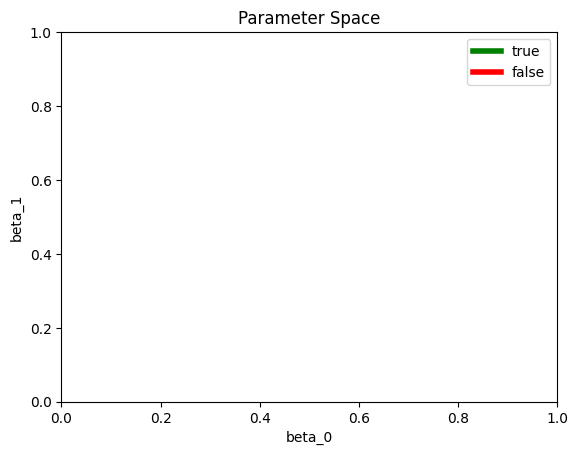

In [15]:
from funman_demo import plot
plot.plot_parameter_space(result.parameter_space, 1.0, True)

In [6]:
# Close out server
server.should_exit = True
thread.join()

INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [648]
